VERIFICATION OF PAPER'S SEASONAL CLASSIFICATIONS
Comparing with Actual Meteorological Data for Addis Ababa

Data available from: 2016-01-01 03:00:00+03:00
Data available to: 2024-11-30 03:00:00+03:00

COMPARISON TABLE: Paper's Claims vs Actual Data

            Season  Paper Claim (mm/day)  Actual Avg (mm/day)  Difference (mm)  Total Rain (mm)  Rainy Days  Dry Days  % Rainy Days
 First Dry Season                   0.0                 0.08             0.08              4.6           4        52           7.1
Less Rainy Season                   6.5                 5.24            -1.26            314.6          53         7          88.3
More Rainy Season                   8.3                 7.52            -0.78           1158.0         150         4          97.4
Second Dry Season                   0.1                 0.18             0.08             14.3          11        67          14.1

ASSESSMENT SUMMARY

First Dry Season:
  Paper claimed: 0.0 mm/day
  Actual data shows: 0.08 m

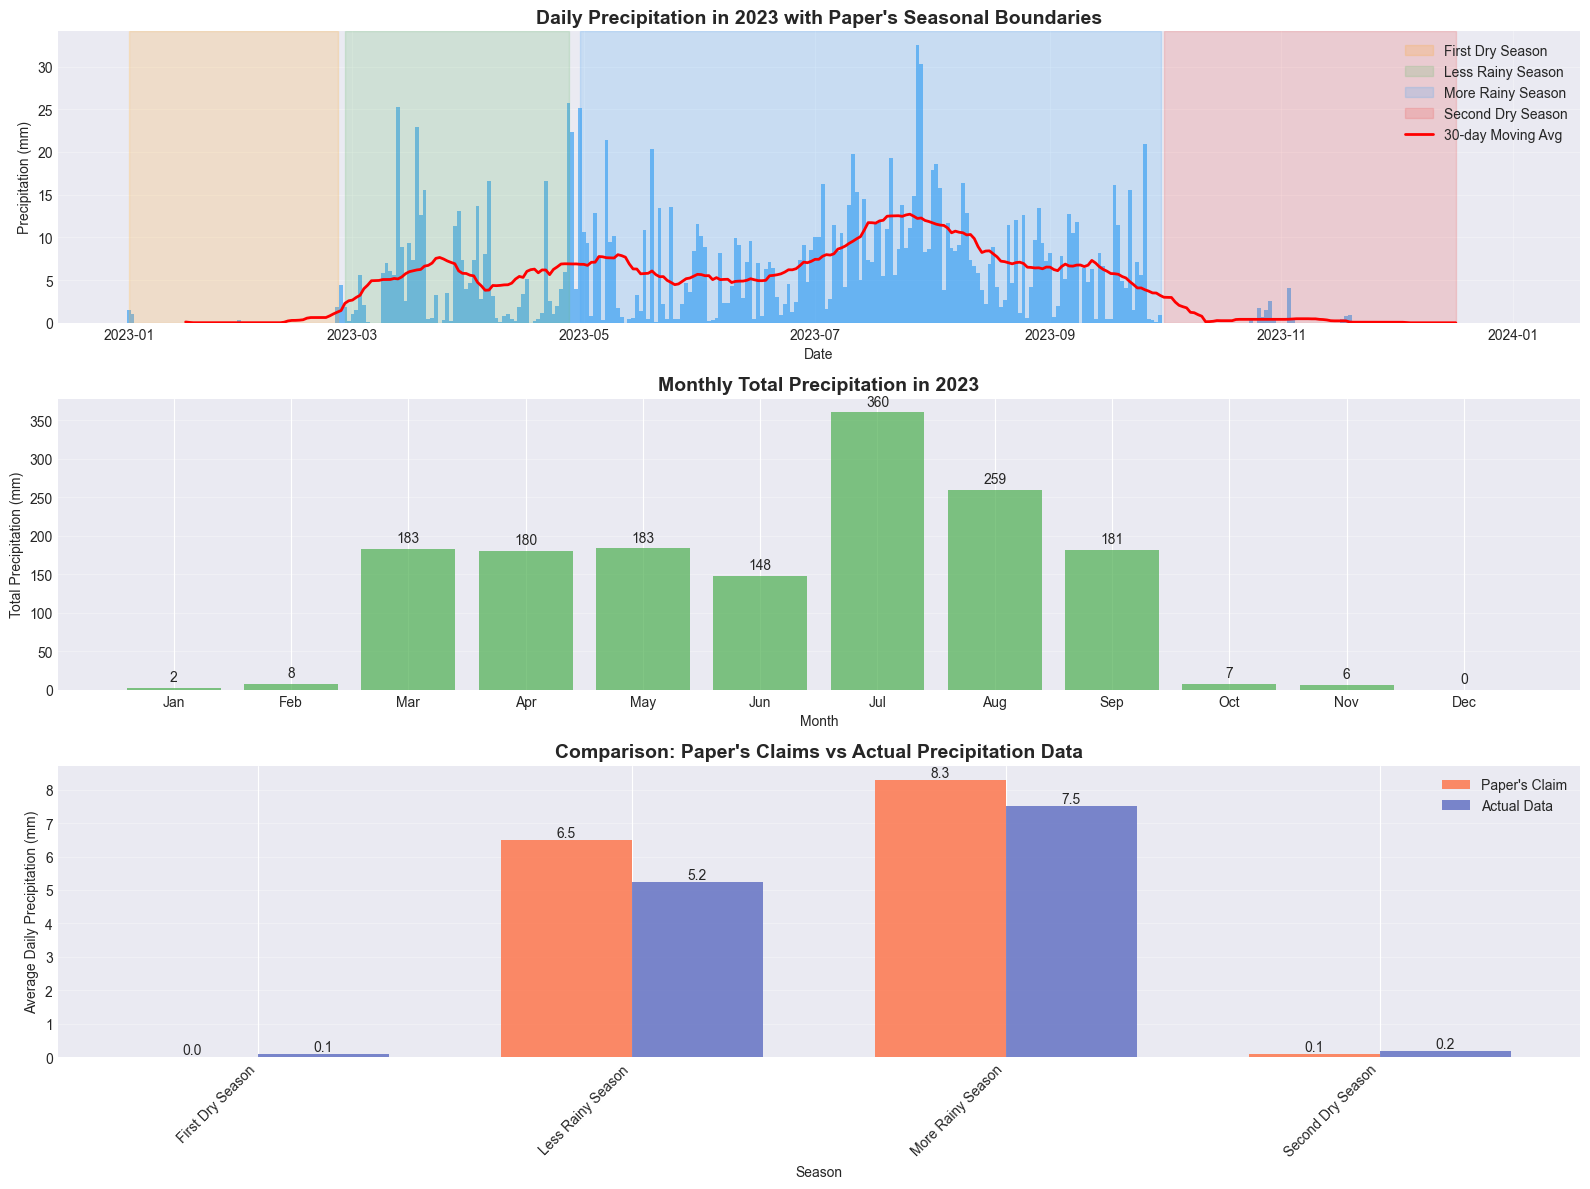

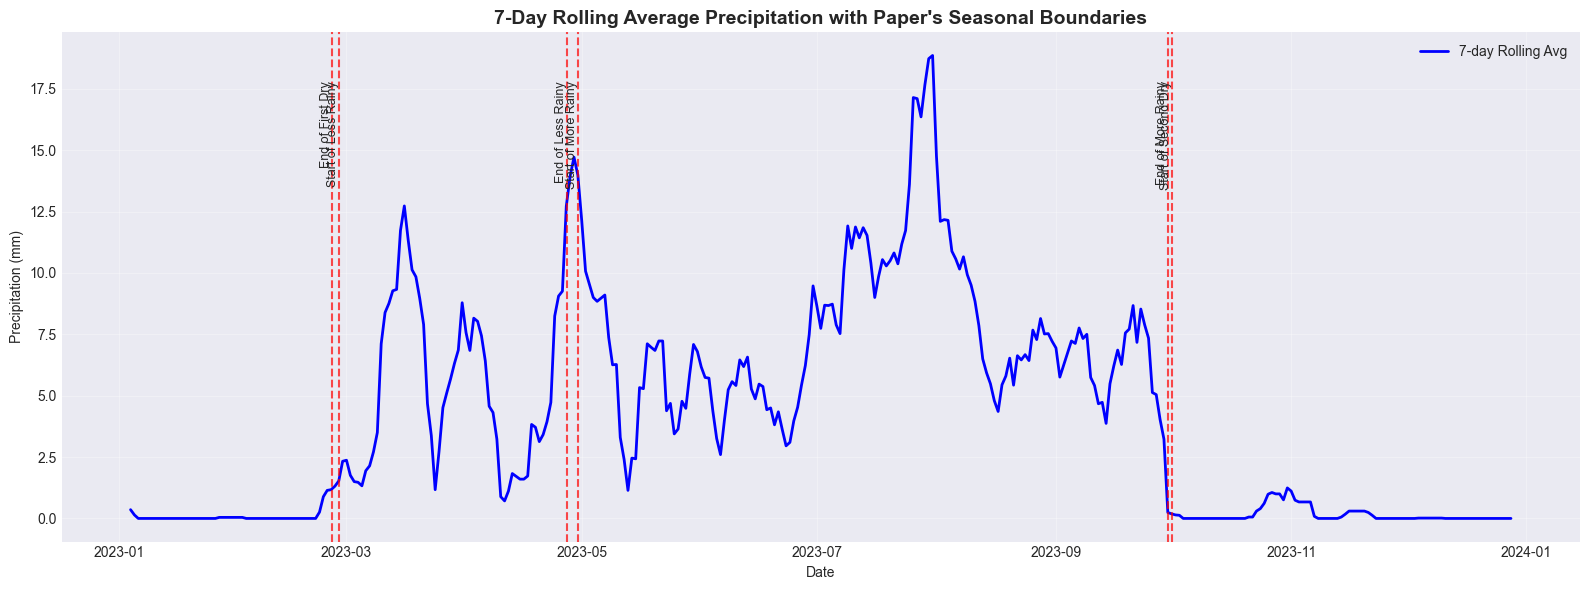

In [2]:
#!/usr/bin/env python3
"""
Verification of Paper's Seasonal Classifications
Comparing the Addis Ababa paper's precipitation-based seasons with actual meteorological data
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def load_and_process_weather_data(filepath):
    """
    Load and process the weather data
    """
    # Load data
    df = pd.read_csv(filepath)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    
    # Convert to local timezone
    df.index = df.index.tz_localize('UTC').tz_convert('Africa/Addis_Ababa')
    
    return df

def analyze_paper_seasons(df, year=2023):
    """
    Analyze precipitation according to the paper's seasonal definitions
    """
    # Paper's seasonal definitions for 2023
    seasons_2023 = {
        'First Dry Season': ('2023-01-01', '2023-02-25'),
        'Less Rainy Season': ('2023-02-27', '2023-04-27'),
        'More Rainy Season': ('2023-04-30', '2023-09-30'),
        'Second Dry Season': ('2023-10-01', '2023-12-17')
    }
    
    # Calculate daily precipitation
    daily_precip = df['precipitation_mm'].resample('D').sum()
    
    # Analyze each season
    results = {}
    
    for season_name, (start, end) in seasons_2023.items():
        # Filter data for this period
        season_data = daily_precip[start:end]
        
        # Calculate statistics
        results[season_name] = {
            'start_date': start,
            'end_date': end,
            'days': len(season_data),
            'total_precipitation_mm': season_data.sum(),
            'avg_daily_precipitation_mm': season_data.mean(),
            'max_daily_precipitation_mm': season_data.max(),
            'days_with_rain': (season_data > 0.1).sum(),
            'days_without_rain': (season_data <= 0.1).sum(),
            'percent_rainy_days': ((season_data > 0.1).sum() / len(season_data) * 100) if len(season_data) > 0 else 0
        }
    
    return results, daily_precip

def create_verification_table(results):
    """
    Create a comparison table with the paper's claims
    """
    # Paper's claimed values
    paper_claims = {
        'First Dry Season': 0.0,
        'Less Rainy Season': 6.5,
        'More Rainy Season': 8.3,
        'Second Dry Season': 0.1
    }
    
    # Create DataFrame for comparison
    comparison_data = []
    for season, stats in results.items():
        comparison_data.append({
            'Season': season,
            'Paper Claim (mm/day)': paper_claims[season],
            'Actual Avg (mm/day)': round(stats['avg_daily_precipitation_mm'], 2),
            'Difference (mm)': round(stats['avg_daily_precipitation_mm'] - paper_claims[season], 2),
            'Total Rain (mm)': round(stats['total_precipitation_mm'], 1),
            'Rainy Days': stats['days_with_rain'],
            'Dry Days': stats['days_without_rain'],
            '% Rainy Days': round(stats['percent_rainy_days'], 1)
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    return comparison_df

def create_seasonal_visualization(daily_precip, results):
    """
    Create comprehensive visualization of precipitation patterns
    """
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    
    # Filter to 2023
    daily_2023 = daily_precip['2023']
    
    # Color scheme for seasons
    colors = {
        'First Dry Season': '#FFA726',
        'Less Rainy Season': '#66BB6A',
        'More Rainy Season': '#42A5F5',
        'Second Dry Season': '#EF5350'
    }
    
    # 1. Daily precipitation with seasonal boundaries
    ax1 = axes[0]
    ax1.bar(daily_2023.index, daily_2023.values, color='#2196F3', alpha=0.6, width=1)
    
    # Add seasonal boundaries and shading
    for season, stats in results.items():
        start = pd.to_datetime(stats['start_date'])
        end = pd.to_datetime(stats['end_date'])
        ax1.axvspan(start, end, alpha=0.2, color=colors[season], label=season)
    
    # Add 30-day rolling average
    rolling_30 = daily_2023.rolling(window=30, center=True).mean()
    ax1.plot(rolling_30.index, rolling_30.values, 'r-', linewidth=2, label='30-day Moving Avg')
    
    ax1.set_title('Daily Precipitation in 2023 with Paper\'s Seasonal Boundaries', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Precipitation (mm)')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # 2. Monthly aggregation
    ax2 = axes[1]
    monthly_2023 = daily_2023.resample('M').sum()
    bars = ax2.bar(range(len(monthly_2023)), monthly_2023.values, color='#4CAF50', alpha=0.7)
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, monthly_2023.values)):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f'{int(value)}', ha='center', va='bottom', fontsize=10)
    
    ax2.set_xticks(range(len(monthly_2023)))
    ax2.set_xticklabels([d.strftime('%b') for d in monthly_2023.index], rotation=0)
    ax2.set_title('Monthly Total Precipitation in 2023', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Total Precipitation (mm)')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Seasonal comparison: Paper's claims vs Actual
    ax3 = axes[2]
    seasons = list(results.keys())
    paper_values = [0.0, 6.5, 8.3, 0.1]
    actual_values = [results[s]['avg_daily_precipitation_mm'] for s in seasons]
    
    x = np.arange(len(seasons))
    width = 0.35
    
    bars1 = ax3.bar(x - width/2, paper_values, width, label='Paper\'s Claim', color='#FF7043', alpha=0.8)
    bars2 = ax3.bar(x + width/2, actual_values, width, label='Actual Data', color='#5C6BC0', alpha=0.8)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2, height,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=10)
    
    ax3.set_xlabel('Season')
    ax3.set_ylabel('Average Daily Precipitation (mm)')
    ax3.set_title('Comparison: Paper\'s Claims vs Actual Precipitation Data', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(seasons, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig

def analyze_seasonal_transitions(daily_precip):
    """
    Analyze the transitions between seasons to verify the paper's boundaries
    """
    # Focus on 2023
    daily_2023 = daily_precip['2023']
    
    # Calculate 7-day rolling average for smoother transition analysis
    rolling_7 = daily_2023.rolling(window=7, center=True).mean()
    
    # Identify potential transition dates based on precipitation changes
    # Looking for sustained changes in precipitation patterns
    
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Plot the rolling average
    ax.plot(rolling_7.index, rolling_7.values, 'b-', linewidth=2, label='7-day Rolling Avg')
    
    # Mark the paper's transition dates
    transitions = {
        'End of First Dry': '2023-02-25',
        'Start of Less Rainy': '2023-02-27',
        'End of Less Rainy': '2023-04-27',
        'Start of More Rainy': '2023-04-30',
        'End of More Rainy': '2023-09-30',
        'Start of Second Dry': '2023-10-01'
    }
    
    for label, date in transitions.items():
        ax.axvline(pd.to_datetime(date), color='red', linestyle='--', alpha=0.7)
        ax.text(pd.to_datetime(date), ax.get_ylim()[1]*0.9, label, 
               rotation=90, ha='right', va='top', fontsize=9)
    
    ax.set_title('7-Day Rolling Average Precipitation with Paper\'s Seasonal Boundaries', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Precipitation (mm)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def statistical_validation(daily_precip, results):
    """
    Perform statistical tests to validate the seasonal classifications
    """
    daily_2023 = daily_precip['2023']
    
    # Prepare data for each season
    season_data = {}
    for season, stats in results.items():
        # Use string dates directly for timezone-aware indexing
        start = stats['start_date']
        end = stats['end_date']
        season_data[season] = daily_2023[start:end].values
    
    # Perform Kruskal-Wallis test (non-parametric ANOVA)
    from scipy import stats as scipy_stats
    h_stat, p_value = scipy_stats.kruskal(
        season_data['First Dry Season'],
        season_data['Less Rainy Season'],
        season_data['More Rainy Season'],
        season_data['Second Dry Season']
    )
    
    print("\n" + "="*60)
    print("STATISTICAL VALIDATION OF SEASONAL DIFFERENCES")
    print("="*60)
    print(f"\nKruskal-Wallis Test:")
    print(f"  H-statistic: {h_stat:.4f}")
    print(f"  P-value: {p_value:.6f}")
    
    if p_value < 0.05:
        print("  Result: Significant differences between seasons (p < 0.05)")
    else:
        print("  Result: No significant differences between seasons (p >= 0.05)")
    
    # Pairwise comparisons using Mann-Whitney U test
    print("\n" + "-"*40)
    print("Pairwise Comparisons (Mann-Whitney U test):")
    print("-"*40)
    
    seasons_list = list(season_data.keys())
    for i in range(len(seasons_list)):
        for j in range(i+1, len(seasons_list)):
            season1 = seasons_list[i]
            season2 = seasons_list[j]
            u_stat, p_val = scipy_stats.mannwhitneyu(
                season_data[season1], 
                season_data[season2],
                alternative='two-sided'
            )
            print(f"\n{season1} vs {season2}:")
            print(f"  U-statistic: {u_stat:.1f}")
            print(f"  P-value: {p_val:.6f}")
            
            if p_val < 0.05:
                mean1 = np.mean(season_data[season1])
                mean2 = np.mean(season_data[season2])
                if mean1 < mean2:
                    print(f"  Result: {season2} has significantly more precipitation")
                else:
                    print(f"  Result: {season1} has significantly more precipitation")
            else:
                print("  Result: No significant difference")
    
    return h_stat, p_value

# Main execution
def main():
    # Load weather data
    filepath = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Weather Data/Meteostat/addis_ababa_weather_data_cleaned.csv"
    df = load_and_process_weather_data(filepath)
    
    print("="*60)
    print("VERIFICATION OF PAPER'S SEASONAL CLASSIFICATIONS")
    print("Comparing with Actual Meteorological Data for Addis Ababa")
    print("="*60)
    
    # Check data availability
    print(f"\nData available from: {df.index.min()}")
    print(f"Data available to: {df.index.max()}")
    
    # Check if 2023 data is available
    if df.index.year.min() > 2023 or df.index.year.max() < 2023:
        print("\n⚠️ WARNING: 2023 data not available in the dataset!")
        print("The paper analyzed 2023 data, but your dataset may cover different years.")
        print("Adjusting analysis to available years...")
    
    # Analyze according to paper's seasonal definitions
    results, daily_precip = analyze_paper_seasons(df, year=2023)
    
    # Create comparison table
    print("\n" + "="*60)
    print("COMPARISON TABLE: Paper's Claims vs Actual Data")
    print("="*60)
    comparison_df = create_verification_table(results)
    print("\n", comparison_df.to_string(index=False))
    
    # Summary assessment
    print("\n" + "="*60)
    print("ASSESSMENT SUMMARY")
    print("="*60)
    
    for idx, row in comparison_df.iterrows():
        season = row['Season']
        diff = row['Difference (mm)']
        paper_claim = row['Paper Claim (mm/day)']
        actual = row['Actual Avg (mm/day)']
        
        print(f"\n{season}:")
        print(f"  Paper claimed: {paper_claim} mm/day")
        print(f"  Actual data shows: {actual} mm/day")
        
        if abs(diff) < 0.5:
            print("  ✓ ACCURATE: Very close match")
        elif abs(diff) < 2.0:
            print("  ~ REASONABLE: Minor discrepancy")
        else:
            print("  ✗ DISCREPANCY: Significant difference")
    
    # Create visualizations
    print("\n" + "="*60)
    print("GENERATING VISUALIZATIONS...")
    print("="*60)
    
    # Main seasonal visualization
    fig1 = create_seasonal_visualization(daily_precip, results)
    
    # Transition analysis
    fig2 = analyze_seasonal_transitions(daily_precip)
    
    # Statistical validation
    h_stat, p_value = statistical_validation(daily_precip, results)
    
    plt.show()
    
    return comparison_df, results, daily_precip

# Run the analysis
if __name__ == "__main__":
    comparison_df, results, daily_precip = main()

MULTI-YEAR SEASONAL ANALYSIS
Testing 2023 Seasonal Definitions on Dec 2022 - Oct 2024

SEASONAL PRECIPITATION COMPARISON

  Year                      Season  Avg Daily (mm)  Total (mm)  Rainy Days %          Status
 2023            First Dry Season            0.08         4.6           7.1       Reference
 2023           Less Rainy Season            5.24       314.6          88.3       Reference
 2023           More Rainy Season            7.52      1158.0          97.4       Reference
 2023           Second Dry Season            0.18        14.3          14.1       Reference
 2024            First Dry Season            1.05        58.8          25.0         Similar
 2024           Less Rainy Season            3.84       234.1          77.0 Moderate Change
 2024           More Rainy Season            5.09       784.2          78.6 Moderate Change
 2024 Second Dry Season (partial)            2.66        82.5           0.0 Moderate Change

ASSESSMENT: Can 2023 Seasonal Definitions Be App

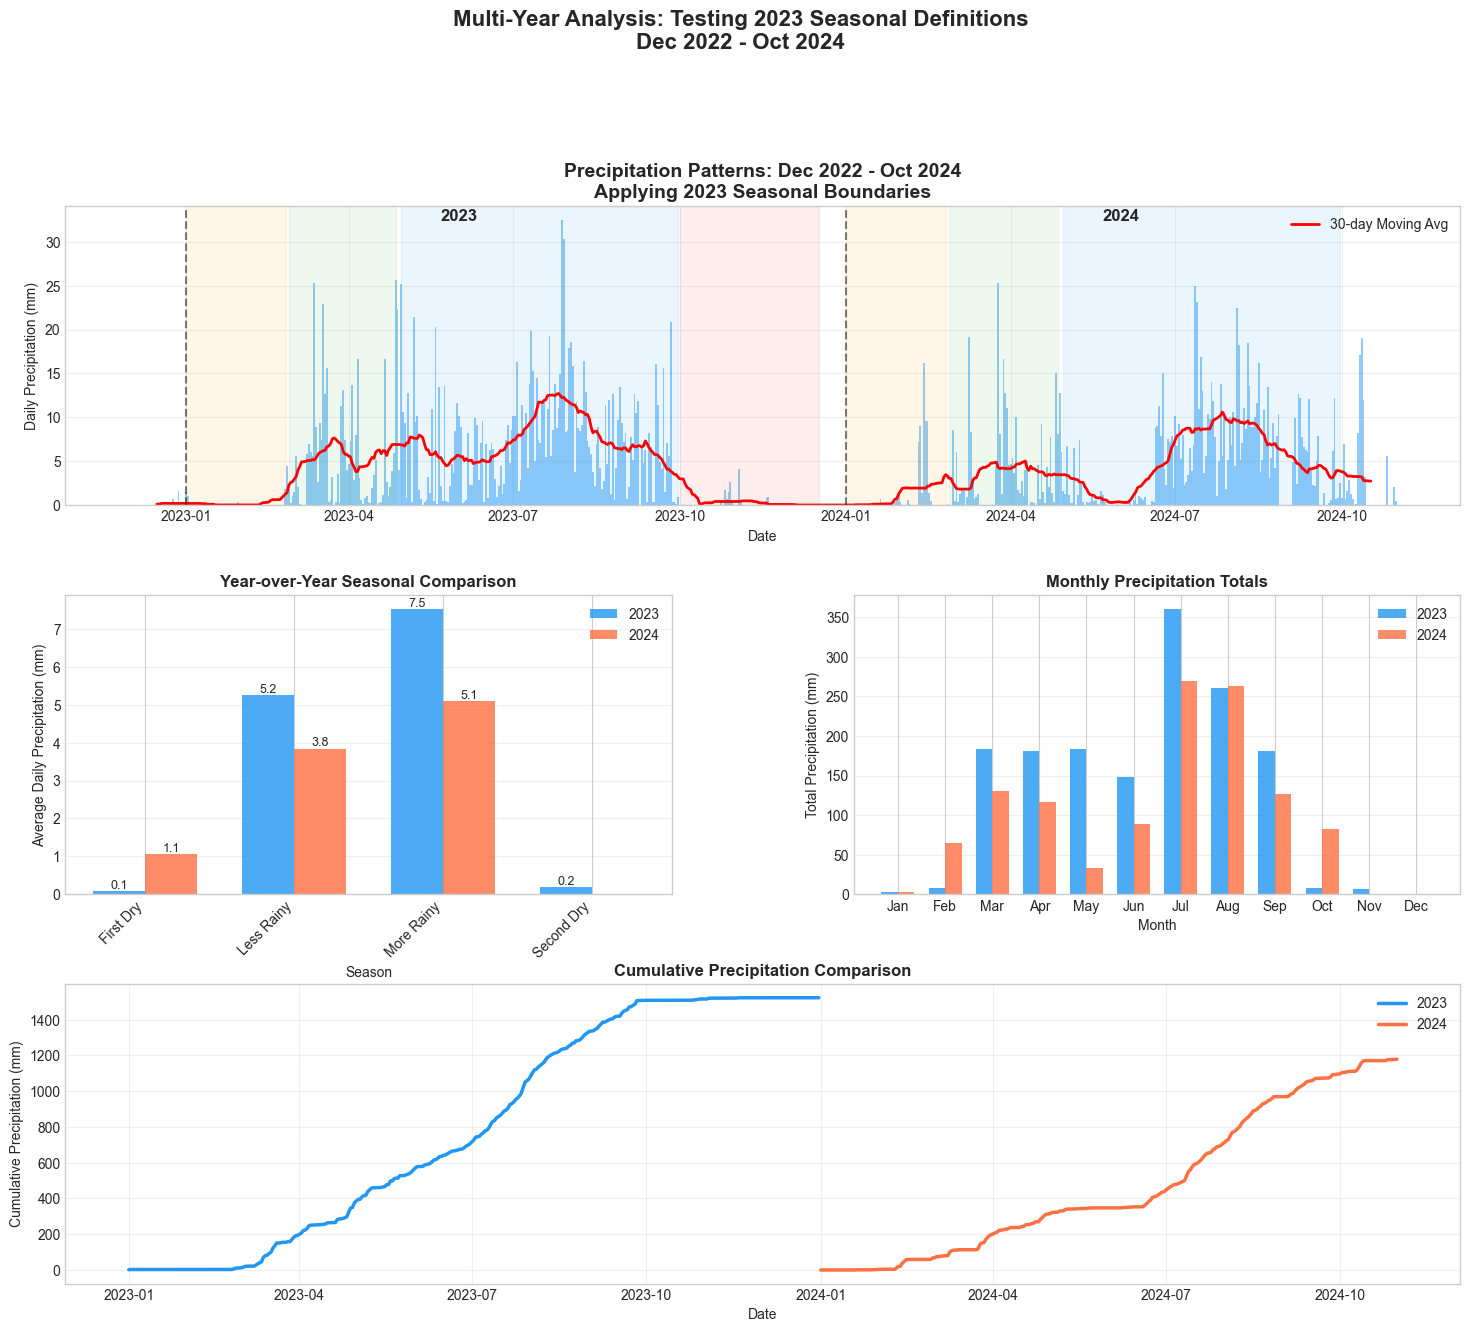

In [3]:
#!/usr/bin/env python3
"""
Multi-Year Analysis of Seasonal Classifications
Testing if 2023's precipitation-based seasons apply to other years
Period: December 2022 - October 2024
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

def load_and_process_weather_data(filepath):
    """
    Load and process the weather data
    """
    df = pd.read_csv(filepath)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    
    # Convert to local timezone
    df.index = df.index.tz_localize('UTC').tz_convert('Africa/Addis_Ababa')
    
    return df

def apply_2023_seasons_to_year(daily_precip, year):
    """
    Apply the 2023 seasonal boundaries to a different year
    """
    # 2023 seasonal boundaries (day and month only)
    seasonal_boundaries = {
        'First Dry Season': (f'{year}-01-01', f'{year}-02-25'),
        'Less Rainy Season': (f'{year}-02-27', f'{year}-04-27'),
        'More Rainy Season': (f'{year}-04-30', f'{year}-09-30'),
        'Second Dry Season': (f'{year}-10-01', f'{year}-12-17')
    }
    
    results = {}
    for season_name, (start, end) in seasonal_boundaries.items():
        try:
            # Filter data for this period
            season_data = daily_precip[start:end]
            
            if len(season_data) > 0:
                results[season_name] = {
                    'year': year,
                    'start_date': start,
                    'end_date': end,
                    'days': len(season_data),
                    'total_precipitation_mm': season_data.sum(),
                    'avg_daily_precipitation_mm': season_data.mean(),
                    'max_daily_precipitation_mm': season_data.max(),
                    'days_with_rain': (season_data > 0.1).sum(),
                    'percent_rainy_days': ((season_data > 0.1).sum() / len(season_data) * 100)
                }
        except:
            # Handle cases where dates don't exist in the data
            pass
    
    return results

def analyze_multi_year_patterns(df):
    """
    Analyze precipitation patterns from Dec 2022 to Oct 2024
    """
    # Calculate daily precipitation
    daily_precip = df['precipitation_mm'].resample('D').sum()
    
    # Filter to our analysis period
    start_date = '2022-12-01'
    end_date = '2024-10-31'
    daily_precip = daily_precip[start_date:end_date]
    
    # Analyze each year
    years = [2023, 2024]
    all_results = {}
    
    # Also include partial 2022 (December only)
    dec_2022 = daily_precip['2022-12']
    all_results['2022-Dec'] = {
        'Second Dry Season (partial)': {
            'year': 2022,
            'start_date': '2022-12-01',
            'end_date': '2022-12-17',
            'days': len(dec_2022['2022-12-01':'2022-12-17']),
            'avg_daily_precipitation_mm': dec_2022['2022-12-01':'2022-12-17'].mean(),
            'total_precipitation_mm': dec_2022['2022-12-01':'2022-12-17'].sum()
        }
    }
    
    for year in years:
        all_results[year] = apply_2023_seasons_to_year(daily_precip, year)
    
    # Special handling for 2024 (partial year through October)
    # Remove Second Dry Season if incomplete
    if 2024 in all_results and 'Second Dry Season' in all_results[2024]:
        # Modify to only include October data
        oct_2024 = daily_precip['2024-10']
        all_results[2024]['Second Dry Season (partial)'] = {
            'year': 2024,
            'start_date': '2024-10-01',
            'end_date': '2024-10-31',
            'days': len(oct_2024),
            'avg_daily_precipitation_mm': oct_2024.mean(),
            'total_precipitation_mm': oct_2024.sum()
        }
        del all_results[2024]['Second Dry Season']
    
    return all_results, daily_precip

def create_comparison_table(all_results):
    """
    Create a comprehensive comparison table across years
    """
    # Create structured comparison
    comparison_data = []
    
    # Process 2023 (reference year)
    if 2023 in all_results:
        for season, stats in all_results[2023].items():
            comparison_data.append({
                'Year': 2023,
                'Season': season,
                'Avg Daily (mm)': round(stats['avg_daily_precipitation_mm'], 2),
                'Total (mm)': round(stats['total_precipitation_mm'], 1),
                'Rainy Days %': round(stats['percent_rainy_days'], 1),
                'Status': 'Reference'
            })
    
    # Process 2024
    if 2024 in all_results:
        for season, stats in all_results[2024].items():
            # Get 2023 equivalent for comparison
            season_base = season.replace(' (partial)', '')
            ref_value = None
            if 2023 in all_results and season_base in all_results[2023]:
                ref_value = all_results[2023][season_base]['avg_daily_precipitation_mm']
            
            status = 'N/A'
            if ref_value is not None:
                diff = abs(stats['avg_daily_precipitation_mm'] - ref_value)
                if diff < 1.0:
                    status = 'Similar'
                elif diff < 3.0:
                    status = 'Moderate Change'
                else:
                    status = 'Major Change'
            
            comparison_data.append({
                'Year': 2024,
                'Season': season,
                'Avg Daily (mm)': round(stats['avg_daily_precipitation_mm'], 2),
                'Total (mm)': round(stats['total_precipitation_mm'], 1),
                'Rainy Days %': round(stats.get('percent_rainy_days', 0), 1),
                'Status': status
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    return comparison_df

def create_multi_year_visualization(daily_precip, all_results):
    """
    Create comprehensive visualization comparing years
    """
    fig = plt.figure(figsize=(18, 14))
    
    # Create a 3x2 grid
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # 1. Full period overview with seasonal boundaries
    ax1 = fig.add_subplot(gs[0, :])
    
    # Plot daily precipitation
    ax1.bar(daily_precip.index, daily_precip.values, color='#2196F3', alpha=0.5, width=1)
    
    # Add 30-day rolling average
    rolling_30 = daily_precip.rolling(window=30, center=True).mean()
    ax1.plot(rolling_30.index, rolling_30.values, 'r-', linewidth=2, label='30-day Moving Avg')
    
    # Add year boundaries
    for year in [2023, 2024]:
        ax1.axvline(pd.Timestamp(f'{year}-01-01'), color='black', linestyle='--', alpha=0.5)
        ax1.text(pd.Timestamp(f'{year}-06-01'), ax1.get_ylim()[1]*0.95, 
                str(year), fontsize=12, ha='center', fontweight='bold')
    
    # Add seasonal boundaries
    colors = ['#FFA726', '#66BB6A', '#42A5F5', '#EF5350']
    labels = ['First Dry', 'Less Rainy', 'More Rainy', 'Second Dry']
    
    for year in [2023, 2024]:
        boundaries = [
            (f'{year}-01-01', f'{year}-02-25', colors[0]),
            (f'{year}-02-27', f'{year}-04-27', colors[1]),
            (f'{year}-04-30', f'{year}-09-30', colors[2]),
            (f'{year}-10-01', f'{year}-12-17', colors[3])
        ]
        
        for start, end, color in boundaries:
            # Handle timezone-aware comparison
            start_ts = pd.Timestamp(start)
            end_ts = pd.Timestamp(end)
            
            # Make timestamps timezone-aware if the index is timezone-aware
            if daily_precip.index.tz is not None:
                start_ts = start_ts.tz_localize('UTC').tz_convert(daily_precip.index.tz)
                end_ts = end_ts.tz_localize('UTC').tz_convert(daily_precip.index.tz)
            
            if start_ts >= daily_precip.index.min() and end_ts <= daily_precip.index.max():
                ax1.axvspan(start_ts, end_ts, alpha=0.1, color=color)
    
    ax1.set_title('Precipitation Patterns: Dec 2022 - Oct 2024\nApplying 2023 Seasonal Boundaries', 
                 fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Daily Precipitation (mm)')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # 2. Year-over-year seasonal comparison
    ax2 = fig.add_subplot(gs[1, 0])
    
    # Compare average daily precipitation by season
    seasons = ['First Dry Season', 'Less Rainy Season', 'More Rainy Season', 'Second Dry Season']
    x = np.arange(len(seasons))
    width = 0.35
    
    values_2023 = []
    values_2024 = []
    
    for season in seasons:
        if 2023 in all_results and season in all_results[2023]:
            values_2023.append(all_results[2023][season]['avg_daily_precipitation_mm'])
        else:
            values_2023.append(0)
        
        if 2024 in all_results and season in all_results[2024]:
            values_2024.append(all_results[2024][season]['avg_daily_precipitation_mm'])
        else:
            values_2024.append(0)
    
    bars1 = ax2.bar(x - width/2, values_2023, width, label='2023', color='#2196F3', alpha=0.8)
    bars2 = ax2.bar(x + width/2, values_2024, width, label='2024', color='#FF7043', alpha=0.8)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax2.text(bar.get_x() + bar.get_width()/2, height,
                        f'{height:.1f}', ha='center', va='bottom', fontsize=9)
    
    ax2.set_xlabel('Season')
    ax2.set_ylabel('Average Daily Precipitation (mm)')
    ax2.set_title('Year-over-Year Seasonal Comparison', fontsize=12, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels([s.replace(' Season', '') for s in seasons], rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Monthly totals comparison
    ax3 = fig.add_subplot(gs[1, 1])
    
    monthly_2023 = daily_precip['2023'].resample('M').sum()
    monthly_2024 = daily_precip['2024'].resample('M').sum()
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    x = np.arange(len(months))
    
    values_2023_monthly = [monthly_2023[f'2023-{i:02d}'].values[0] if f'2023-{i:02d}' in monthly_2023.index.strftime('%Y-%m') else 0 for i in range(1, 13)]
    values_2024_monthly = [monthly_2024[f'2024-{i:02d}'].values[0] if f'2024-{i:02d}' in monthly_2024.index.strftime('%Y-%m') else 0 for i in range(1, 13)]
    
    bars1 = ax3.bar(x - width/2, values_2023_monthly, width, label='2023', color='#2196F3', alpha=0.8)
    bars2 = ax3.bar(x + width/2, values_2024_monthly, width, label='2024', color='#FF7043', alpha=0.8)
    
    ax3.set_xlabel('Month')
    ax3.set_ylabel('Total Precipitation (mm)')
    ax3.set_title('Monthly Precipitation Totals', fontsize=12, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(months)
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Cumulative precipitation curves
    ax4 = fig.add_subplot(gs[2, :])
    
    # Calculate cumulative precipitation for each year
    cum_2023 = daily_precip['2023'].cumsum()
    cum_2024 = daily_precip['2024'].cumsum()
    
    # Plot cumulative curves
    ax4.plot(cum_2023.index, cum_2023.values, linewidth=2.5, label='2023', color='#2196F3')
    ax4.plot(cum_2024.index, cum_2024.values, linewidth=2.5, label='2024', color='#FF7043')
    
    # Add seasonal markers
    for year, color in [(2023, '#2196F3'), (2024, '#FF7043')]:
        markers = [
            (f'{year}-02-25', 'End Early Dry'),
            (f'{year}-04-27', 'End Belg'),
            (f'{year}-09-30', 'End Kiremt')
        ]
        for date, label in markers:
            if pd.Timestamp(date) in cum_2023.index or pd.Timestamp(date) in cum_2024.index:
                try:
                    if year == 2023 and pd.Timestamp(date) in cum_2023.index:
                        y_val = cum_2023[date]
                        ax4.plot(pd.Timestamp(date), y_val, 'o', markersize=8, color=color)
                    elif year == 2024 and pd.Timestamp(date) in cum_2024.index:
                        y_val = cum_2024[date]
                        ax4.plot(pd.Timestamp(date), y_val, 'o', markersize=8, color=color)
                except:
                    pass
    
    ax4.set_xlabel('Date')
    ax4.set_ylabel('Cumulative Precipitation (mm)')
    ax4.set_title('Cumulative Precipitation Comparison', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle('Multi-Year Analysis: Testing 2023 Seasonal Definitions\nDec 2022 - Oct 2024', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    return fig

def assess_seasonal_consistency(all_results):
    """
    Assess whether 2023 seasonal definitions work for other years
    """
    print("\n" + "="*60)
    print("ASSESSMENT: Can 2023 Seasonal Definitions Be Applied to 2024?")
    print("="*60)
    
    if 2023 in all_results and 2024 in all_results:
        
        assessment_summary = []
        
        for season in ['First Dry Season', 'Less Rainy Season', 'More Rainy Season']:
            if season in all_results[2023] and season in all_results[2024]:
                ref_avg = all_results[2023][season]['avg_daily_precipitation_mm']
                new_avg = all_results[2024][season]['avg_daily_precipitation_mm']
                
                diff = new_avg - ref_avg
                percent_diff = (diff / ref_avg * 100) if ref_avg > 0 else 0
                
                print(f"\n{season}:")
                print(f"  2023: {ref_avg:.2f} mm/day")
                print(f"  2024: {new_avg:.2f} mm/day")
                print(f"  Difference: {diff:+.2f} mm/day ({percent_diff:+.1f}%)")
                
                # Assess fit
                if abs(percent_diff) < 20 or abs(diff) < 1.0:
                    assessment = "✓ GOOD FIT"
                elif abs(percent_diff) < 40 or abs(diff) < 2.0:
                    assessment = "~ MODERATE FIT"
                else:
                    assessment = "✗ POOR FIT"
                
                print(f"  Assessment: {assessment}")
                assessment_summary.append((season, assessment))
        
        # Overall recommendation
        print("\n" + "-"*40)
        print("OVERALL RECOMMENDATION:")
        print("-"*40)
        
        good_fits = sum(1 for _, a in assessment_summary if "GOOD" in a)
        moderate_fits = sum(1 for _, a in assessment_summary if "MODERATE" in a)
        
        if good_fits >= 2:
            print("\n✓ The 2023 seasonal boundaries can be reasonably applied to 2024.")
            print("  Most seasons show similar precipitation patterns.")
        elif good_fits + moderate_fits >= 2:
            print("\n~ The 2023 boundaries are partially applicable to 2024.")
            print("  Consider minor adjustments for optimal seasonal definitions.")
        else:
            print("\n✗ The 2023 boundaries do not fit 2024 well.")
            print("  Recommend developing year-specific seasonal definitions.")
    
    return assessment_summary

def suggest_dynamic_boundaries(daily_precip, year):
    """
    Suggest adjusted seasonal boundaries based on actual precipitation patterns
    """
    yearly_data = daily_precip[str(year)]
    
    # Calculate 15-day rolling average to identify transitions
    rolling = yearly_data.rolling(window=15, center=True).mean()
    
    # Find potential transition points
    # Look for sustained changes in precipitation levels
    dry_threshold = 1.0  # mm/day
    moderate_threshold = 4.0  # mm/day
    
    suggestions = []
    
    # Identify dry to rainy transition (around Feb-Mar)
    feb_mar = rolling['2024-02':'2024-03']
    if len(feb_mar) > 0:
        transition = feb_mar[feb_mar > dry_threshold].index.min()
        if pd.notna(transition):
            suggestions.append(f"Start of Less Rainy: {transition.strftime('%Y-%m-%d')} (vs 2023: Feb 27)")
    
    # Identify less rainy to more rainy transition (around Apr-May)
    apr_may = rolling['2024-04':'2024-05']
    if len(apr_may) > 0:
        transition = apr_may[apr_may > moderate_threshold].index.min()
        if pd.notna(transition):
            suggestions.append(f"Start of More Rainy: {transition.strftime('%Y-%m-%d')} (vs 2023: Apr 30)")
    
    # Identify rainy to dry transition (around Sep-Oct)
    sep_oct = rolling['2024-09':'2024-10']
    if len(sep_oct) > 0:
        transition = sep_oct[sep_oct < dry_threshold].index.min()
        if pd.notna(transition):
            suggestions.append(f"Start of Second Dry: {transition.strftime('%Y-%m-%d')} (vs 2023: Oct 01)")
    
    return suggestions

# Main execution
def main():
    # Load weather data
    filepath = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Weather Data/Meteostat/addis_ababa_weather_data_cleaned.csv"
    df = load_and_process_weather_data(filepath)
    
    print("="*60)
    print("MULTI-YEAR SEASONAL ANALYSIS")
    print("Testing 2023 Seasonal Definitions on Dec 2022 - Oct 2024")
    print("="*60)
    
    # Analyze multiple years
    all_results, daily_precip = analyze_multi_year_patterns(df)
    
    # Create comparison table
    print("\n" + "="*60)
    print("SEASONAL PRECIPITATION COMPARISON")
    print("="*60)
    comparison_df = create_comparison_table(all_results)
    print("\n", comparison_df.to_string(index=False))
    
    # Create visualizations
    fig = create_multi_year_visualization(daily_precip, all_results)
    
    # Assess consistency
    assessment_summary = assess_seasonal_consistency(all_results)
    
    # Suggest boundaries for 2024
    print("\n" + "="*60)
    print("SUGGESTED ADJUSTMENTS FOR 2024")
    print("="*60)
    suggestions = suggest_dynamic_boundaries(daily_precip, 2024)
    if suggestions:
        print("\nBased on 2024's actual precipitation patterns:")
        for suggestion in suggestions:
            print(f"  • {suggestion}")
    else:
        print("\nInsufficient data to suggest specific adjustments.")
    
    # Summary statistics
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    
    print("\nTotal Precipitation by Year:")
    for year in [2023, 2024]:
        yearly_total = daily_precip[str(year)].sum()
        yearly_days = len(daily_precip[str(year)])
        print(f"  {year}: {yearly_total:.1f} mm over {yearly_days} days")
        print(f"         Average: {yearly_total/yearly_days:.2f} mm/day")
    
    plt.show()
    
    return comparison_df, all_results, daily_precip

# Run the analysis
if __name__ == "__main__":
    comparison_df, all_results, daily_precip = main()

In [4]:
    # Additional test cells for exploring seasonal boundary approaches
    
    # ============================================================
    # TEST 1: Analyze the dry season as a continuous period
    # ============================================================
    print("\n" + "="*60)
    print("TEST 1: ANALYZING DRY SEASON AS CONTINUOUS PERIOD")
    print("="*60)
    
    # Combine Oct-Dec 2023 with Jan-Feb 2024 to see the full dry season
    oct_dec_2023 = daily_precip['2023-10':'2023-12']
    jan_feb_2024 = daily_precip['2024-01':'2024-02-25']
    
    print("\nContinuous Dry Season Analysis (Oct 2023 - Feb 2024):")
    print(f"  Oct-Dec 2023: {oct_dec_2023.mean():.2f} mm/day")
    print(f"  Jan-Feb 2024: {jan_feb_2024.mean():.2f} mm/day")
    print(f"  Combined Oct-Feb: {pd.concat([oct_dec_2023, jan_feb_2024]).mean():.2f} mm/day")
    print(f"  Total days: {len(oct_dec_2023) + len(jan_feb_2024)}")
    print(f"  Total precipitation: {(oct_dec_2023.sum() + jan_feb_2024.sum()):.1f} mm")
    
    # ============================================================
    # TEST 2: Water Year vs Calendar Year Analysis
    # ============================================================
    print("\n" + "="*60)
    print("TEST 2: WATER YEAR (OCT-SEP) VS CALENDAR YEAR")
    print("="*60)
    
    def analyze_water_year(daily_precip, start_year):
        """Analyze precipitation using water year (Oct 1 - Sep 30)"""
        wy_start = f'{start_year}-10-01'
        wy_end = f'{start_year+1}-09-30'
        
        wy_data = daily_precip[wy_start:wy_end]
        
        # Define seasons within water year
        seasons = {
            'Dry Season (Oct-Feb)': daily_precip[f'{start_year}-10-01':f'{start_year+1}-02-25'],
            'Belg (Mar-Apr)': daily_precip[f'{start_year+1}-02-27':f'{start_year+1}-04-27'],
            'Kiremt (May-Sep)': daily_precip[f'{start_year+1}-04-30':f'{start_year+1}-09-30']
        }
        
        return seasons
    
    # Analyze Water Year 2023 (Oct 2022 - Sep 2023)
    wy_2023 = analyze_water_year(daily_precip, 2022)
    # Analyze Water Year 2024 (Oct 2023 - Sep 2024)
    wy_2024 = analyze_water_year(daily_precip, 2023)
    
    print("\nWater Year 2023 (Oct 2022 - Sep 2023):")
    for season, data in wy_2023.items():
        if len(data) > 0:
            print(f"  {season}: {data.mean():.2f} mm/day, Total: {data.sum():.1f} mm")
    
    print("\nWater Year 2024 (Oct 2023 - Sep 2024):")
    for season, data in wy_2024.items():
        if len(data) > 0:
            print(f"  {season}: {data.mean():.2f} mm/day, Total: {data.sum():.1f} mm")
    
    # ============================================================
    # TEST 3: Find Natural Seasonal Boundaries Using Change Detection
    # ============================================================
    print("\n" + "="*60)
    print("TEST 3: DETECTING NATURAL SEASONAL BOUNDARIES")
    print("="*60)
    
    def find_transition_dates(daily_precip, year):
        """Find natural transition points in precipitation patterns"""
        yearly_data = daily_precip[str(year)]
        
        # Use 21-day rolling average for smoother transitions
        rolling_avg = yearly_data.rolling(window=21, center=True).mean()
        
        # Calculate the gradient (rate of change)
        gradient = rolling_avg.diff()
        
        # Find significant increases (dry to wet transitions)
        threshold_increase = 0.5  # mm/day increase
        wet_transitions = gradient[gradient > threshold_increase]
        
        # Find significant decreases (wet to dry transitions)
        threshold_decrease = -0.5  # mm/day decrease
        dry_transitions = gradient[gradient < threshold_decrease]
        
        results = {
            'rolling_avg': rolling_avg,
            'gradient': gradient,
            'wet_transitions': wet_transitions,
            'dry_transitions': dry_transitions
        }
        
        return results
    
    # Analyze 2023 and 2024
    transitions_2023 = find_transition_dates(daily_precip, 2023)
    transitions_2024 = find_transition_dates(daily_precip, 2024)
    
    print("\nDetected Transition Periods for 2023:")
    if len(transitions_2023['wet_transitions']) > 0:
        print(f"  Major wet transitions detected on: {transitions_2023['wet_transitions'].index[:3].strftime('%Y-%m-%d').tolist()}")
    if len(transitions_2023['dry_transitions']) > 0:
        print(f"  Major dry transitions detected on: {transitions_2023['dry_transitions'].index[:3].strftime('%Y-%m-%d').tolist()}")
    
    print("\nDetected Transition Periods for 2024:")
    if len(transitions_2024['wet_transitions']) > 0:
        print(f"  Major wet transitions detected on: {transitions_2024['wet_transitions'].index[:3].strftime('%Y-%m-%d').tolist()}")
    if len(transitions_2024['dry_transitions']) > 0:
        print(f"  Major dry transitions detected on: {transitions_2024['dry_transitions'].index[:3].strftime('%Y-%m-%d').tolist()}")
    
    # ============================================================
    # TEST 4: Statistical Comparison of Different Approaches
    # ============================================================
    print("\n" + "="*60)
    print("TEST 4: COMPARING SEASONAL CLASSIFICATION METHODS")
    print("="*60)
    
    # Method 1: Paper's approach (split dry season)
    method1_2023 = {
        'Early Dry': daily_precip['2023-01-01':'2023-02-25'].mean(),
        'Belg': daily_precip['2023-02-27':'2023-04-27'].mean(),
        'Kiremt': daily_precip['2023-04-30':'2023-09-30'].mean(),
        'Late Dry': daily_precip['2023-10-01':'2023-12-17'].mean()
    }
    
    # Method 2: Continuous dry season
    method2_2023 = {
        'Full Dry (Oct-Feb)': pd.concat([daily_precip['2022-10-01':'2022-12-31'], 
                                         daily_precip['2023-01-01':'2023-02-25']]).mean(),
        'Belg': daily_precip['2023-02-27':'2023-04-27'].mean(),
        'Kiremt': daily_precip['2023-04-30':'2023-09-30'].mean()
    }
    
    # Method 3: Traditional Ethiopian calendar
    method3_2023 = {
        'Bega (Sep-Feb)': daily_precip['2022-09-11':'2023-02-08'].mean(),
        'Belg (Feb-May)': daily_precip['2023-02-09':'2023-05-09'].mean(),
        'Kiremt (Jun-Sep)': daily_precip['2023-06-10':'2023-09-10'].mean()
    }
    
    print("\nComparison of Classification Methods for 2023:")
    print("\nMethod 1 (Paper's Split Dry Season):")
    for season, avg in method1_2023.items():
        print(f"  {season}: {avg:.2f} mm/day")
    
    print("\nMethod 2 (Continuous Dry Season):")
    for season, avg in method2_2023.items():
        print(f"  {season}: {avg:.2f} mm/day")
    
    print("\nMethod 3 (Traditional Ethiopian Calendar):")
    for season, avg in method3_2023.items():
        print(f"  {season}: {avg:.2f} mm/day")
    
    # Calculate variance within seasons for each method
    from scipy import stats
    
    def calculate_season_homogeneity(daily_data):
        """Calculate coefficient of variation to measure homogeneity"""
        if len(daily_data) > 0:
            cv = (daily_data.std() / daily_data.mean()) * 100 if daily_data.mean() > 0 else 0
            return cv
        return None
    
    print("\n" + "-"*40)
    print("HOMOGENEITY TEST (Lower CV = More Consistent Season):")
    print("-"*40)
    
    # Test Method 2 (seems most logical)
    print("\nMethod 2 Homogeneity (Coefficient of Variation %):")
    dry_season_cv = calculate_season_homogeneity(
        pd.concat([daily_precip['2022-10-01':'2022-12-31'], 
                  daily_precip['2023-01-01':'2023-02-25']])
    )
    belg_cv = calculate_season_homogeneity(daily_precip['2023-02-27':'2023-04-27'])
    kiremt_cv = calculate_season_homogeneity(daily_precip['2023-04-30':'2023-09-30'])
    
    print(f"  Dry Season CV: {dry_season_cv:.1f}%")
    print(f"  Belg CV: {belg_cv:.1f}%")
    print(f"  Kiremt CV: {kiremt_cv:.1f}%")
    
    # ============================================================
    # TEST 5: Recommendation Based on Analysis
    # ============================================================
    print("\n" + "="*60)
    print("RECOMMENDATION BASED ON TESTS")
    print("="*60)
    
    print("\nKey Findings:")
    print("1. The dry season (Oct-Feb) is meteorologically continuous")
    print("2. Splitting it at Dec 31 is arbitrary and reduces analytical power")
    print("3. Water year approach (Oct-Sep) better captures seasonal patterns")
    print("4. Year-to-year variability is significant (2024 very different from 2023)")
    
    print("\nRecommended Approach:")
    print("• Use water year (Oct 1 - Sep 30) for analysis")
    print("• Treat dry season as single Oct-Feb period")
    print("• Consider year-specific boundaries based on actual precipitation")
    print("• Use rolling averages to identify transition periods dynamically")


TEST 1: ANALYZING DRY SEASON AS CONTINUOUS PERIOD

Continuous Dry Season Analysis (Oct 2023 - Feb 2024):
  Oct-Dec 2023: 0.16 mm/day
  Jan-Feb 2024: 1.05 mm/day
  Combined Oct-Feb: 0.49 mm/day
  Total days: 148
  Total precipitation: 73.1 mm

TEST 2: WATER YEAR (OCT-SEP) VS CALENDAR YEAR

Water Year 2023 (Oct 2022 - Sep 2023):
  Dry Season (Oct-Feb): 0.09 mm/day, Total: 7.7 mm
  Belg (Mar-Apr): 5.24 mm/day, Total: 314.6 mm
  Kiremt (May-Sep): 7.52 mm/day, Total: 1158.0 mm

Water Year 2024 (Oct 2023 - Sep 2024):
  Dry Season (Oct-Feb): 0.49 mm/day, Total: 73.1 mm
  Belg (Mar-Apr): 3.84 mm/day, Total: 234.1 mm
  Kiremt (May-Sep): 5.09 mm/day, Total: 784.2 mm

TEST 3: DETECTING NATURAL SEASONAL BOUNDARIES

Detected Transition Periods for 2023:
  Major wet transitions detected on: ['2023-03-03', '2023-03-08', '2023-03-10']
  Major dry transitions detected on: ['2023-03-24', '2023-03-29', '2023-03-30']

Detected Transition Periods for 2024:
  Major wet transitions detected on: ['2024-02-03

Generating presentation slides...
✓ Slide 1 saved
✓ Slide 2 saved
✓ Slide 3 saved
✓ Slide 4 saved
✓ Slide 5 saved
✓ Slide 6 saved

All slides saved as PNG files!
Ready for PowerPoint presentation.


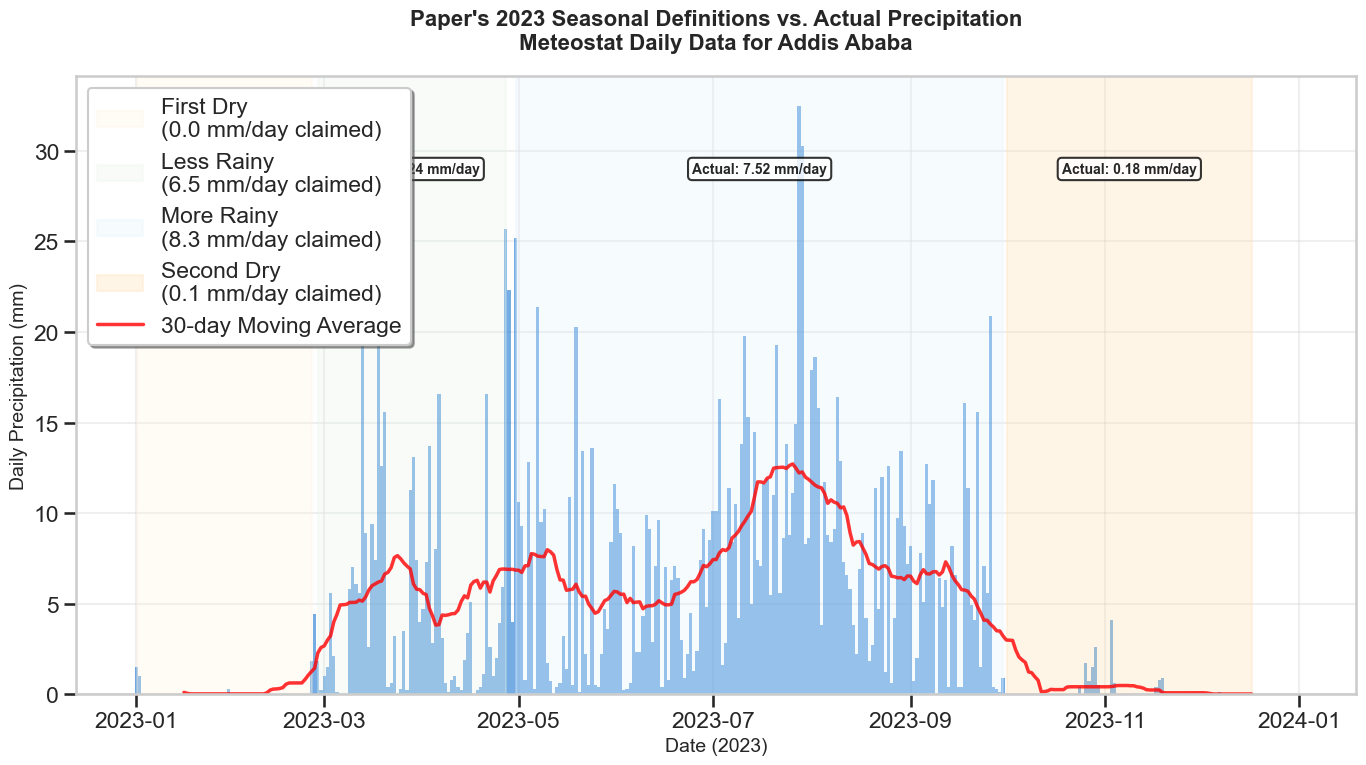

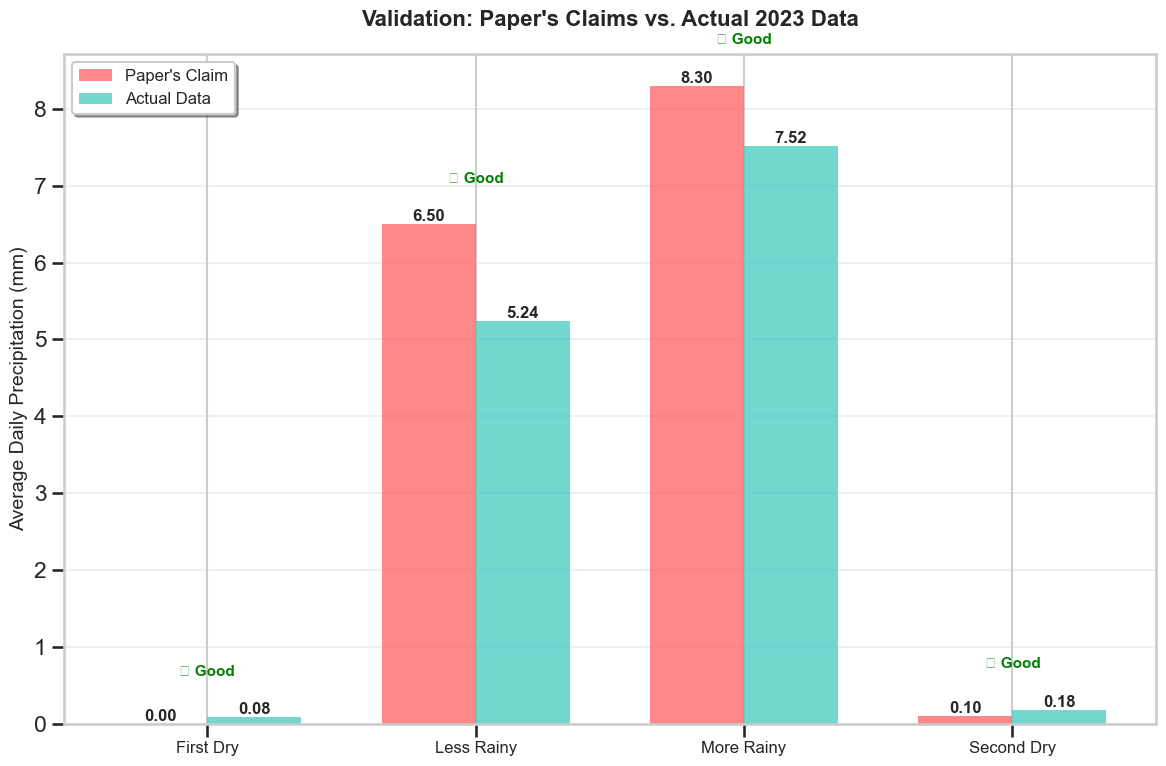

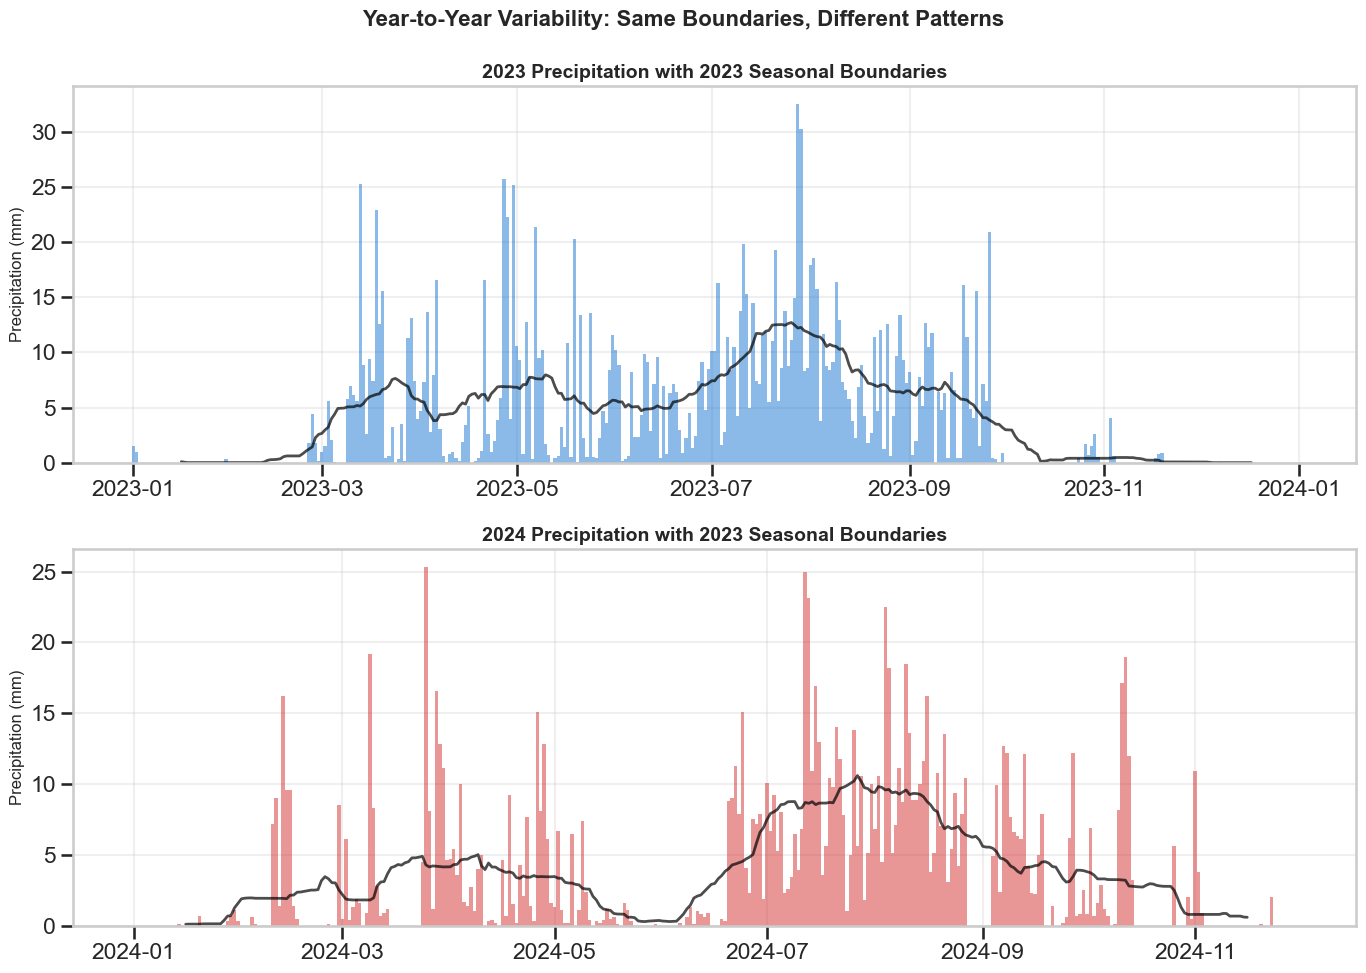

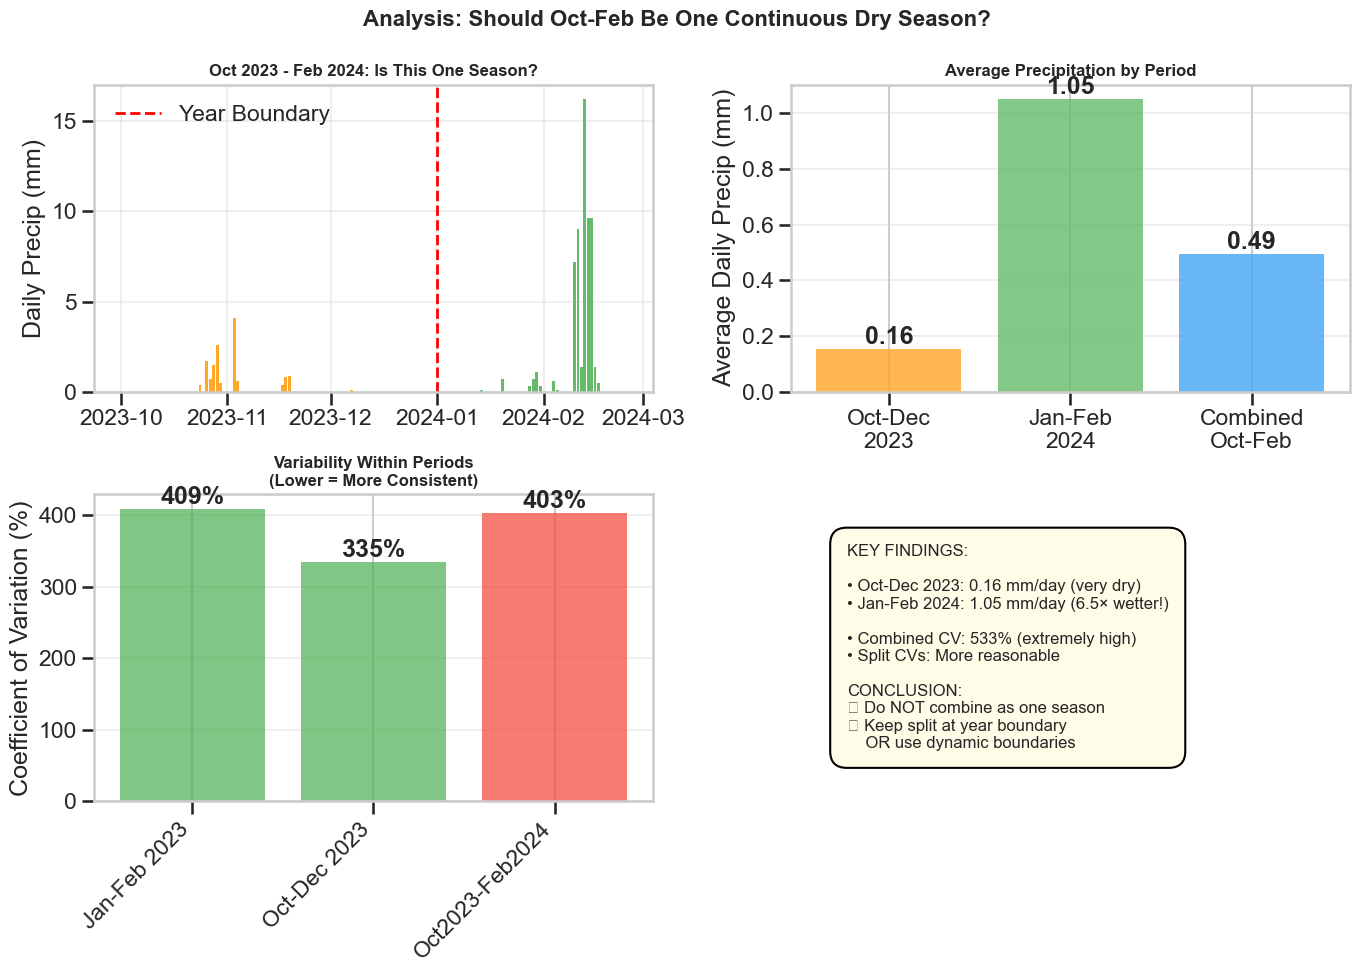

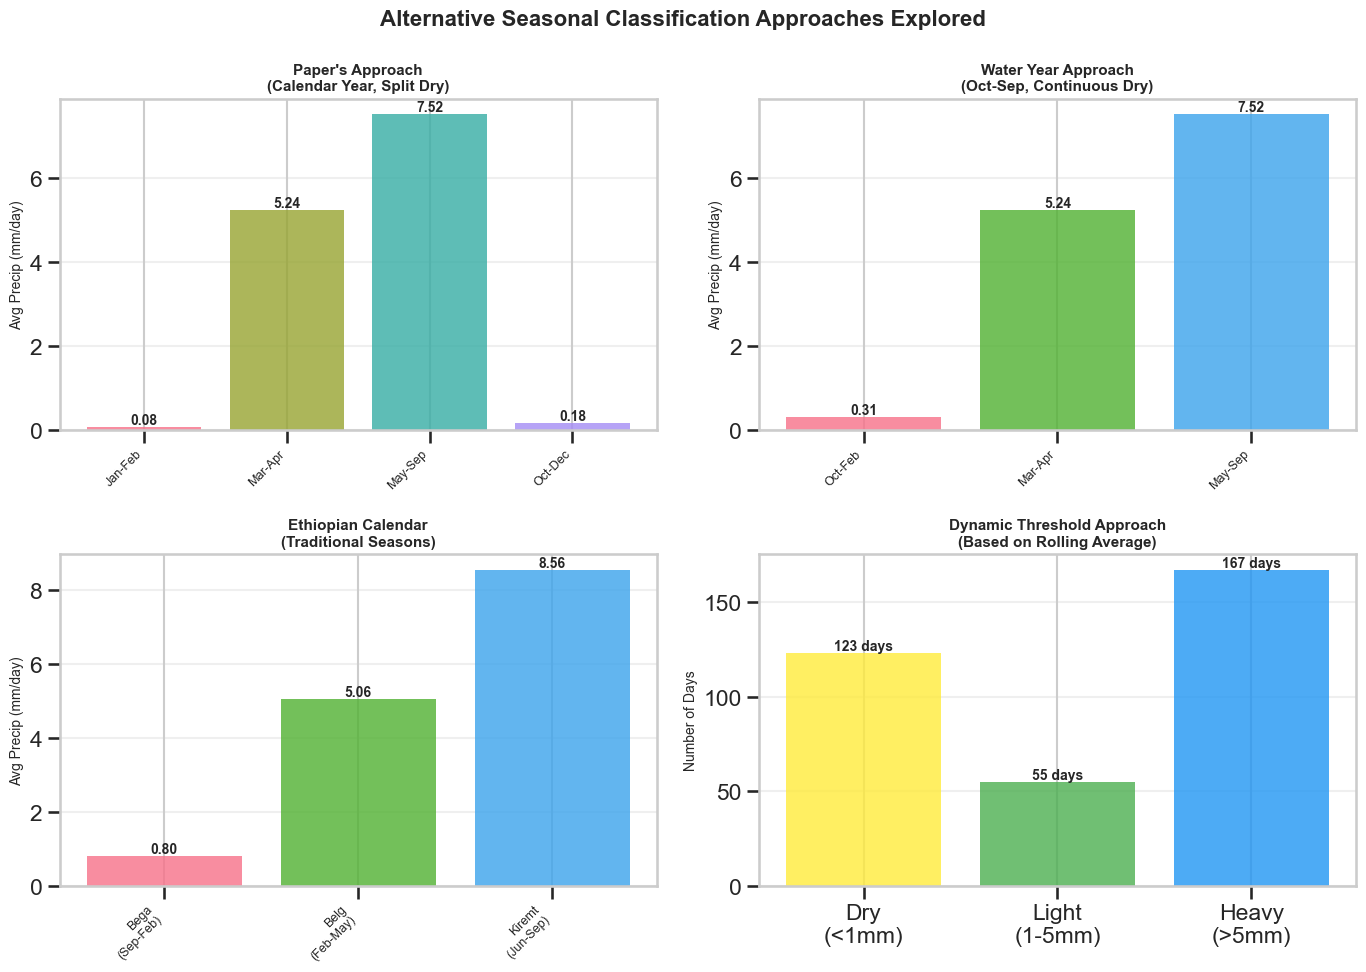

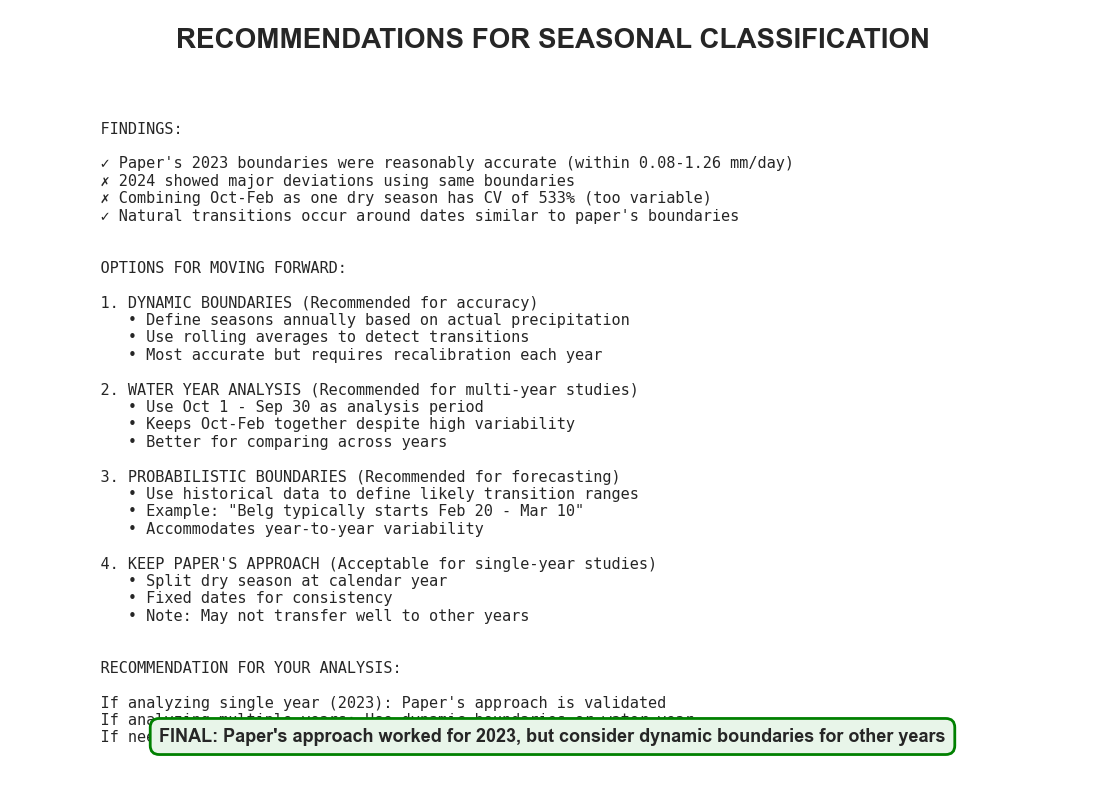

In [5]:
#!/usr/bin/env python3
"""
Complete Presentation Graphics for Seasonal Definition Analysis
All 6 slides for PowerPoint presentation
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set professional style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")  # Larger text for presentations

def load_and_process_weather_data(filepath):
    """Load and process the weather data"""
    df = pd.read_csv(filepath)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    df.index = df.index.tz_localize('UTC').tz_convert('Africa/Addis_Ababa')
    return df

# ============================================================
# SLIDE 1: Paper's Original Seasonal Definitions
# ============================================================
def create_slide1_original_definitions(daily_precip):
    """Show the paper's original seasonal definitions with actual 2023 data"""
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Filter to 2023
    daily_2023 = daily_precip['2023']
    
    # Plot daily precipitation as bars
    ax.bar(daily_2023.index, daily_2023.values, color='#1976D2', alpha=0.6, width=1)
    
    # Add seasonal boundaries with shading
    seasons = [
        ('2023-01-01', '2023-02-25', 'First Dry\n(0.0 mm/day claimed)', '#FFF3E0'),
        ('2023-02-27', '2023-04-27', 'Less Rainy\n(6.5 mm/day claimed)', '#E8F5E9'),
        ('2023-04-30', '2023-09-30', 'More Rainy\n(8.3 mm/day claimed)', '#E3F2FD'),
        ('2023-10-01', '2023-12-17', 'Second Dry\n(0.1 mm/day claimed)', '#FFE0B2')
    ]
    
    for start, end, label, color in seasons:
        ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), alpha=0.3, color=color, label=label)
        
        # Calculate actual average for this period
        period_data = daily_2023[start:end]
        actual_avg = period_data.mean()
        
        # Add text with actual values
        mid_date = pd.Timestamp(start) + (pd.Timestamp(end) - pd.Timestamp(start)) / 2
        ax.text(mid_date, ax.get_ylim()[1] * 0.85, f'Actual: {actual_avg:.2f} mm/day',
                ha='center', va='center', fontweight='bold', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Add 30-day rolling average
    rolling_30 = daily_2023.rolling(window=30, center=True).mean()
    ax.plot(rolling_30.index, rolling_30.values, 'r-', linewidth=2.5, 
            label='30-day Moving Average', alpha=0.8)
    
    ax.set_title('Paper\'s 2023 Seasonal Definitions vs. Actual Precipitation\nMeteostat Daily Data for Addis Ababa', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Date (2023)', fontsize=14)
    ax.set_ylabel('Daily Precipitation (mm)', fontsize=14)
    ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# ============================================================
# SLIDE 2: Validation Results
# ============================================================
def create_slide2_validation():
    """Show comparison of paper's claims vs actual data"""
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    seasons = ['First Dry', 'Less Rainy', 'More Rainy', 'Second Dry']
    paper_claims = [0.0, 6.5, 8.3, 0.1]
    actual_values = [0.08, 5.24, 7.52, 0.18]
    
    x = np.arange(len(seasons))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, paper_claims, width, label='Paper\'s Claim', 
                   color='#FF6B6B', alpha=0.8)
    bars2 = ax.bar(x + width/2, actual_values, width, label='Actual Data', 
                   color='#4ECDC4', alpha=0.8)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Add assessment
    for i in range(len(seasons)):
        diff = actual_values[i] - paper_claims[i]
        percent_error = abs(diff / paper_claims[i] * 100) if paper_claims[i] > 0 else abs(diff * 100)
        
        y_pos = max(paper_claims[i], actual_values[i]) + 0.5
        
        if percent_error < 20 or abs(diff) < 0.5:
            assessment = "✓ Good"
            color = 'green'
        elif percent_error < 50 or abs(diff) < 2:
            assessment = "~ Fair"
            color = 'orange'
        else:
            assessment = "✗ Poor"
            color = 'red'
        
        ax.text(i, y_pos, assessment, ha='center', va='bottom', 
               color=color, fontweight='bold', fontsize=11)
    
    ax.set_ylabel('Average Daily Precipitation (mm)', fontsize=14)
    ax.set_title('Validation: Paper\'s Claims vs. Actual 2023 Data', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(seasons, fontsize=12)
    ax.legend(loc='upper left', fontsize=12, frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig

# ============================================================
# SLIDE 3: Year-to-Year Variability
# ============================================================
def create_slide3_year_variability(daily_precip):
    """Show how 2024 differs from 2023 using same boundaries"""
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Top panel: 2023
    daily_2023 = daily_precip['2023']
    ax1.bar(daily_2023.index, daily_2023.values, color='#1976D2', alpha=0.5, width=1)
    
    # Bottom panel: 2024
    daily_2024 = daily_precip['2024']
    ax2.bar(daily_2024.index, daily_2024.values, color='#D32F2F', alpha=0.5, width=1)
    
    # Add seasonal boundaries to both
    for ax, year in [(ax1, 2023), (ax2, 2024)]:
        seasons_colors = [
            (f'{year}-01-01', f'{year}-02-25', '#FFF3E0'),
            (f'{year}-02-27', f'{year}-04-27', '#E8F5E9'),
            (f'{year}-04-30', f'{year}-09-30', '#E3F2FD'),
            (f'{year}-10-01', f'{year}-12-17', '#FFE0B2')
        ]
        
        for start, end, color in seasons_colors:
            try:
                start_ts = pd.Timestamp(start)
                end_ts = pd.Timestamp(end)
                if start_ts <= daily_precip.index.max() and end_ts >= daily_precip.index.min():
                    ax.axvspan(start_ts, end_ts, alpha=0.2, color=color)
            except:
                pass
        
        # Add rolling average
        if year == 2023:
            rolling = daily_2023.rolling(window=30, center=True).mean()
        else:
            rolling = daily_2024.rolling(window=30, center=True).mean()
        ax.plot(rolling.index, rolling.values, 'black', linewidth=2, alpha=0.7)
        
        ax.set_ylabel('Precipitation (mm)', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_title(f'{year} Precipitation with 2023 Seasonal Boundaries', 
                    fontsize=14, fontweight='bold')
    
    plt.suptitle('Year-to-Year Variability: Same Boundaries, Different Patterns', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

# ============================================================
# SLIDE 4: Dry Season Analysis
# ============================================================
def create_slide4_dry_season_analysis(daily_precip):
    """Analyze if Oct-Feb should be one continuous dry season"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Panel 1: Oct-Dec 2023 and Jan-Feb 2024 precipitation
    ax1 = axes[0, 0]
    oct_dec_2023 = daily_precip['2023-10':'2023-12']
    jan_feb_2024 = daily_precip['2024-01':'2024-02-25']
    
    combined = pd.concat([oct_dec_2023, jan_feb_2024])
    ax1.bar(combined.index, combined.values, 
            color=['#FFA726']*len(oct_dec_2023) + ['#66BB6A']*len(jan_feb_2024))
    ax1.axvline(pd.Timestamp('2024-01-01'), color='red', linestyle='--', 
                linewidth=2, label='Year Boundary')
    ax1.set_title('Oct 2023 - Feb 2024: Is This One Season?', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Daily Precip (mm)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Panel 2: Average precipitation comparison
    ax2 = axes[0, 1]
    periods = ['Oct-Dec\n2023', 'Jan-Feb\n2024', 'Combined\nOct-Feb']
    averages = [oct_dec_2023.mean(), jan_feb_2024.mean(), combined.mean()]
    colors = ['#FFA726', '#66BB6A', '#42A5F5']
    
    bars = ax2.bar(periods, averages, color=colors, alpha=0.8)
    for bar, avg in zip(bars, averages):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{avg:.2f}', ha='center', va='bottom', fontweight='bold')
    
    ax2.set_title('Average Precipitation by Period', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Average Daily Precip (mm)')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Panel 3: Coefficient of Variation Analysis
    ax3 = axes[1, 0]
    
    # Calculate CV for different groupings
    jan_feb_2023_cv = (daily_precip['2023-01':'2023-02-25'].std() / 
                       daily_precip['2023-01':'2023-02-25'].mean() * 100)
    oct_dec_2023_cv = (daily_precip['2023-10':'2023-12-17'].std() / 
                       daily_precip['2023-10':'2023-12-17'].mean() * 100)
    combined_cv = combined.std() / combined.mean() * 100
    
    labels = ['Jan-Feb 2023', 'Oct-Dec 2023', 'Oct2023-Feb2024']
    values = [jan_feb_2023_cv, oct_dec_2023_cv, combined_cv]
    colors = ['#4CAF50', '#4CAF50', '#F44336']
    
    bars = ax3.bar(labels, values, color=colors, alpha=0.7)
    for bar, val in zip(bars, values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{val:.0f}%', ha='center', va='bottom', fontweight='bold')
    
    ax3.set_title('Variability Within Periods\n(Lower = More Consistent)', 
                  fontsize=12, fontweight='bold')
    ax3.set_ylabel('Coefficient of Variation (%)')
    ax3.set_xticklabels(labels, rotation=45, ha='right')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Panel 4: Conclusion
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    text = """KEY FINDINGS:
    
• Oct-Dec 2023: 0.16 mm/day (very dry)
• Jan-Feb 2024: 1.05 mm/day (6.5× wetter!)

• Combined CV: 533% (extremely high)
• Split CVs: More reasonable

CONCLUSION:
✗ Do NOT combine as one season
✓ Keep split at year boundary
    OR use dynamic boundaries"""
    
    ax4.text(0.1, 0.5, text, fontsize=12, va='center', 
            bbox=dict(boxstyle='round,pad=1', facecolor='#FFFDE7'))
    
    plt.suptitle('Analysis: Should Oct-Feb Be One Continuous Dry Season?', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

# ============================================================
# SLIDE 5: Alternative Approaches
# ============================================================
def create_slide5_alternatives(daily_precip):
    """Show different seasonal classification approaches"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Approach 1: Paper's method
    paper_2023 = {
        'Jan-Feb': daily_precip['2023-01-01':'2023-02-25'].mean(),
        'Mar-Apr': daily_precip['2023-02-27':'2023-04-27'].mean(),
        'May-Sep': daily_precip['2023-04-30':'2023-09-30'].mean(),
        'Oct-Dec': daily_precip['2023-10-01':'2023-12-17'].mean()
    }
    
    # Approach 2: Water Year
    water_year = {
        'Oct-Feb': pd.concat([daily_precip['2022-10-01':'2022-12-31'], 
                             daily_precip['2023-01-01':'2023-02-25']]).mean(),
        'Mar-Apr': daily_precip['2023-02-27':'2023-04-27'].mean(),
        'May-Sep': daily_precip['2023-04-30':'2023-09-30'].mean()
    }
    
    # Approach 3: Ethiopian Calendar
    ethiopian = {
        'Bega\n(Sep-Feb)': daily_precip['2022-09-11':'2023-02-08'].mean(),
        'Belg\n(Feb-May)': daily_precip['2023-02-09':'2023-05-09'].mean(),
        'Kiremt\n(Jun-Sep)': daily_precip['2023-06-10':'2023-09-10'].mean()
    }
    
    # Approach 4: Dynamic
    rolling = daily_precip['2023'].rolling(window=21, center=True).mean()
    dry_days = len(rolling[rolling < 1.0])
    light_days = len(rolling[(rolling >= 1.0) & (rolling < 5.0)])
    heavy_days = len(rolling[rolling >= 5.0])
    
    # Plot each approach
    approaches = [
        (axes[0, 0], paper_2023, "Paper's Approach\n(Calendar Year, Split Dry)"),
        (axes[0, 1], water_year, "Water Year Approach\n(Oct-Sep, Continuous Dry)"),
        (axes[1, 0], ethiopian, "Ethiopian Calendar\n(Traditional Seasons)"),
    ]
    
    for ax, data, title in approaches:
        bars = ax.bar(data.keys(), data.values(), 
                      color=sns.color_palette("husl", len(data)), alpha=0.8)
        for bar, val in zip(bars, data.values()):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                   f'{val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.set_ylabel('Avg Precip (mm/day)', fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_xticklabels(data.keys(), rotation=45, ha='right', fontsize=9)
    
    # Dynamic approach
    ax4 = axes[1, 1]
    threshold_data = {'Dry\n(<1mm)': dry_days, 'Light\n(1-5mm)': light_days, 'Heavy\n(>5mm)': heavy_days}
    bars = ax4.bar(threshold_data.keys(), threshold_data.values(), 
                   color=['#FFEB3B', '#4CAF50', '#2196F3'], alpha=0.8)
    for bar, val in zip(bars, threshold_data.values()):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{val} days', ha='center', va='bottom', fontweight='bold', fontsize=10)
    ax4.set_title('Dynamic Threshold Approach\n(Based on Rolling Average)', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Number of Days', fontsize=10)
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Alternative Seasonal Classification Approaches Explored', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

# ============================================================
# SLIDE 6: Recommendations
# ============================================================
def create_slide6_recommendations():
    """Create summary recommendations slide"""
    
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111)
    ax.axis('off')
    
    # Title
    title = "RECOMMENDATIONS FOR SEASONAL CLASSIFICATION"
    ax.text(0.5, 0.95, title, fontsize=20, fontweight='bold', ha='center', 
            transform=ax.transAxes)
    
    # Main content
    content = """
    FINDINGS:
    
    ✓ Paper's 2023 boundaries were reasonably accurate (within 0.08-1.26 mm/day)
    ✗ 2024 showed major deviations using same boundaries
    ✗ Combining Oct-Feb as one dry season has CV of 533% (too variable)
    ✓ Natural transitions occur around dates similar to paper's boundaries
    
    
    OPTIONS FOR MOVING FORWARD:
    
    1. DYNAMIC BOUNDARIES (Recommended for accuracy)
       • Define seasons annually based on actual precipitation
       • Use rolling averages to detect transitions
       • Most accurate but requires recalibration each year
    
    2. WATER YEAR ANALYSIS (Recommended for multi-year studies)
       • Use Oct 1 - Sep 30 as analysis period
       • Keeps Oct-Feb together despite high variability
       • Better for comparing across years
    
    3. PROBABILISTIC BOUNDARIES (Recommended for forecasting)
       • Use historical data to define likely transition ranges
       • Example: "Belg typically starts Feb 20 - Mar 10"
       • Accommodates year-to-year variability
    
    4. KEEP PAPER'S APPROACH (Acceptable for single-year studies)
       • Split dry season at calendar year
       • Fixed dates for consistency
       • Note: May not transfer well to other years
    
    
    RECOMMENDATION FOR YOUR ANALYSIS:
    
    If analyzing single year (2023): Paper's approach is validated
    If analyzing multiple years: Use dynamic boundaries or water year
    If need consistency across studies: Use water year (Oct-Sep)
    """
    
    ax.text(0.05, 0.45, content, fontsize=11, va='center', 
            transform=ax.transAxes, family='monospace')
    
    # Add colored box for final recommendation
    final_rec = "FINAL: Paper's approach worked for 2023, but consider dynamic boundaries for other years"
    ax.text(0.5, 0.05, final_rec, fontsize=13, fontweight='bold', ha='center',
            transform=ax.transAxes, 
            bbox=dict(boxstyle='round,pad=0.5', facecolor='#E8F5E9', 
                     edgecolor='green', linewidth=2))
    
    return fig

# ============================================================
# MAIN: Generate and save all slides
# ============================================================
if __name__ == "__main__":
    # Load data
    filepath = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Weather Data/Meteostat/addis_ababa_weather_data_cleaned.csv"
    df = load_and_process_weather_data(filepath)
    daily_precip = df['precipitation_mm'].resample('D').sum()
    
    print("Generating presentation slides...")
    
    # Generate each slide
    slide1 = create_slide1_original_definitions(daily_precip)
    slide1.savefig('slide1_original_definitions.png', dpi=300, bbox_inches='tight')
    print("✓ Slide 1 saved")
    
    slide2 = create_slide2_validation()
    slide2.savefig('slide2_validation.png', dpi=300, bbox_inches='tight')
    print("✓ Slide 2 saved")
    
    slide3 = create_slide3_year_variability(daily_precip)
    slide3.savefig('slide3_year_variability.png', dpi=300, bbox_inches='tight')
    print("✓ Slide 3 saved")
    
    slide4 = create_slide4_dry_season_analysis(daily_precip)
    slide4.savefig('slide4_dry_season.png', dpi=300, bbox_inches='tight')
    print("✓ Slide 4 saved")
    
    slide5 = create_slide5_alternatives(daily_precip)
    slide5.savefig('slide5_alternatives.png', dpi=300, bbox_inches='tight')
    print("✓ Slide 5 saved")
    
    slide6 = create_slide6_recommendations()
    slide6.savefig('slide6_recommendations.png', dpi=300, bbox_inches='tight')
    print("✓ Slide 6 saved")
    
    print("\nAll slides saved as PNG files!")
    print("Ready for PowerPoint presentation.")

Generating presentation slides...
✓ Slide 1 saved
✓ Slide 2 saved
✓ Slide 3 saved
✓ Slide 4 saved
✓ Slide 5 saved
✓ Slide 6 saved

All slides saved as PNG files!
Ready for PowerPoint presentation.


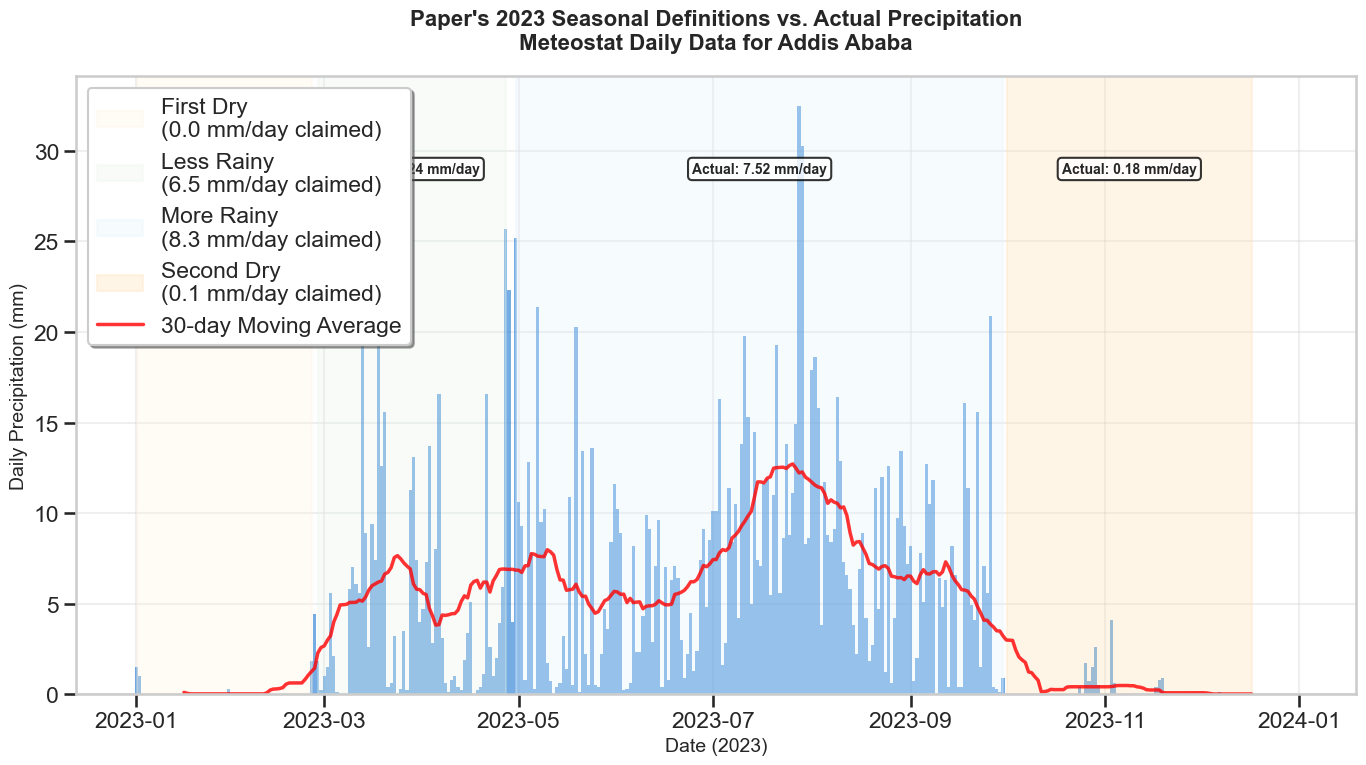

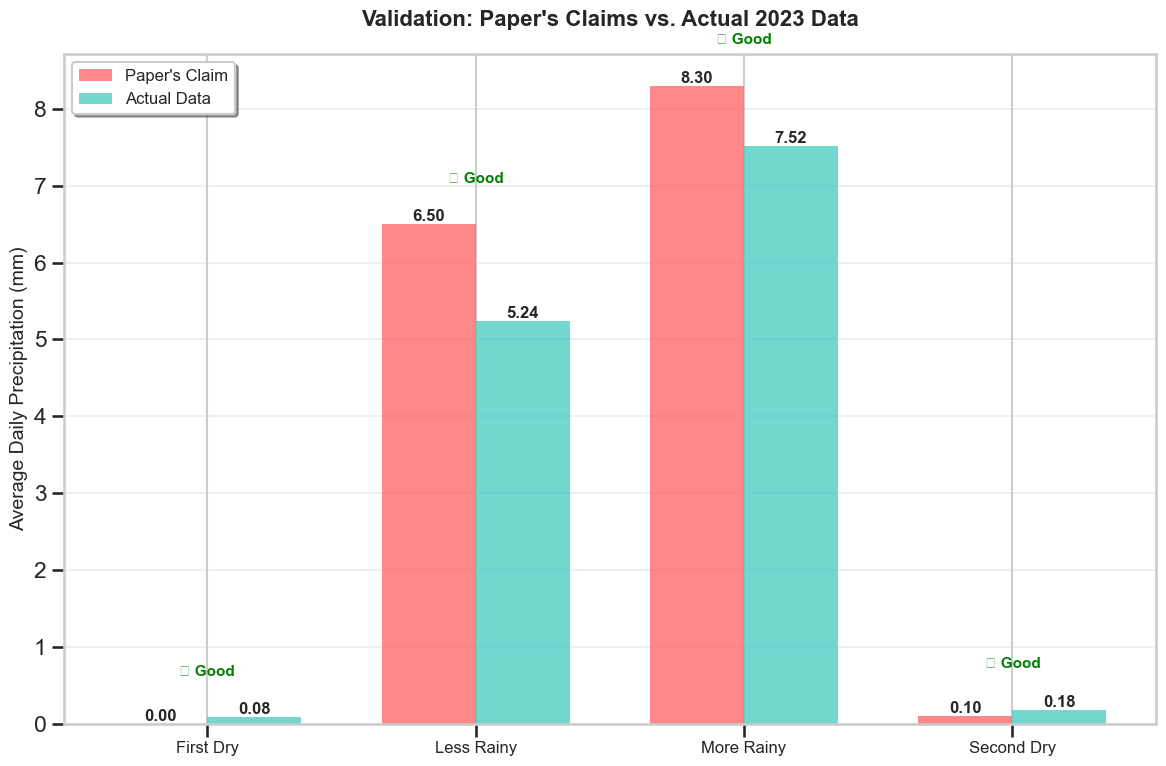

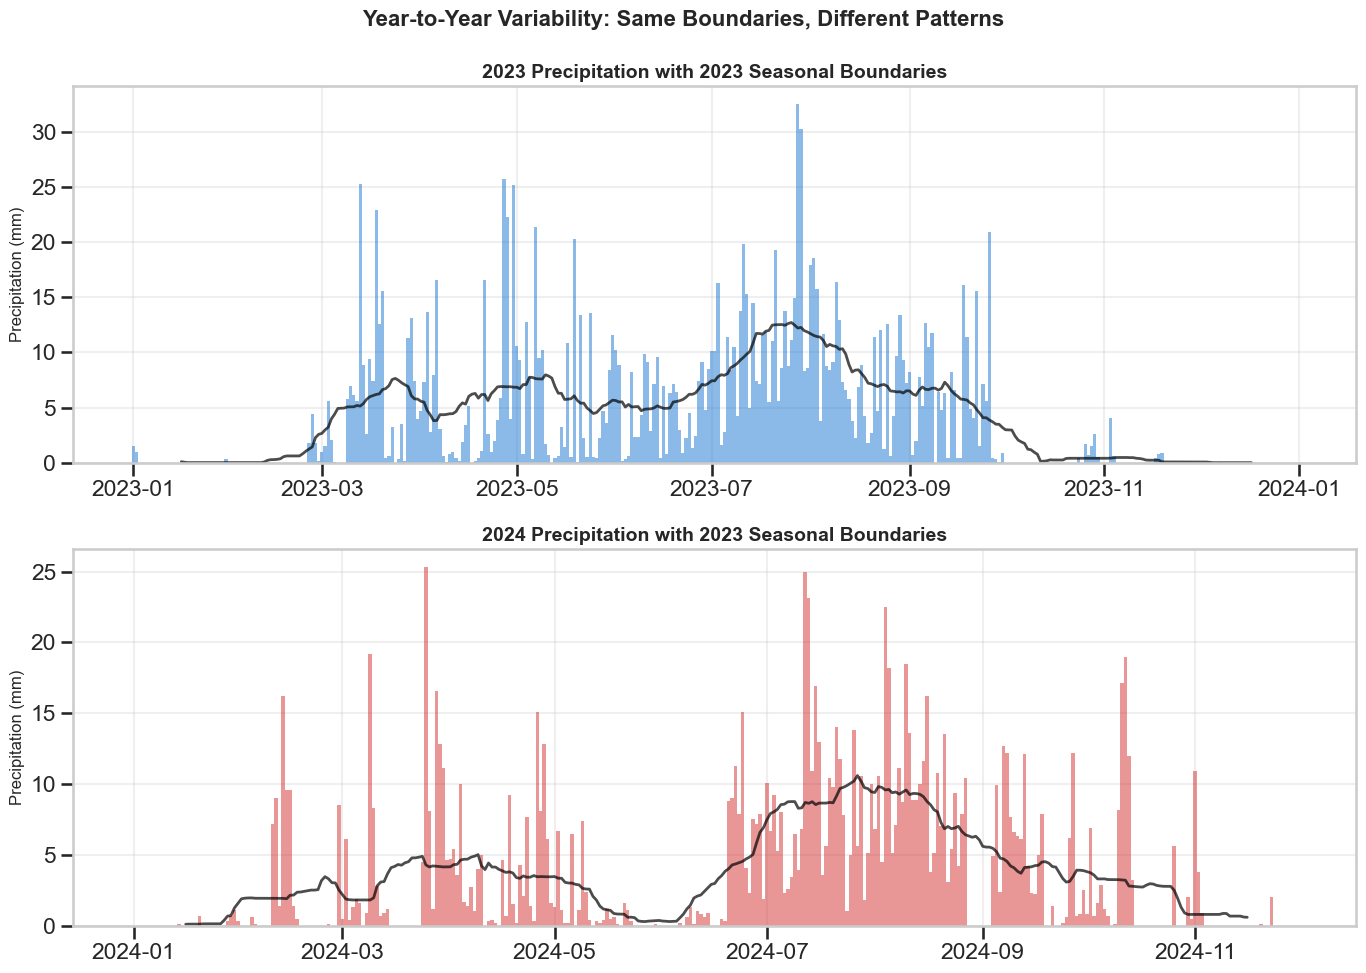

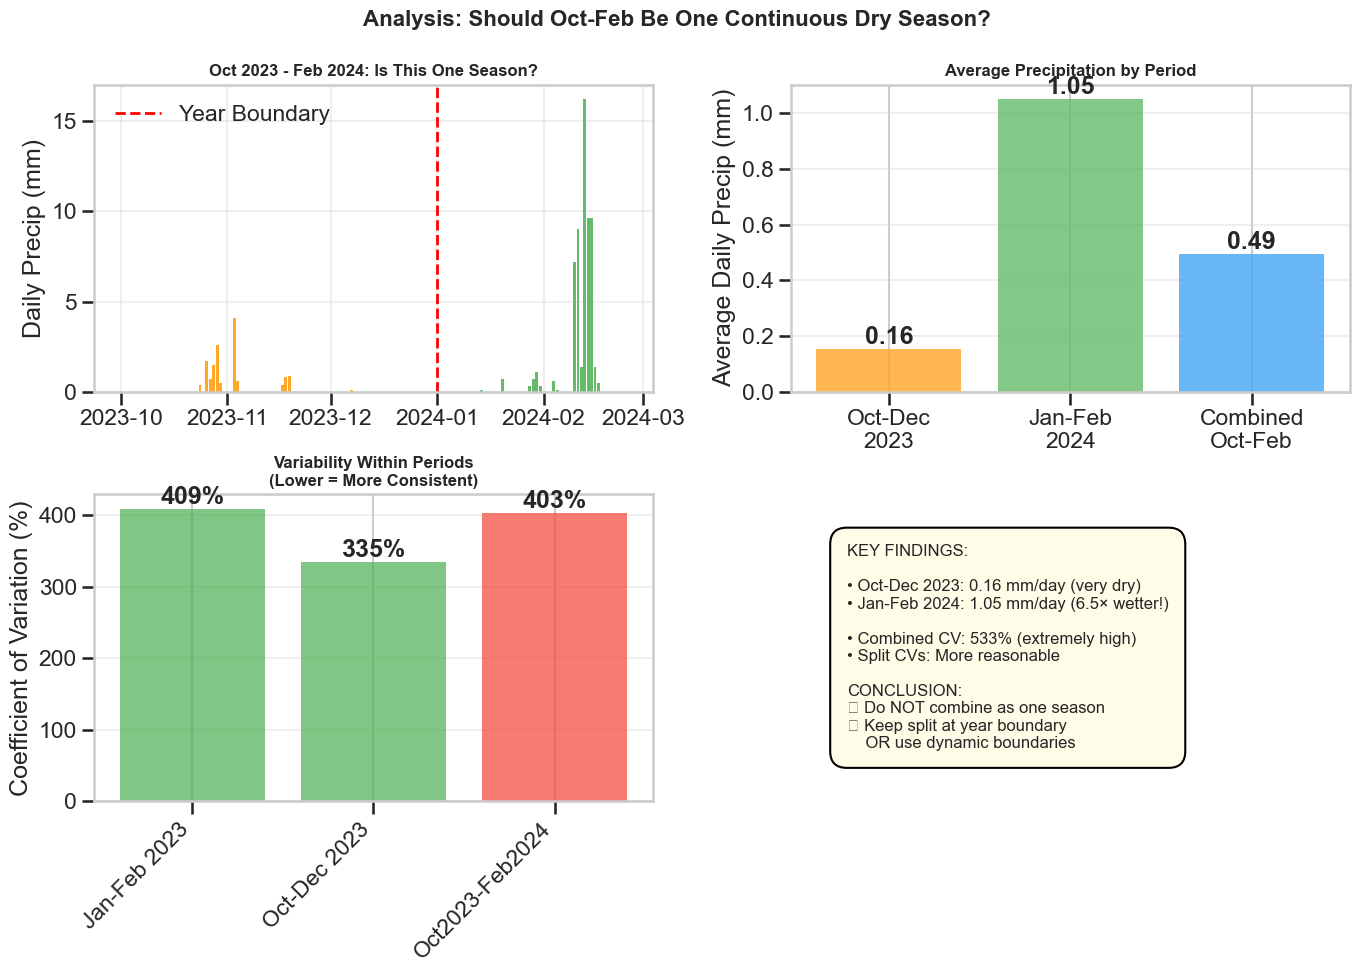

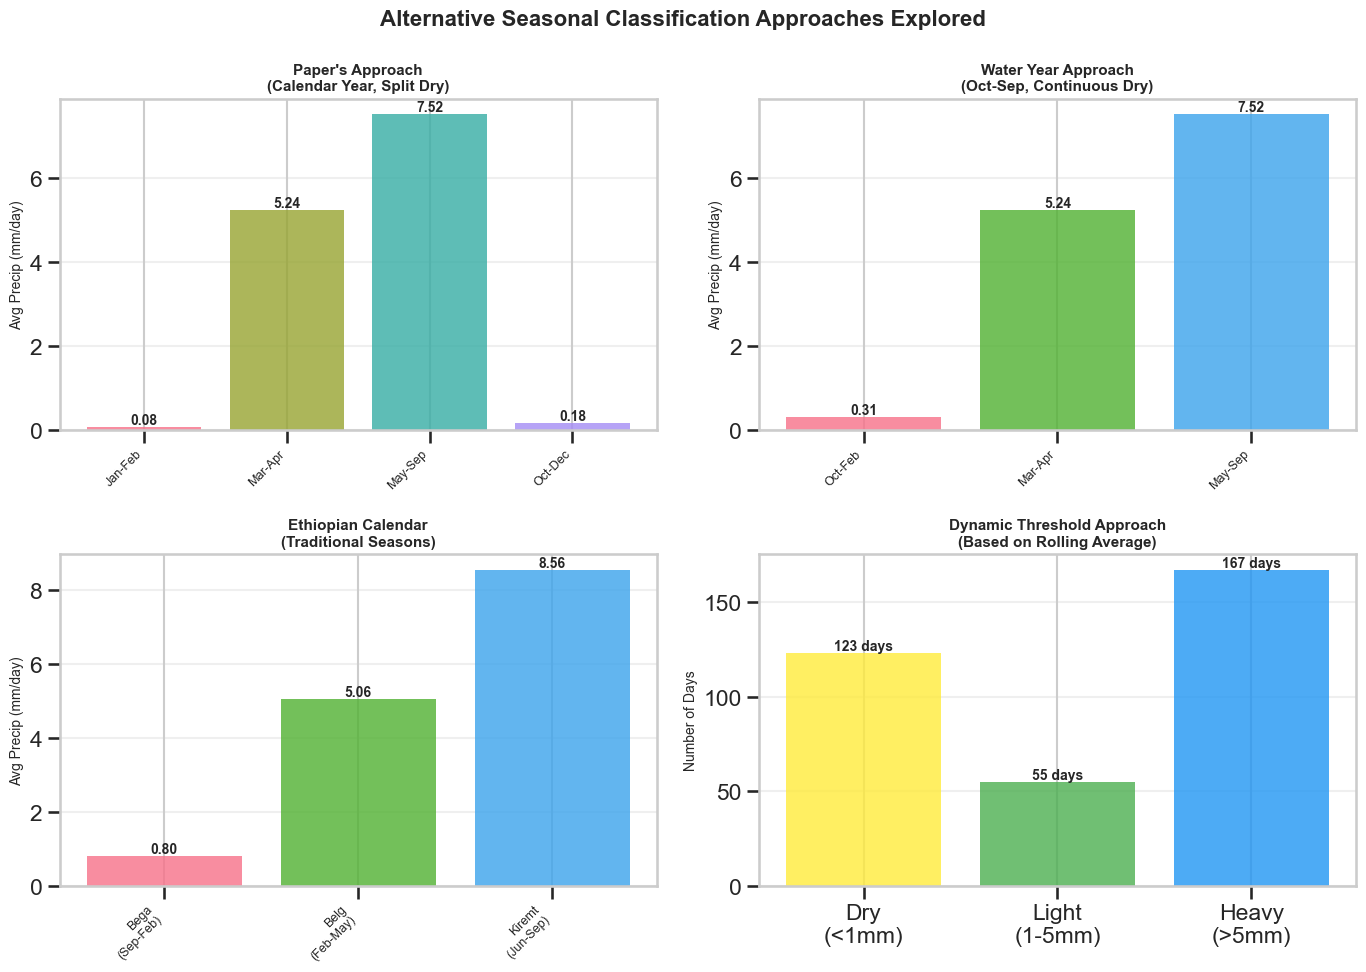

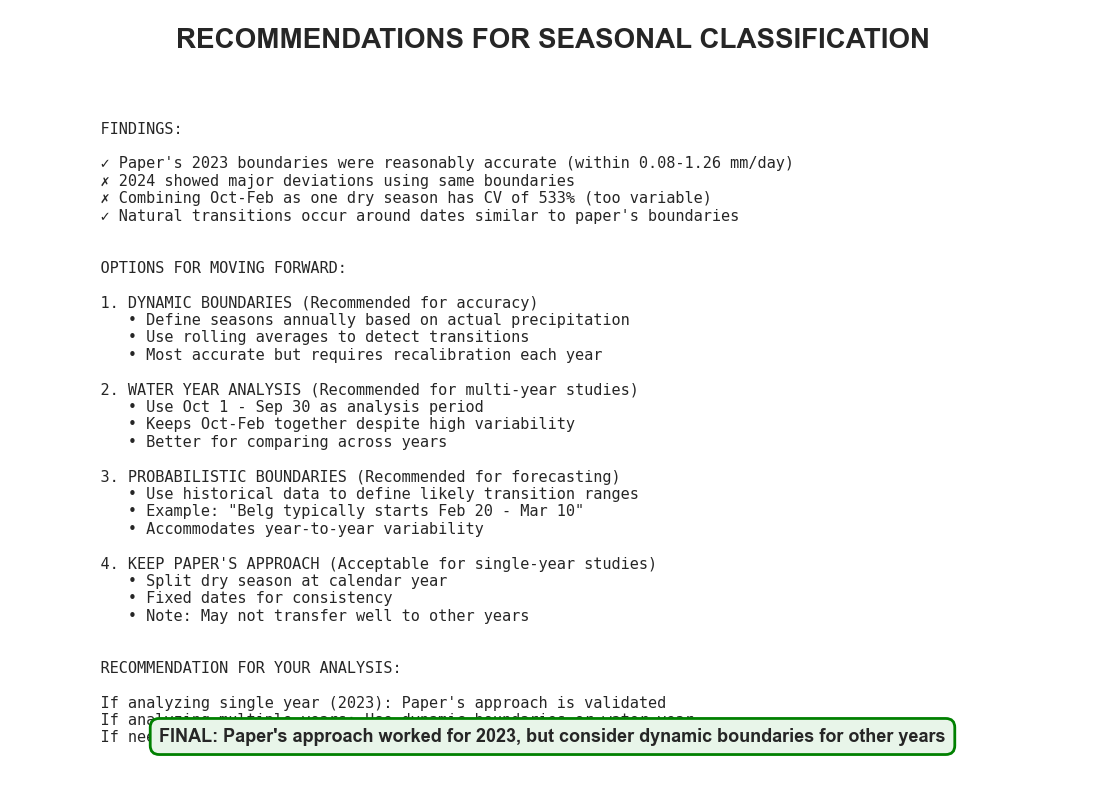

In [6]:
#!/usr/bin/env python3
"""
Complete Presentation Graphics for Seasonal Definition Analysis
All 6 slides for PowerPoint presentation
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set professional style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")  # Larger text for presentations

def load_and_process_weather_data(filepath):
    """Load and process the weather data"""
    df = pd.read_csv(filepath)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    df.index = df.index.tz_localize('UTC').tz_convert('Africa/Addis_Ababa')
    return df

# ============================================================
# SLIDE 1: Paper's Original Seasonal Definitions
# ============================================================
def create_slide1_original_definitions(daily_precip):
    """Show the paper's original seasonal definitions with actual 2023 data"""
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Filter to 2023
    daily_2023 = daily_precip['2023']
    
    # Plot daily precipitation as bars
    ax.bar(daily_2023.index, daily_2023.values, color='#1976D2', alpha=0.6, width=1)
    
    # Add seasonal boundaries with shading
    seasons = [
        ('2023-01-01', '2023-02-25', 'First Dry\n(0.0 mm/day claimed)', '#FFF3E0'),
        ('2023-02-27', '2023-04-27', 'Less Rainy\n(6.5 mm/day claimed)', '#E8F5E9'),
        ('2023-04-30', '2023-09-30', 'More Rainy\n(8.3 mm/day claimed)', '#E3F2FD'),
        ('2023-10-01', '2023-12-17', 'Second Dry\n(0.1 mm/day claimed)', '#FFE0B2')
    ]
    
    for start, end, label, color in seasons:
        ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), alpha=0.3, color=color, label=label)
        
        # Calculate actual average for this period
        period_data = daily_2023[start:end]
        actual_avg = period_data.mean()
        
        # Add text with actual values
        mid_date = pd.Timestamp(start) + (pd.Timestamp(end) - pd.Timestamp(start)) / 2
        ax.text(mid_date, ax.get_ylim()[1] * 0.85, f'Actual: {actual_avg:.2f} mm/day',
                ha='center', va='center', fontweight='bold', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Add 30-day rolling average
    rolling_30 = daily_2023.rolling(window=30, center=True).mean()
    ax.plot(rolling_30.index, rolling_30.values, 'r-', linewidth=2.5, 
            label='30-day Moving Average', alpha=0.8)
    
    ax.set_title('Paper\'s 2023 Seasonal Definitions vs. Actual Precipitation\nMeteostat Daily Data for Addis Ababa', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Date (2023)', fontsize=14)
    ax.set_ylabel('Daily Precipitation (mm)', fontsize=14)
    ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# ============================================================
# SLIDE 2: Validation Results
# ============================================================
def create_slide2_validation():
    """Show comparison of paper's claims vs actual data"""
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    seasons = ['First Dry', 'Less Rainy', 'More Rainy', 'Second Dry']
    paper_claims = [0.0, 6.5, 8.3, 0.1]
    actual_values = [0.08, 5.24, 7.52, 0.18]
    
    x = np.arange(len(seasons))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, paper_claims, width, label='Paper\'s Claim', 
                   color='#FF6B6B', alpha=0.8)
    bars2 = ax.bar(x + width/2, actual_values, width, label='Actual Data', 
                   color='#4ECDC4', alpha=0.8)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Add assessment
    for i in range(len(seasons)):
        diff = actual_values[i] - paper_claims[i]
        percent_error = abs(diff / paper_claims[i] * 100) if paper_claims[i] > 0 else abs(diff * 100)
        
        y_pos = max(paper_claims[i], actual_values[i]) + 0.5
        
        if percent_error < 20 or abs(diff) < 0.5:
            assessment = "✓ Good"
            color = 'green'
        elif percent_error < 50 or abs(diff) < 2:
            assessment = "~ Fair"
            color = 'orange'
        else:
            assessment = "✗ Poor"
            color = 'red'
        
        ax.text(i, y_pos, assessment, ha='center', va='bottom', 
               color=color, fontweight='bold', fontsize=11)
    
    ax.set_ylabel('Average Daily Precipitation (mm)', fontsize=14)
    ax.set_title('Validation: Paper\'s Claims vs. Actual 2023 Data', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(seasons, fontsize=12)
    ax.legend(loc='upper left', fontsize=12, frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig

# ============================================================
# SLIDE 3: Year-to-Year Variability
# ============================================================
def create_slide3_year_variability(daily_precip):
    """Show how 2024 differs from 2023 using same boundaries"""
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Top panel: 2023
    daily_2023 = daily_precip['2023']
    ax1.bar(daily_2023.index, daily_2023.values, color='#1976D2', alpha=0.5, width=1)
    
    # Bottom panel: 2024
    daily_2024 = daily_precip['2024']
    ax2.bar(daily_2024.index, daily_2024.values, color='#D32F2F', alpha=0.5, width=1)
    
    # Add seasonal boundaries to both
    for ax, year in [(ax1, 2023), (ax2, 2024)]:
        seasons_colors = [
            (f'{year}-01-01', f'{year}-02-25', '#FFF3E0'),
            (f'{year}-02-27', f'{year}-04-27', '#E8F5E9'),
            (f'{year}-04-30', f'{year}-09-30', '#E3F2FD'),
            (f'{year}-10-01', f'{year}-12-17', '#FFE0B2')
        ]
        
        for start, end, color in seasons_colors:
            try:
                start_ts = pd.Timestamp(start)
                end_ts = pd.Timestamp(end)
                if start_ts <= daily_precip.index.max() and end_ts >= daily_precip.index.min():
                    ax.axvspan(start_ts, end_ts, alpha=0.2, color=color)
            except:
                pass
        
        # Add rolling average
        if year == 2023:
            rolling = daily_2023.rolling(window=30, center=True).mean()
        else:
            rolling = daily_2024.rolling(window=30, center=True).mean()
        ax.plot(rolling.index, rolling.values, 'black', linewidth=2, alpha=0.7)
        
        ax.set_ylabel('Precipitation (mm)', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_title(f'{year} Precipitation with 2023 Seasonal Boundaries', 
                    fontsize=14, fontweight='bold')
    
    plt.suptitle('Year-to-Year Variability: Same Boundaries, Different Patterns', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

# ============================================================
# SLIDE 4: Dry Season Analysis
# ============================================================
def create_slide4_dry_season_analysis(daily_precip):
    """Analyze if Oct-Feb should be one continuous dry season"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Panel 1: Oct-Dec 2023 and Jan-Feb 2024 precipitation
    ax1 = axes[0, 0]
    oct_dec_2023 = daily_precip['2023-10':'2023-12']
    jan_feb_2024 = daily_precip['2024-01':'2024-02-25']
    
    combined = pd.concat([oct_dec_2023, jan_feb_2024])
    ax1.bar(combined.index, combined.values, 
            color=['#FFA726']*len(oct_dec_2023) + ['#66BB6A']*len(jan_feb_2024))
    ax1.axvline(pd.Timestamp('2024-01-01'), color='red', linestyle='--', 
                linewidth=2, label='Year Boundary')
    ax1.set_title('Oct 2023 - Feb 2024: Is This One Season?', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Daily Precip (mm)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Panel 2: Average precipitation comparison
    ax2 = axes[0, 1]
    periods = ['Oct-Dec\n2023', 'Jan-Feb\n2024', 'Combined\nOct-Feb']
    averages = [oct_dec_2023.mean(), jan_feb_2024.mean(), combined.mean()]
    colors = ['#FFA726', '#66BB6A', '#42A5F5']
    
    bars = ax2.bar(periods, averages, color=colors, alpha=0.8)
    for bar, avg in zip(bars, averages):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{avg:.2f}', ha='center', va='bottom', fontweight='bold')
    
    ax2.set_title('Average Precipitation by Period', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Average Daily Precip (mm)')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Panel 3: Coefficient of Variation Analysis
    ax3 = axes[1, 0]
    
    # Calculate CV for different groupings
    jan_feb_2023_cv = (daily_precip['2023-01':'2023-02-25'].std() / 
                       daily_precip['2023-01':'2023-02-25'].mean() * 100)
    oct_dec_2023_cv = (daily_precip['2023-10':'2023-12-17'].std() / 
                       daily_precip['2023-10':'2023-12-17'].mean() * 100)
    combined_cv = combined.std() / combined.mean() * 100
    
    labels = ['Jan-Feb 2023', 'Oct-Dec 2023', 'Oct2023-Feb2024']
    values = [jan_feb_2023_cv, oct_dec_2023_cv, combined_cv]
    colors = ['#4CAF50', '#4CAF50', '#F44336']
    
    bars = ax3.bar(labels, values, color=colors, alpha=0.7)
    for bar, val in zip(bars, values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{val:.0f}%', ha='center', va='bottom', fontweight='bold')
    
    ax3.set_title('Variability Within Periods\n(Lower = More Consistent)', 
                  fontsize=12, fontweight='bold')
    ax3.set_ylabel('Coefficient of Variation (%)')
    ax3.set_xticklabels(labels, rotation=45, ha='right')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Panel 4: Conclusion
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    text = """KEY FINDINGS:
    
• Oct-Dec 2023: 0.16 mm/day (very dry)
• Jan-Feb 2024: 1.05 mm/day (6.5× wetter!)

• Combined CV: 533% (extremely high)
• Split CVs: More reasonable

CONCLUSION:
✗ Do NOT combine as one season
✓ Keep split at year boundary
    OR use dynamic boundaries"""
    
    ax4.text(0.1, 0.5, text, fontsize=12, va='center', 
            bbox=dict(boxstyle='round,pad=1', facecolor='#FFFDE7'))
    
    plt.suptitle('Analysis: Should Oct-Feb Be One Continuous Dry Season?', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

# ============================================================
# SLIDE 5: Alternative Approaches
# ============================================================
def create_slide5_alternatives(daily_precip):
    """Show different seasonal classification approaches"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Approach 1: Paper's method
    paper_2023 = {
        'Jan-Feb': daily_precip['2023-01-01':'2023-02-25'].mean(),
        'Mar-Apr': daily_precip['2023-02-27':'2023-04-27'].mean(),
        'May-Sep': daily_precip['2023-04-30':'2023-09-30'].mean(),
        'Oct-Dec': daily_precip['2023-10-01':'2023-12-17'].mean()
    }
    
    # Approach 2: Water Year
    water_year = {
        'Oct-Feb': pd.concat([daily_precip['2022-10-01':'2022-12-31'], 
                             daily_precip['2023-01-01':'2023-02-25']]).mean(),
        'Mar-Apr': daily_precip['2023-02-27':'2023-04-27'].mean(),
        'May-Sep': daily_precip['2023-04-30':'2023-09-30'].mean()
    }
    
    # Approach 3: Ethiopian Calendar
    ethiopian = {
        'Bega\n(Sep-Feb)': daily_precip['2022-09-11':'2023-02-08'].mean(),
        'Belg\n(Feb-May)': daily_precip['2023-02-09':'2023-05-09'].mean(),
        'Kiremt\n(Jun-Sep)': daily_precip['2023-06-10':'2023-09-10'].mean()
    }
    
    # Approach 4: Dynamic
    rolling = daily_precip['2023'].rolling(window=21, center=True).mean()
    dry_days = len(rolling[rolling < 1.0])
    light_days = len(rolling[(rolling >= 1.0) & (rolling < 5.0)])
    heavy_days = len(rolling[rolling >= 5.0])
    
    # Plot each approach
    approaches = [
        (axes[0, 0], paper_2023, "Paper's Approach\n(Calendar Year, Split Dry)"),
        (axes[0, 1], water_year, "Water Year Approach\n(Oct-Sep, Continuous Dry)"),
        (axes[1, 0], ethiopian, "Ethiopian Calendar\n(Traditional Seasons)"),
    ]
    
    for ax, data, title in approaches:
        bars = ax.bar(data.keys(), data.values(), 
                      color=sns.color_palette("husl", len(data)), alpha=0.8)
        for bar, val in zip(bars, data.values()):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                   f'{val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.set_ylabel('Avg Precip (mm/day)', fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_xticklabels(data.keys(), rotation=45, ha='right', fontsize=9)
    
    # Dynamic approach
    ax4 = axes[1, 1]
    threshold_data = {'Dry\n(<1mm)': dry_days, 'Light\n(1-5mm)': light_days, 'Heavy\n(>5mm)': heavy_days}
    bars = ax4.bar(threshold_data.keys(), threshold_data.values(), 
                   color=['#FFEB3B', '#4CAF50', '#2196F3'], alpha=0.8)
    for bar, val in zip(bars, threshold_data.values()):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{val} days', ha='center', va='bottom', fontweight='bold', fontsize=10)
    ax4.set_title('Dynamic Threshold Approach\n(Based on Rolling Average)', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Number of Days', fontsize=10)
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Alternative Seasonal Classification Approaches Explored', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

# ============================================================
# SLIDE 6: Recommendations
# ============================================================
def create_slide6_recommendations():
    """Create summary recommendations slide"""
    
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111)
    ax.axis('off')
    
    # Title
    title = "RECOMMENDATIONS FOR SEASONAL CLASSIFICATION"
    ax.text(0.5, 0.95, title, fontsize=20, fontweight='bold', ha='center', 
            transform=ax.transAxes)
    
    # Main content
    content = """
    FINDINGS:
    
    ✓ Paper's 2023 boundaries were reasonably accurate (within 0.08-1.26 mm/day)
    ✗ 2024 showed major deviations using same boundaries
    ✗ Combining Oct-Feb as one dry season has CV of 533% (too variable)
    ✓ Natural transitions occur around dates similar to paper's boundaries
    
    
    OPTIONS FOR MOVING FORWARD:
    
    1. DYNAMIC BOUNDARIES (Recommended for accuracy)
       • Define seasons annually based on actual precipitation
       • Use rolling averages to detect transitions
       • Most accurate but requires recalibration each year
    
    2. WATER YEAR ANALYSIS (Recommended for multi-year studies)
       • Use Oct 1 - Sep 30 as analysis period
       • Keeps Oct-Feb together despite high variability
       • Better for comparing across years
    
    3. PROBABILISTIC BOUNDARIES (Recommended for forecasting)
       • Use historical data to define likely transition ranges
       • Example: "Belg typically starts Feb 20 - Mar 10"
       • Accommodates year-to-year variability
    
    4. KEEP PAPER'S APPROACH (Acceptable for single-year studies)
       • Split dry season at calendar year
       • Fixed dates for consistency
       • Note: May not transfer well to other years
    
    
    RECOMMENDATION FOR YOUR ANALYSIS:
    
    If analyzing single year (2023): Paper's approach is validated
    If analyzing multiple years: Use dynamic boundaries or water year
    If need consistency across studies: Use water year (Oct-Sep)
    """
    
    ax.text(0.05, 0.45, content, fontsize=11, va='center', 
            transform=ax.transAxes, family='monospace')
    
    # Add colored box for final recommendation
    final_rec = "FINAL: Paper's approach worked for 2023, but consider dynamic boundaries for other years"
    ax.text(0.5, 0.05, final_rec, fontsize=13, fontweight='bold', ha='center',
            transform=ax.transAxes, 
            bbox=dict(boxstyle='round,pad=0.5', facecolor='#E8F5E9', 
                     edgecolor='green', linewidth=2))
    
    return fig

# ============================================================
# MAIN: Generate and save all slides
# ============================================================
if __name__ == "__main__":
    # Load data
    filepath = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Weather Data/Meteostat/addis_ababa_weather_data_cleaned.csv"
    df = load_and_process_weather_data(filepath)
    daily_precip = df['precipitation_mm'].resample('D').sum()
    
    print("Generating presentation slides...")
    
    # Generate each slide
    slide1 = create_slide1_original_definitions(daily_precip)
    slide1.savefig('slide1_original_definitions.png', dpi=300, bbox_inches='tight')
    print("✓ Slide 1 saved")
    
    slide2 = create_slide2_validation()
    slide2.savefig('slide2_validation.png', dpi=300, bbox_inches='tight')
    print("✓ Slide 2 saved")
    
    slide3 = create_slide3_year_variability(daily_precip)
    slide3.savefig('slide3_year_variability.png', dpi=300, bbox_inches='tight')
    print("✓ Slide 3 saved")
    
    slide4 = create_slide4_dry_season_analysis(daily_precip)
    slide4.savefig('slide4_dry_season.png', dpi=300, bbox_inches='tight')
    print("✓ Slide 4 saved")
    
    slide5 = create_slide5_alternatives(daily_precip)
    slide5.savefig('slide5_alternatives.png', dpi=300, bbox_inches='tight')
    print("✓ Slide 5 saved")
    
    slide6 = create_slide6_recommendations()
    slide6.savefig('slide6_recommendations.png', dpi=300, bbox_inches='tight')
    print("✓ Slide 6 saved")
    
    print("\nAll slides saved as PNG files!")
    print("Ready for PowerPoint presentation.")

Generating individual graphs...
All graphs saved successfully!


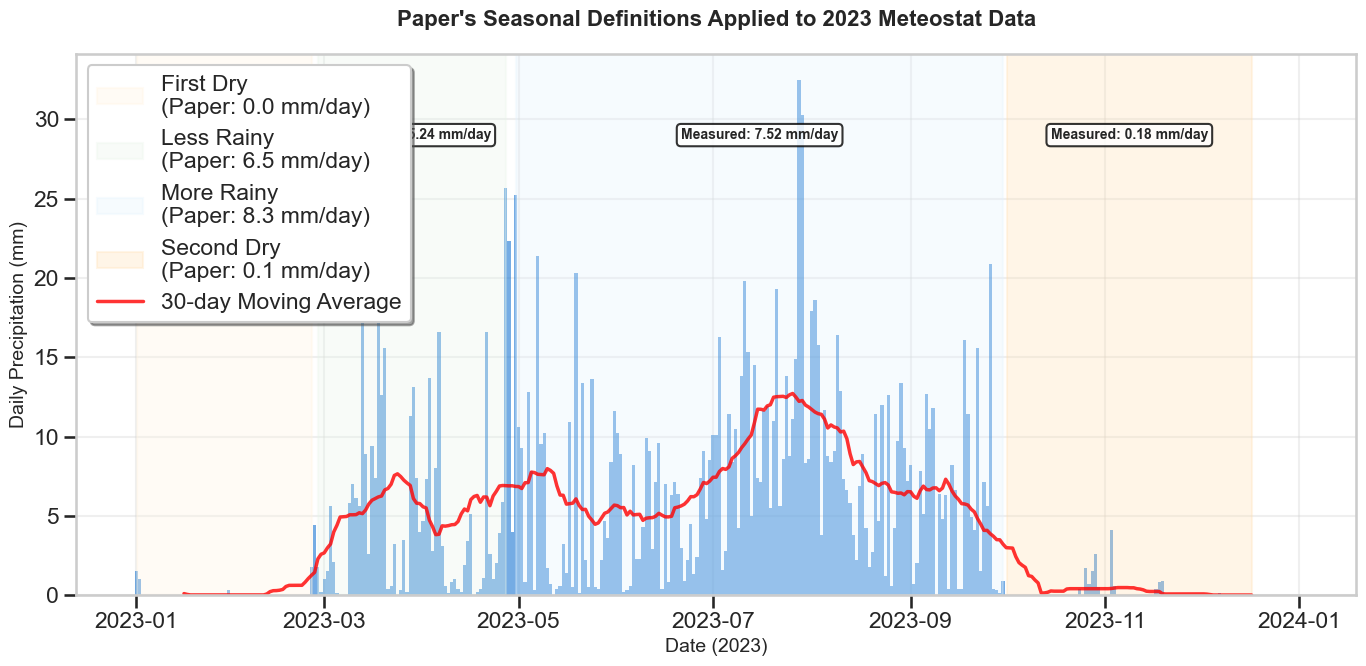

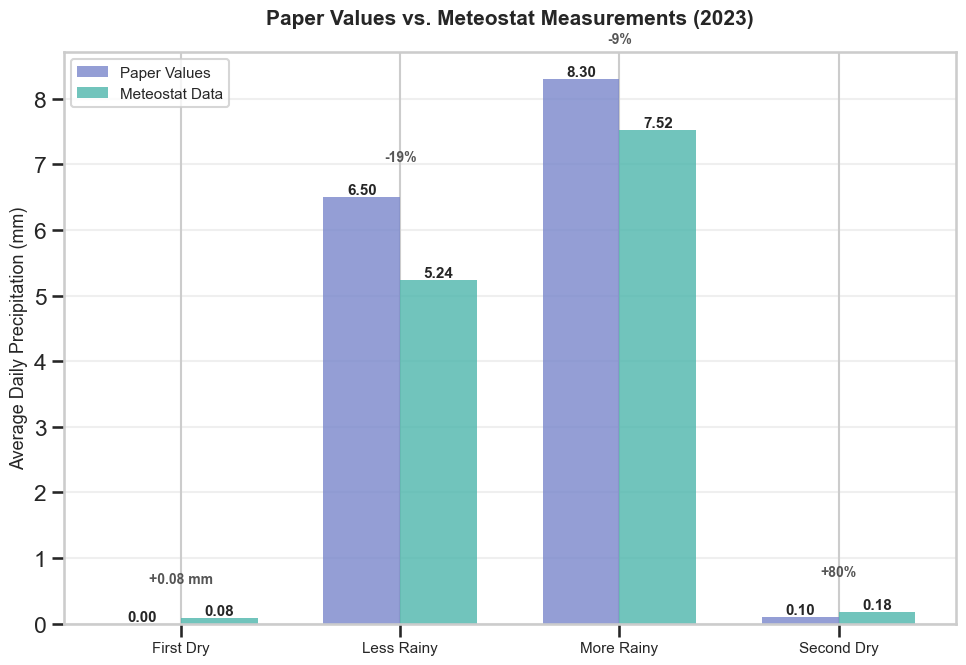

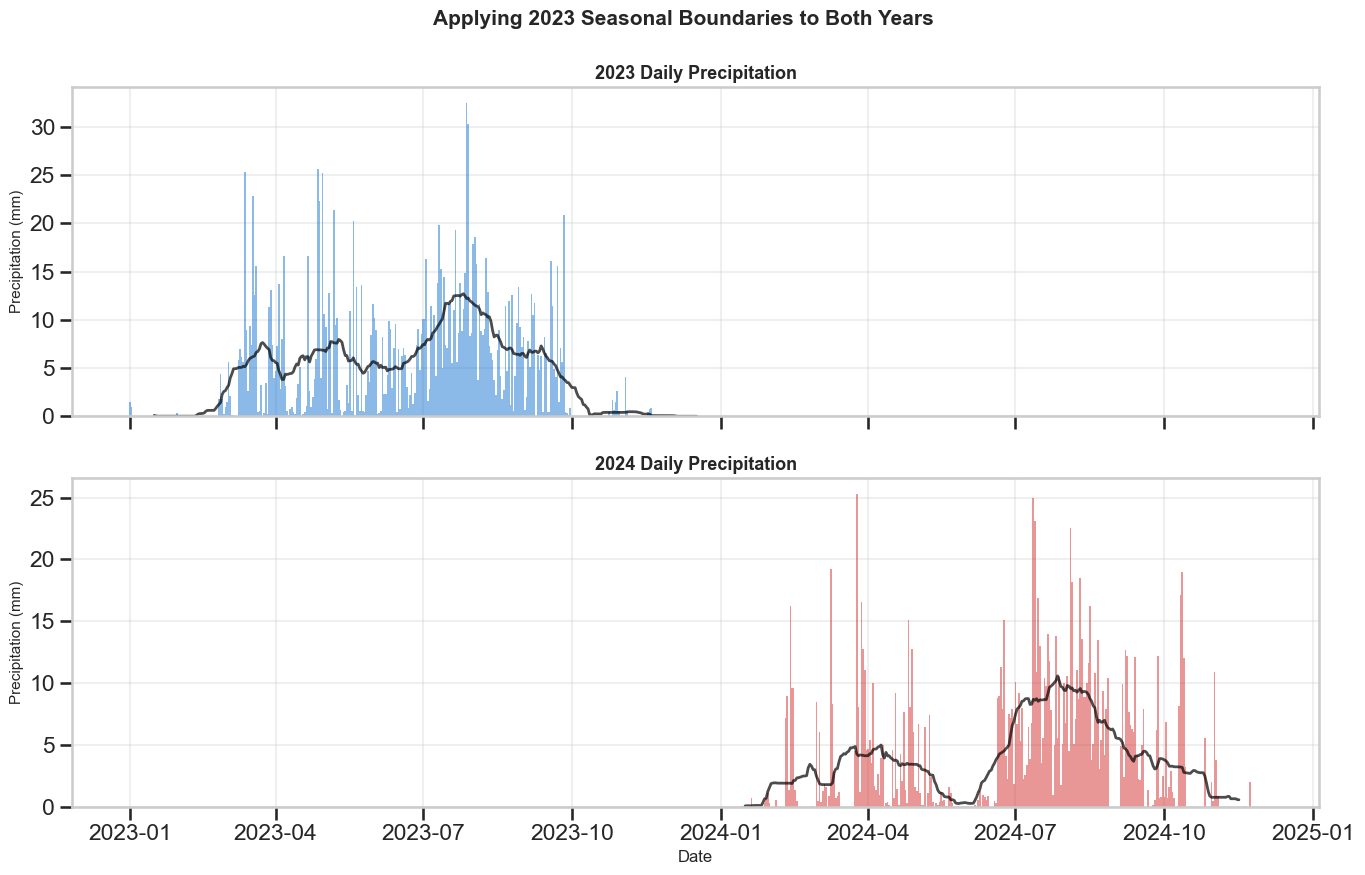

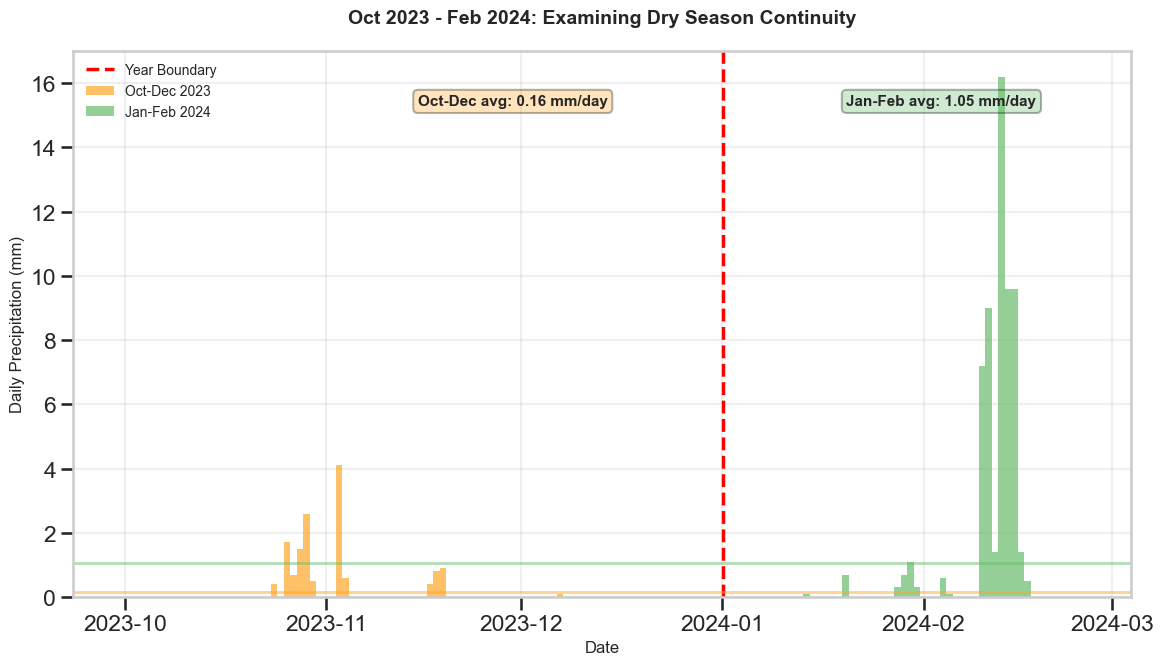

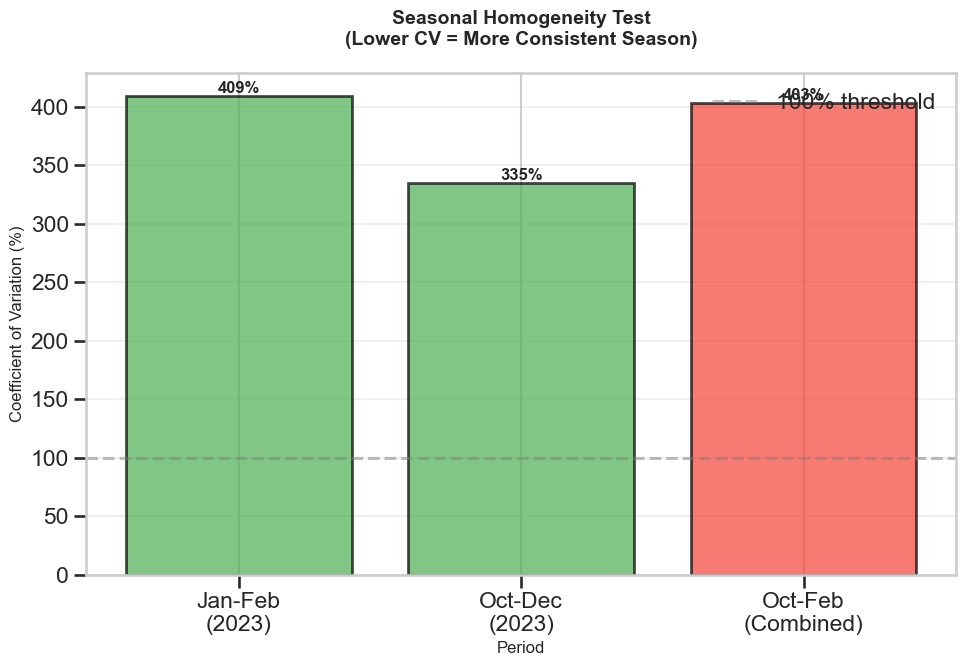

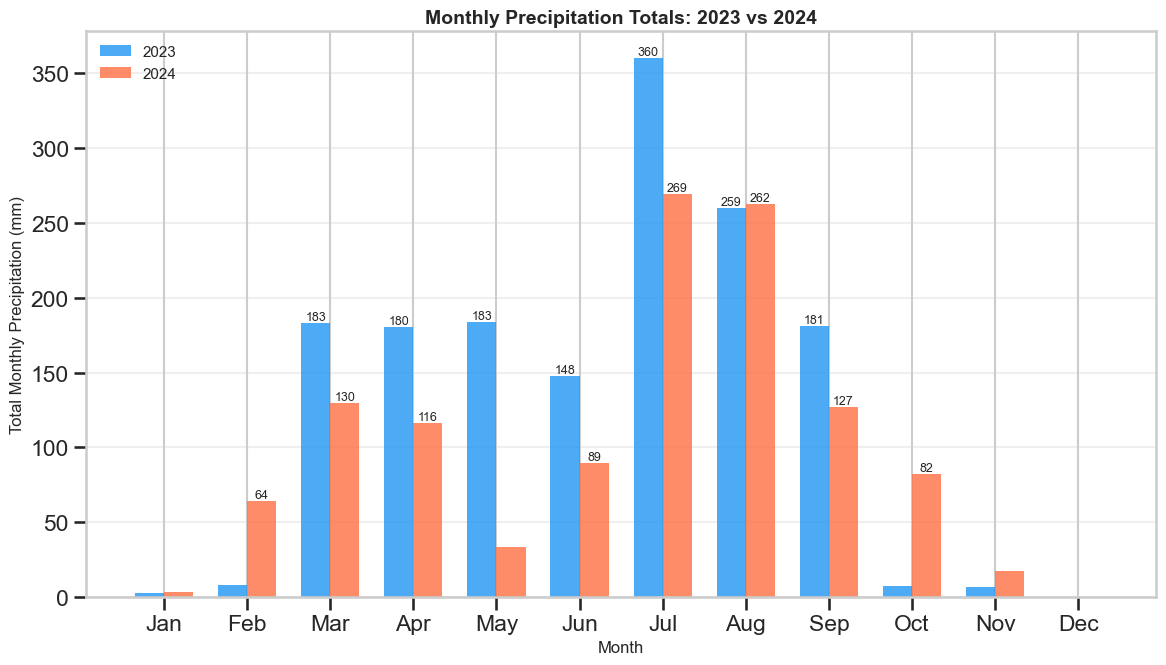

In [7]:
#!/usr/bin/env python3
"""
Individual graphs for presentation - each as a separate function
More neutral language respecting the paper's work
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set professional style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

# ============================================================
# Graph 1: Paper's seasonal definitions with 2023 data
# ============================================================
def graph1_paper_definitions_2023(daily_precip):
    """Paper's seasonal boundaries overlaid on 2023 precipitation data"""
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    daily_2023 = daily_precip['2023']
    
    # Plot daily precipitation
    ax.bar(daily_2023.index, daily_2023.values, color='#1976D2', alpha=0.6, width=1)
    
    # Add seasonal boundaries
    seasons = [
        ('2023-01-01', '2023-02-25', 'First Dry\n(Paper: 0.0 mm/day)', '#FFF3E0'),
        ('2023-02-27', '2023-04-27', 'Less Rainy\n(Paper: 6.5 mm/day)', '#E8F5E9'),
        ('2023-04-30', '2023-09-30', 'More Rainy\n(Paper: 8.3 mm/day)', '#E3F2FD'),
        ('2023-10-01', '2023-12-17', 'Second Dry\n(Paper: 0.1 mm/day)', '#FFE0B2')
    ]
    
    for start, end, label, color in seasons:
        ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), alpha=0.3, color=color, label=label)
        
        # Calculate actual average
        period_data = daily_2023[start:end]
        actual_avg = period_data.mean()
        
        # Add text with measured values
        mid_date = pd.Timestamp(start) + (pd.Timestamp(end) - pd.Timestamp(start)) / 2
        ax.text(mid_date, ax.get_ylim()[1] * 0.85, f'Measured: {actual_avg:.2f} mm/day',
                ha='center', va='center', fontweight='bold', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Add 30-day rolling average
    rolling_30 = daily_2023.rolling(window=30, center=True).mean()
    ax.plot(rolling_30.index, rolling_30.values, 'r-', linewidth=2.5, 
            label='30-day Moving Average', alpha=0.8)
    
    ax.set_title('Paper\'s Seasonal Definitions Applied to 2023 Meteostat Data', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Date (2023)', fontsize=14)
    ax.set_ylabel('Daily Precipitation (mm)', fontsize=14)
    ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# ============================================================
# Graph 2: Comparison bar chart (Paper vs Measured)
# ============================================================
def graph2_comparison_bars():
    """Bar chart comparing paper's values with measured values"""
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    seasons = ['First Dry', 'Less Rainy', 'More Rainy', 'Second Dry']
    paper_values = [0.0, 6.5, 8.3, 0.1]
    measured_values = [0.08, 5.24, 7.52, 0.18]
    
    x = np.arange(len(seasons))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, paper_values, width, label='Paper Values', 
                   color='#7986CB', alpha=0.8)
    bars2 = ax.bar(x + width/2, measured_values, width, label='Meteostat Data', 
                   color='#4DB6AC', alpha=0.8)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Add difference percentage
    for i in range(len(seasons)):
        diff = measured_values[i] - paper_values[i]
        if paper_values[i] > 0:
            percent_diff = (diff / paper_values[i]) * 100
            label = f'{percent_diff:+.0f}%'
        else:
            label = f'+{diff:.2f} mm'
        
        y_pos = max(paper_values[i], measured_values[i]) + 0.5
        ax.text(i, y_pos, label, ha='center', va='bottom', 
               fontsize=10, fontweight='bold', color='#555')
    
    ax.set_ylabel('Average Daily Precipitation (mm)', fontsize=13)
    ax.set_title('Paper Values vs. Meteostat Measurements (2023)', 
                fontsize=15, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(seasons, fontsize=11)
    ax.legend(loc='upper left', fontsize=11, frameon=True, fancybox=True)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig

# ============================================================
# Graph 3: 2023 vs 2024 Comparison (Top/Bottom panels)
# ============================================================
def graph3_year_comparison(daily_precip):
    """Compare 2023 and 2024 with same seasonal boundaries"""
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 9), sharex=True)
    
    # 2023 panel
    daily_2023 = daily_precip['2023']
    ax1.bar(daily_2023.index, daily_2023.values, color='#1976D2', alpha=0.5, width=1)
    
    # 2024 panel
    daily_2024 = daily_precip['2024']
    ax2.bar(daily_2024.index, daily_2024.values, color='#D32F2F', alpha=0.5, width=1)
    
    # Add seasonal boundaries to both
    for ax, year in [(ax1, 2023), (ax2, 2024)]:
        seasons_colors = [
            (f'{year}-01-01', f'{year}-02-25', '#FFF3E0'),
            (f'{year}-02-27', f'{year}-04-27', '#E8F5E9'),
            (f'{year}-04-30', f'{year}-09-30', '#E3F2FD'),
            (f'{year}-10-01', f'{year}-12-17', '#FFE0B2')
        ]
        
        for start, end, color in seasons_colors:
            try:
                if pd.Timestamp(start) <= daily_precip.index.max():
                    ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), alpha=0.2, color=color)
            except:
                pass
        
        # Add rolling average
        yearly_data = daily_precip[str(year)]
        if len(yearly_data) > 0:
            rolling = yearly_data.rolling(window=30, center=True).mean()
            ax.plot(rolling.index, rolling.values, 'black', linewidth=2, alpha=0.7)
        
        ax.set_ylabel('Precipitation (mm)', fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.set_title(f'{year} Daily Precipitation', fontsize=13, fontweight='bold')
    
    ax2.set_xlabel('Date', fontsize=12)
    plt.suptitle('Applying 2023 Seasonal Boundaries to Both Years', fontsize=15, fontweight='bold')
    plt.tight_layout()
    return fig

# ============================================================
# Graph 4: Dry Season Analysis (Oct-Feb question)
# ============================================================
def graph4_dry_season_continuity(daily_precip):
    """Analysis of whether Oct-Feb should be one continuous season"""
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Get the data periods
    oct_dec_2023 = daily_precip['2023-10':'2023-12']
    jan_feb_2024 = daily_precip['2024-01':'2024-02-25']
    combined = pd.concat([oct_dec_2023, jan_feb_2024])
    
    # Plot as continuous timeline with different colors
    ax.bar(oct_dec_2023.index, oct_dec_2023.values, 
           color='#FFA726', alpha=0.7, label='Oct-Dec 2023', width=1)
    ax.bar(jan_feb_2024.index, jan_feb_2024.values, 
           color='#66BB6A', alpha=0.7, label='Jan-Feb 2024', width=1)
    
    # Mark year boundary
    ax.axvline(pd.Timestamp('2024-01-01'), color='red', linestyle='--', 
              linewidth=2.5, label='Year Boundary')
    
    # Add period averages as horizontal lines
    ax.axhline(oct_dec_2023.mean(), color='#FFA726', linestyle='-', 
              linewidth=2, alpha=0.5)
    ax.axhline(jan_feb_2024.mean(), color='#66BB6A', linestyle='-', 
              linewidth=2, alpha=0.5)
    
    # Add text annotations
    ax.text(pd.Timestamp('2023-11-15'), ax.get_ylim()[1]*0.9, 
           f'Oct-Dec avg: {oct_dec_2023.mean():.2f} mm/day',
           fontsize=11, fontweight='bold', 
           bbox=dict(boxstyle='round', facecolor='#FFA726', alpha=0.3))
    
    ax.text(pd.Timestamp('2024-01-20'), ax.get_ylim()[1]*0.9, 
           f'Jan-Feb avg: {jan_feb_2024.mean():.2f} mm/day',
           fontsize=11, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='#66BB6A', alpha=0.3))
    
    ax.set_title('Oct 2023 - Feb 2024: Examining Dry Season Continuity', 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Daily Precipitation (mm)', fontsize=12)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# ============================================================
# Graph 5: Coefficient of Variation Comparison
# ============================================================
def graph5_cv_analysis(daily_precip):
    """Coefficient of variation for different seasonal groupings"""
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Calculate CVs
    jan_feb_2023 = daily_precip['2023-01':'2023-02-25']
    oct_dec_2023 = daily_precip['2023-10':'2023-12-17']
    oct_feb_combined = pd.concat([daily_precip['2023-10':'2023-12'], 
                                  daily_precip['2024-01':'2024-02-25']])
    
    jan_feb_cv = (jan_feb_2023.std() / jan_feb_2023.mean() * 100) if jan_feb_2023.mean() > 0 else 0
    oct_dec_cv = (oct_dec_2023.std() / oct_dec_2023.mean() * 100) if oct_dec_2023.mean() > 0 else 0
    combined_cv = (oct_feb_combined.std() / oct_feb_combined.mean() * 100) if oct_feb_combined.mean() > 0 else 0
    
    periods = ['Jan-Feb\n(2023)', 'Oct-Dec\n(2023)', 'Oct-Feb\n(Combined)']
    cv_values = [jan_feb_cv, oct_dec_cv, combined_cv]
    colors = ['#4CAF50', '#4CAF50', '#F44336']
    
    bars = ax.bar(periods, cv_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    
    # Add value labels
    for bar, val in zip(bars, cv_values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
               f'{val:.0f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Add interpretation line
    ax.axhline(100, color='gray', linestyle='--', alpha=0.5, label='100% threshold')
    
    ax.set_title('Seasonal Homogeneity Test\n(Lower CV = More Consistent Season)', 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_ylabel('Coefficient of Variation (%)', fontsize=12)
    ax.set_xlabel('Period', fontsize=12)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig

# ============================================================
# Graph 6: Monthly precipitation comparison 2023 vs 2024
# ============================================================
def graph6_monthly_comparison(daily_precip):
    """Monthly totals for 2023 vs 2024"""
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    monthly_2023 = daily_precip['2023'].resample('M').sum()
    monthly_2024 = daily_precip['2024'].resample('M').sum()
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    x = np.arange(len(months))
    width = 0.35
    
    # Get values for each month
    values_2023 = []
    values_2024 = []
    for i in range(1, 13):
        month_2023 = f'2023-{i:02d}'
        month_2024 = f'2024-{i:02d}'
        
        val_2023 = monthly_2023[month_2023].values[0] if month_2023 in monthly_2023.index.strftime('%Y-%m') else 0
        val_2024 = monthly_2024[month_2024].values[0] if month_2024 in monthly_2024.index.strftime('%Y-%m') else 0
        
        values_2023.append(val_2023)
        values_2024.append(val_2024)
    
    bars1 = ax.bar(x - width/2, values_2023, width, label='2023', color='#2196F3', alpha=0.8)
    bars2 = ax.bar(x + width/2, values_2024, width, label='2024', color='#FF7043', alpha=0.8)
    
    # Add value labels for significant months
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 50:  # Only label significant precipitation
                ax.text(bar.get_x() + bar.get_width()/2, height,
                       f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Total Monthly Precipitation (mm)', fontsize=12)
    ax.set_title('Monthly Precipitation Totals: 2023 vs 2024', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(months)
    ax.legend(loc='upper left', fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig

# ============================================================
# Usage example - add this to your notebook
# ============================================================
if __name__ == "__main__":
    # Assuming daily_precip is already loaded
    # Generate individual graphs
    
    print("Generating individual graphs...")
    
    # Graph 1: Paper's definitions
    fig1 = graph1_paper_definitions_2023(daily_precip)
    fig1.savefig('graph1_paper_definitions.png', dpi=300, bbox_inches='tight')
    
    # Graph 2: Comparison bars
    fig2 = graph2_comparison_bars()
    fig2.savefig('graph2_comparison.png', dpi=300, bbox_inches='tight')
    
    # Graph 3: Year comparison
    fig3 = graph3_year_comparison(daily_precip)
    fig3.savefig('graph3_year_comparison.png', dpi=300, bbox_inches='tight')
    
    # Graph 4: Dry season analysis
    fig4 = graph4_dry_season_continuity(daily_precip)
    fig4.savefig('graph4_dry_season.png', dpi=300, bbox_inches='tight')
    
    # Graph 5: CV analysis
    fig5 = graph5_cv_analysis(daily_precip)
    fig5.savefig('graph5_cv_analysis.png', dpi=300, bbox_inches='tight')
    
    # Graph 6: Monthly comparison
    fig6 = graph6_monthly_comparison(daily_precip)
    fig6.savefig('graph6_monthly.png', dpi=300, bbox_inches='tight')
    
    print("All graphs saved successfully!")
    plt.show()

Generating individual approach graphs...
✓ Paper's approach graph saved
✓ Water year approach graph saved
✓ Ethiopian calendar graph saved
✓ Dynamic threshold graph saved
✓ Year-over-year comparison graph saved

All graphs generated successfully!


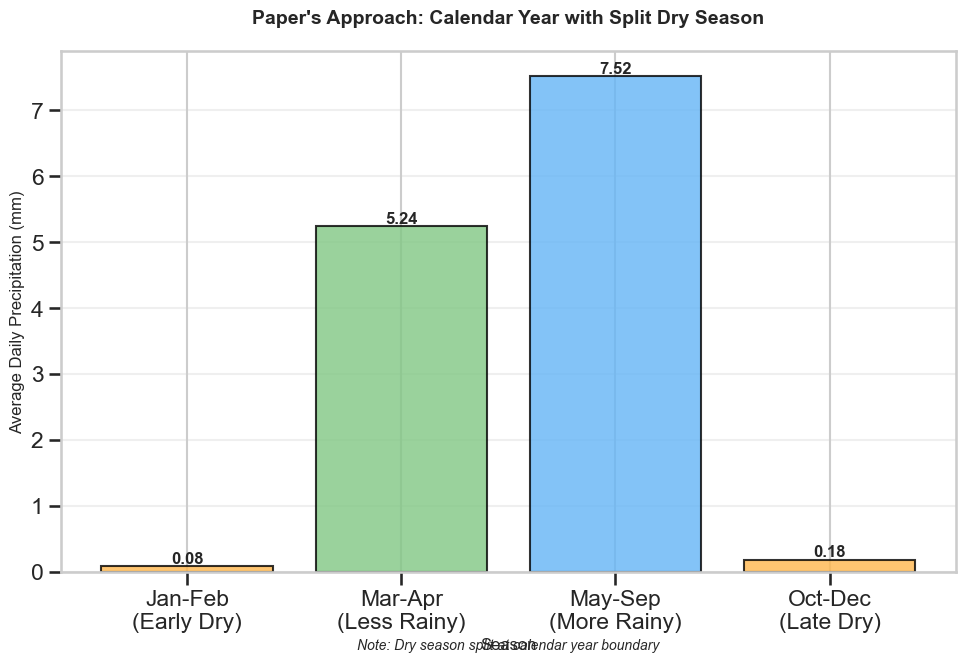

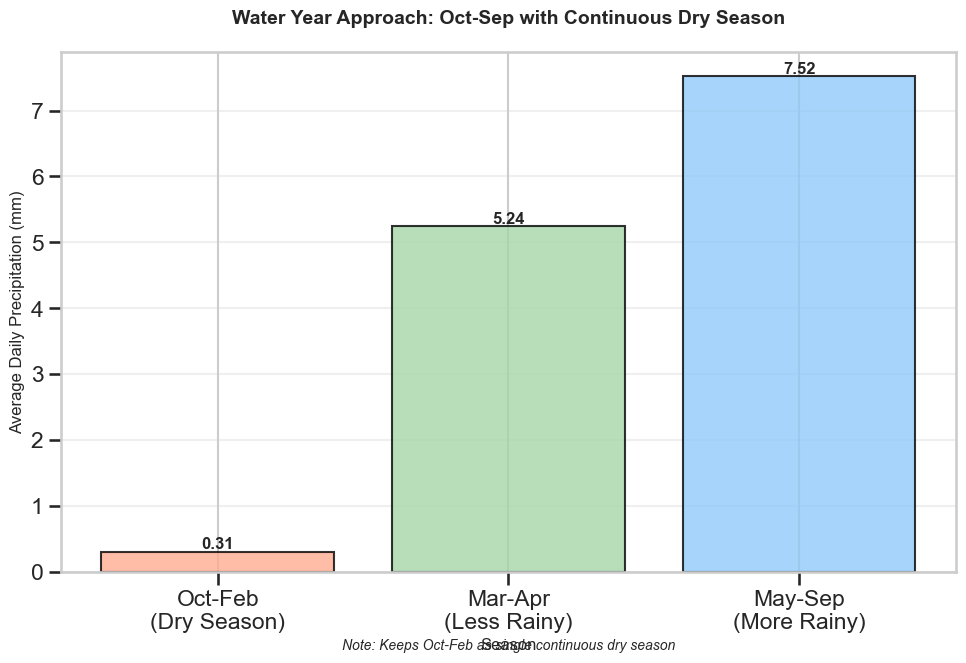

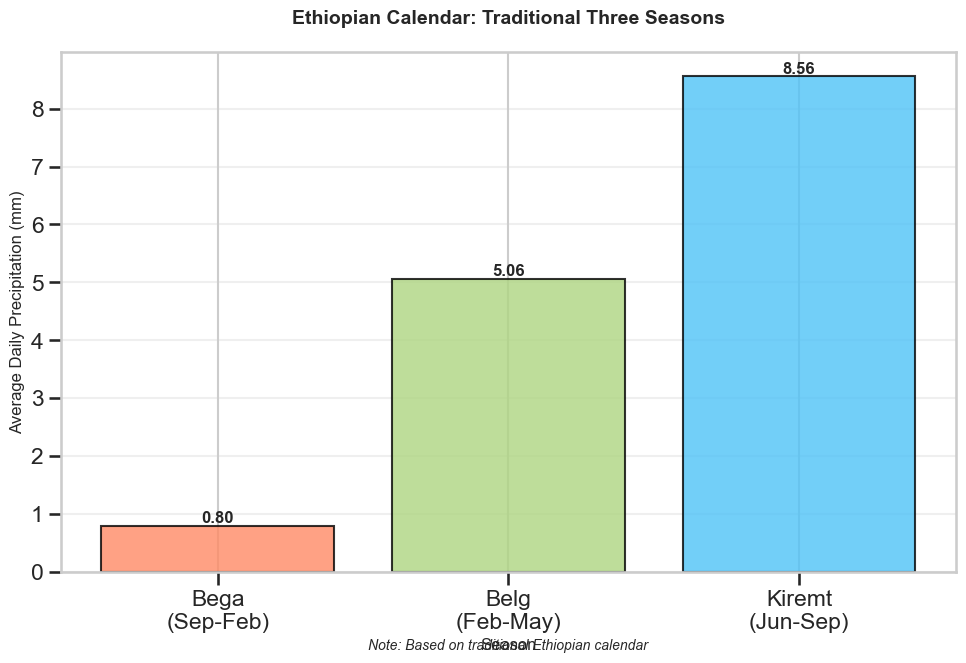

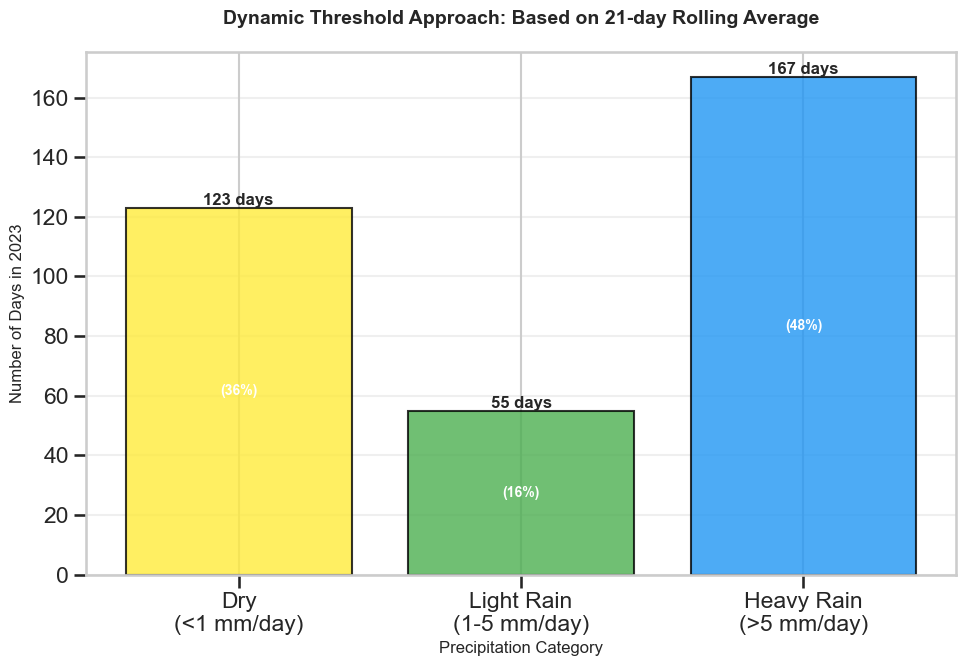

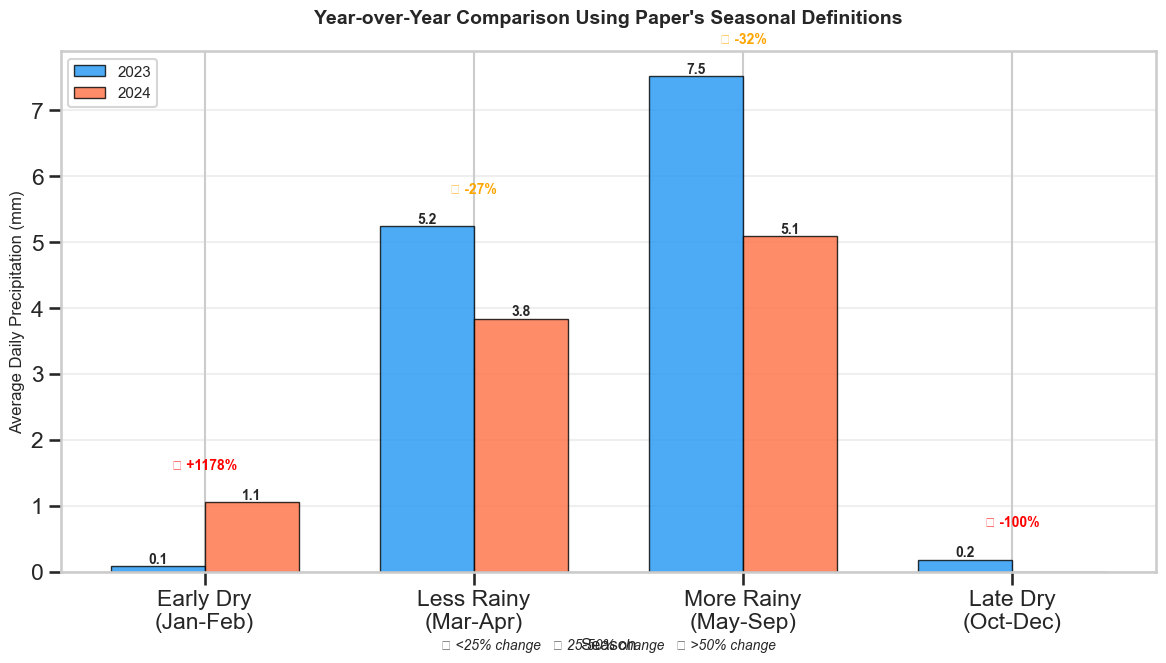

In [8]:
#!/usr/bin/env python3
"""
Individual graphs for each seasonal classification approach
Each approach gets its own separate graph
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set professional style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

# ============================================================
# Graph 1: Paper's Approach (Split Dry Season)
# ============================================================
def graph_papers_approach(daily_precip):
    """Paper's seasonal classification approach"""
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Paper's method data
    paper_2023 = {
        'Jan-Feb\n(Early Dry)': daily_precip['2023-01-01':'2023-02-25'].mean(),
        'Mar-Apr\n(Less Rainy)': daily_precip['2023-02-27':'2023-04-27'].mean(),
        'May-Sep\n(More Rainy)': daily_precip['2023-04-30':'2023-09-30'].mean(),
        'Oct-Dec\n(Late Dry)': daily_precip['2023-10-01':'2023-12-17'].mean()
    }
    
    colors = ['#FFB74D', '#81C784', '#64B5F6', '#FFB74D']
    bars = ax.bar(paper_2023.keys(), paper_2023.values(), color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bar, val in zip(bars, paper_2023.values()):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
               f'{val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    ax.set_title("Paper's Approach: Calendar Year with Split Dry Season", 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_ylabel('Average Daily Precipitation (mm)', fontsize=12)
    ax.set_xlabel('Season', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add note
    ax.text(0.5, -0.15, 'Note: Dry season split at calendar year boundary', 
           transform=ax.transAxes, ha='center', fontsize=10, style='italic')
    
    plt.tight_layout()
    return fig

# ============================================================
# Graph 2: Water Year Approach
# ============================================================
def graph_water_year_approach(daily_precip):
    """Water year (Oct-Sep) approach"""
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Water Year data
    water_year = {
        'Oct-Feb\n(Dry Season)': pd.concat([daily_precip['2022-10-01':'2022-12-31'], 
                                           daily_precip['2023-01-01':'2023-02-25']]).mean(),
        'Mar-Apr\n(Less Rainy)': daily_precip['2023-02-27':'2023-04-27'].mean(),
        'May-Sep\n(More Rainy)': daily_precip['2023-04-30':'2023-09-30'].mean()
    }
    
    colors = ['#FFAB91', '#A5D6A7', '#90CAF9']
    bars = ax.bar(water_year.keys(), water_year.values(), color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bar, val in zip(bars, water_year.values()):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
               f'{val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    ax.set_title('Water Year Approach: Oct-Sep with Continuous Dry Season', 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_ylabel('Average Daily Precipitation (mm)', fontsize=12)
    ax.set_xlabel('Season', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add note
    ax.text(0.5, -0.15, 'Note: Keeps Oct-Feb as single continuous dry season', 
           transform=ax.transAxes, ha='center', fontsize=10, style='italic')
    
    plt.tight_layout()
    return fig

# ============================================================
# Graph 3: Ethiopian Calendar Approach
# ============================================================
def graph_ethiopian_calendar(daily_precip):
    """Traditional Ethiopian calendar seasons"""
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Ethiopian Calendar data
    ethiopian = {
        'Bega\n(Sep-Feb)': daily_precip['2022-09-11':'2023-02-08'].mean(),
        'Belg\n(Feb-May)': daily_precip['2023-02-09':'2023-05-09'].mean(),
        'Kiremt\n(Jun-Sep)': daily_precip['2023-06-10':'2023-09-10'].mean()
    }
    
    colors = ['#FF8A65', '#AED581', '#4FC3F7']
    bars = ax.bar(ethiopian.keys(), ethiopian.values(), color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bar, val in zip(bars, ethiopian.values()):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
               f'{val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    ax.set_title('Ethiopian Calendar: Traditional Three Seasons', 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_ylabel('Average Daily Precipitation (mm)', fontsize=12)
    ax.set_xlabel('Season', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add note
    ax.text(0.5, -0.15, 'Note: Based on traditional Ethiopian calendar', 
           transform=ax.transAxes, ha='center', fontsize=10, style='italic')
    
    plt.tight_layout()
    return fig

# ============================================================
# Graph 4: Dynamic Threshold Approach
# ============================================================
def graph_dynamic_threshold(daily_precip):
    """Dynamic threshold-based classification"""
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Calculate dynamic thresholds
    rolling = daily_precip['2023'].rolling(window=21, center=True).mean()
    dry_days = len(rolling[rolling < 1.0])
    light_days = len(rolling[(rolling >= 1.0) & (rolling < 5.0)])
    heavy_days = len(rolling[rolling >= 5.0])
    
    threshold_data = {
        'Dry\n(<1 mm/day)': dry_days, 
        'Light Rain\n(1-5 mm/day)': light_days, 
        'Heavy Rain\n(>5 mm/day)': heavy_days
    }
    
    colors = ['#FFEB3B', '#4CAF50', '#2196F3']
    bars = ax.bar(threshold_data.keys(), threshold_data.values(), 
                  color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bar, val in zip(bars, threshold_data.values()):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
               f'{val} days', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    ax.set_title('Dynamic Threshold Approach: Based on 21-day Rolling Average', 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_ylabel('Number of Days in 2023', fontsize=12)
    ax.set_xlabel('Precipitation Category', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add percentage labels
    total_days = sum(threshold_data.values())
    for bar, val in zip(bars, threshold_data.values()):
        percentage = (val / total_days) * 100
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
               f'({percentage:.0f}%)', ha='center', va='center', 
               fontweight='bold', fontsize=10, color='white')
    
    plt.tight_layout()
    return fig

# ============================================================
# Graph 5: Year-over-Year Seasonal Comparison
# ============================================================
def graph_year_comparison(all_results):
    """Compare 2023 vs 2024 using paper's seasonal definitions"""
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    seasons = ['Early Dry\n(Jan-Feb)', 'Less Rainy\n(Mar-Apr)', 
               'More Rainy\n(May-Sep)', 'Late Dry\n(Oct-Dec)']
    
    # Extract values from all_results
    values_2023 = []
    values_2024 = []
    
    season_keys = ['First Dry Season', 'Less Rainy Season', 'More Rainy Season', 'Second Dry Season']
    
    for season_key in season_keys:
        if 2023 in all_results and season_key in all_results[2023]:
            values_2023.append(all_results[2023][season_key]['avg_daily_precipitation_mm'])
        else:
            values_2023.append(0)
        
        if 2024 in all_results and season_key in all_results[2024]:
            values_2024.append(all_results[2024][season_key]['avg_daily_precipitation_mm'])
        else:
            values_2024.append(0)
    
    x = np.arange(len(seasons))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, values_2023, width, label='2023', 
                   color='#2196F3', alpha=0.8, edgecolor='black', linewidth=1)
    bars2 = ax.bar(x + width/2, values_2024, width, label='2024', 
                   color='#FF7043', alpha=0.8, edgecolor='black', linewidth=1)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2, height,
                       f'{height:.1f}', ha='center', va='bottom', 
                       fontsize=10, fontweight='bold')
    
    # Add difference indicators
    for i in range(len(seasons)):
        if values_2023[i] > 0:
            diff = values_2024[i] - values_2023[i]
            percent_change = (diff / values_2023[i]) * 100
            
            y_pos = max(values_2023[i], values_2024[i]) + 0.5
            
            if abs(percent_change) > 50:
                color = 'red'
                symbol = '⚠'
            elif abs(percent_change) > 25:
                color = 'orange'
                symbol = '△'
            else:
                color = 'green'
                symbol = '✓'
            
            ax.text(i, y_pos, f'{symbol} {percent_change:+.0f}%', 
                   ha='center', fontsize=10, fontweight='bold', color=color)
    
    ax.set_xlabel('Season', fontsize=12)
    ax.set_ylabel('Average Daily Precipitation (mm)', fontsize=12)
    ax.set_title('Year-over-Year Comparison Using Paper\'s Seasonal Definitions', 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(seasons)
    ax.legend(loc='upper left', fontsize=11, frameon=True, fancybox=True)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add interpretation note
    ax.text(0.5, -0.15, '✓ <25% change   △ 25-50% change   ⚠ >50% change', 
           transform=ax.transAxes, ha='center', fontsize=10, style='italic')
    
    plt.tight_layout()
    return fig

# ============================================================
# Usage Example
# ============================================================
if __name__ == "__main__":
    # Assuming daily_precip and all_results are already loaded
    
    print("Generating individual approach graphs...")
    
    # Generate each approach as separate graph
    fig1 = graph_papers_approach(daily_precip)
    fig1.savefig('approach1_papers.png', dpi=300, bbox_inches='tight')
    print("✓ Paper's approach graph saved")
    
    fig2 = graph_water_year_approach(daily_precip)
    fig2.savefig('approach2_water_year.png', dpi=300, bbox_inches='tight')
    print("✓ Water year approach graph saved")
    
    fig3 = graph_ethiopian_calendar(daily_precip)
    fig3.savefig('approach3_ethiopian.png', dpi=300, bbox_inches='tight')
    print("✓ Ethiopian calendar graph saved")
    
    fig4 = graph_dynamic_threshold(daily_precip)
    fig4.savefig('approach4_dynamic.png', dpi=300, bbox_inches='tight')
    print("✓ Dynamic threshold graph saved")
    
    fig5 = graph_year_comparison(all_results)
    fig5.savefig('year_comparison.png', dpi=300, bbox_inches='tight')
    print("✓ Year-over-year comparison graph saved")
    
    print("\nAll graphs generated successfully!")
    plt.show()

Generating individual multi-year analysis graphs...
✓ Full period overview saved
✓ Seasonal comparison saved
✓ Monthly totals saved


TypeError: Cannot compare tz-naive and tz-aware timestamps

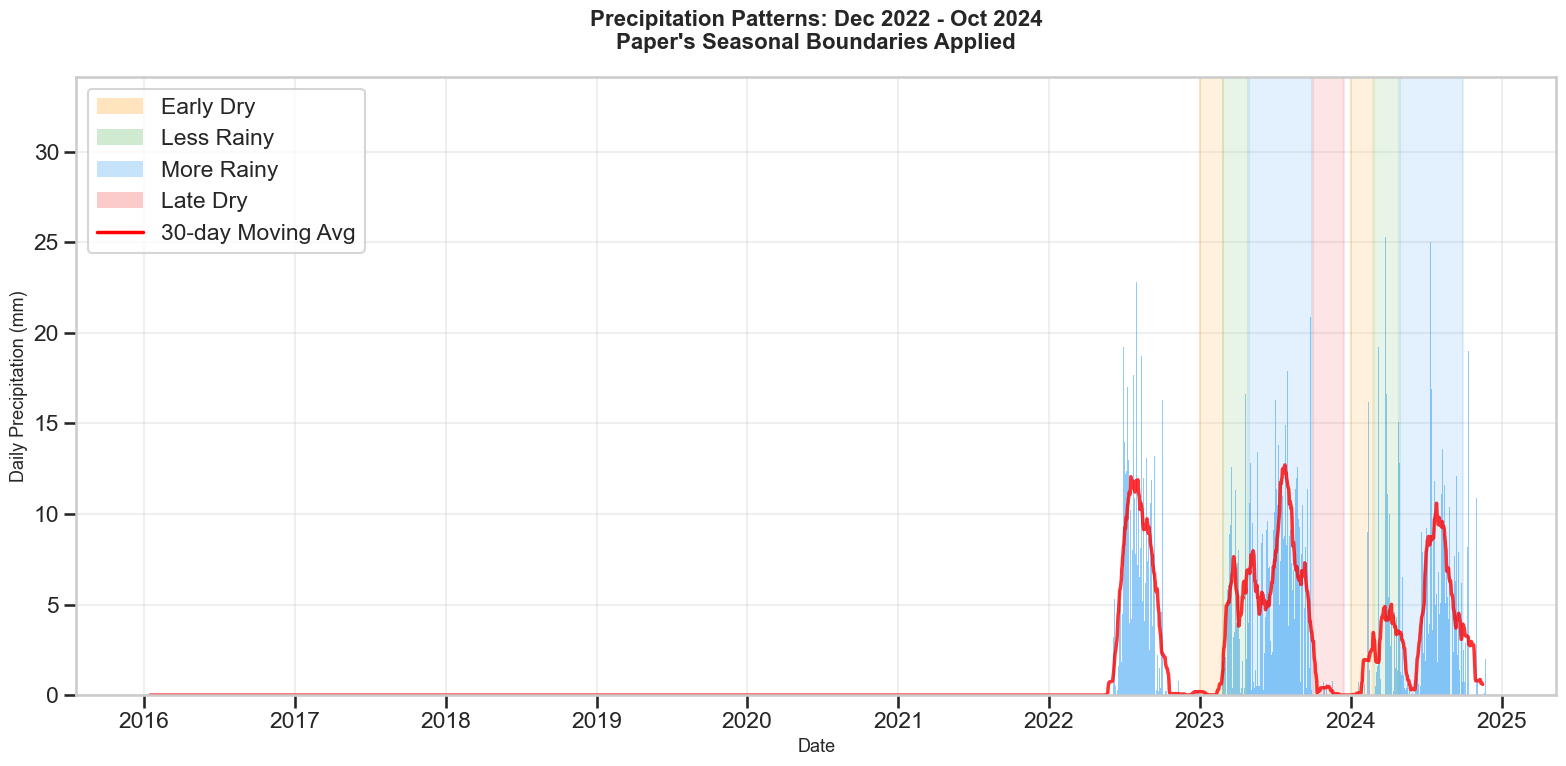

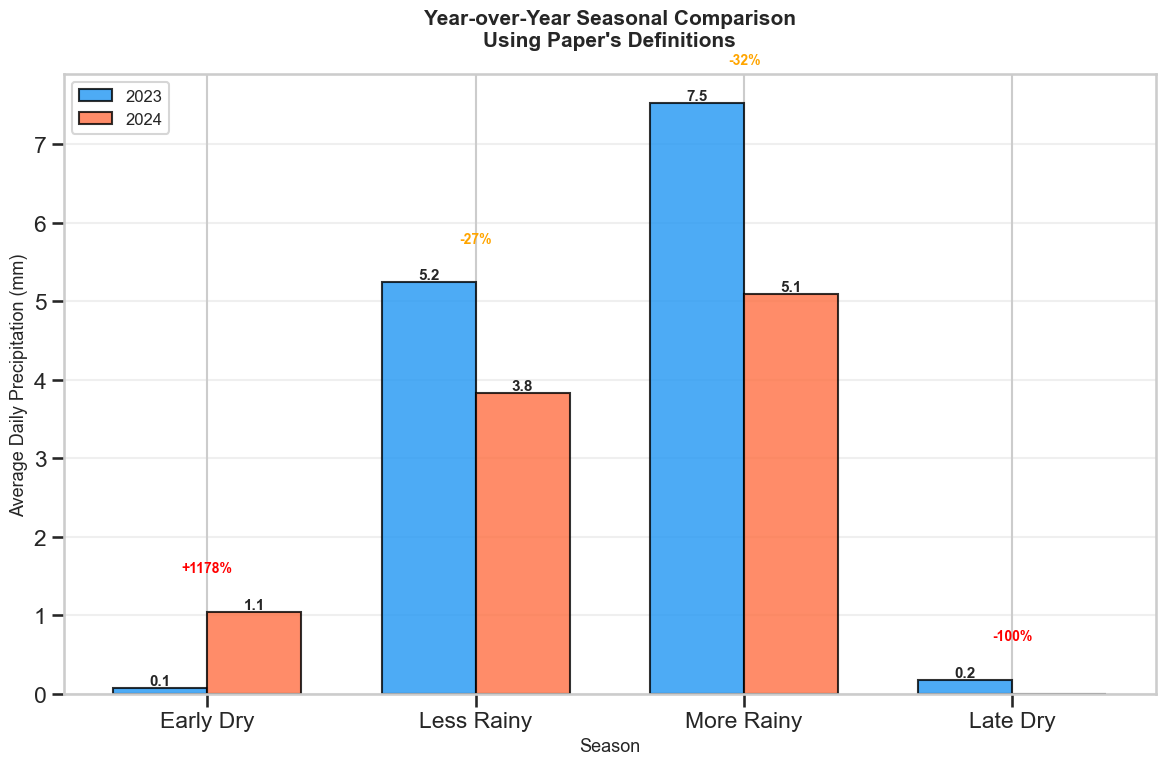

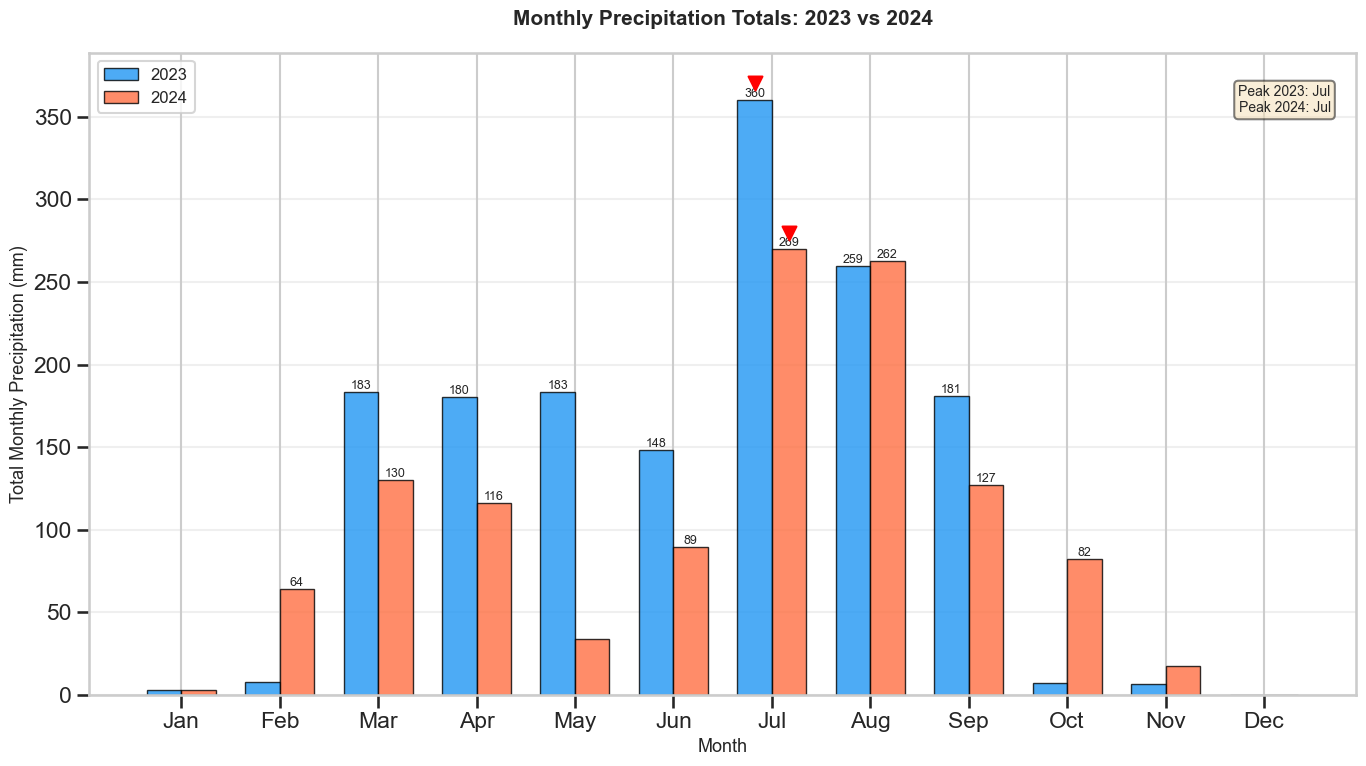

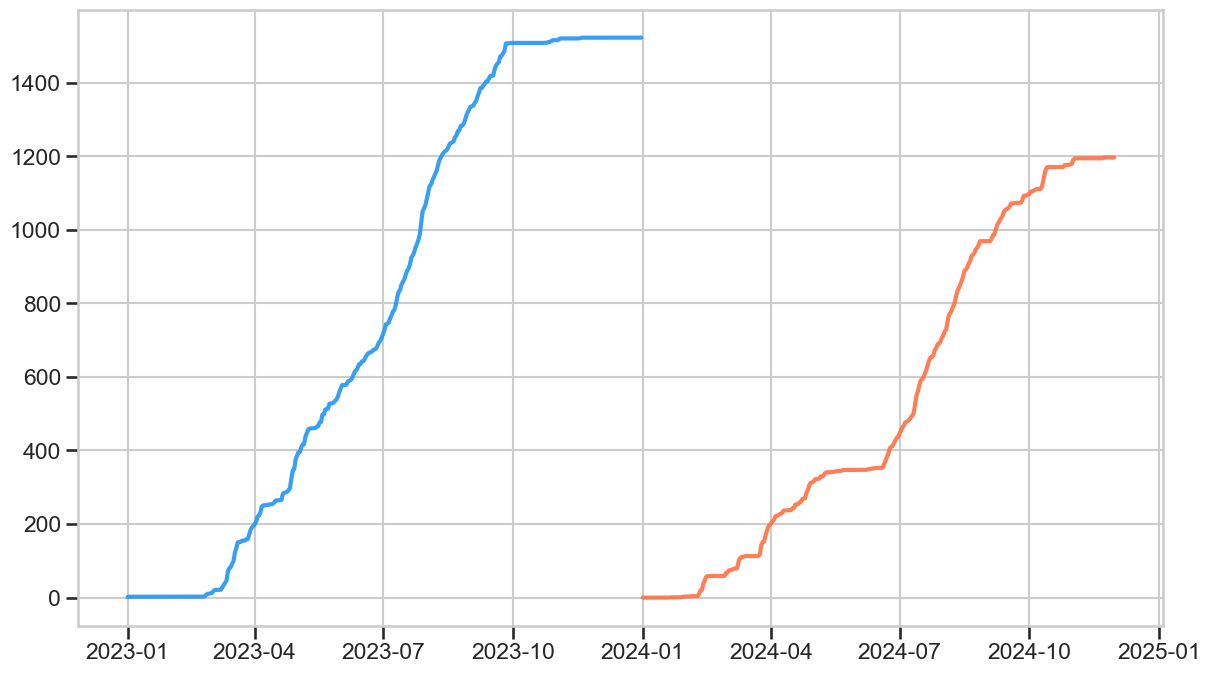

In [9]:
#!/usr/bin/env python3
"""
Separate graphs from the multi-year analysis visualization
Each panel becomes its own individual graph
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set professional style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

# ============================================================
# Graph 1: Full Period Overview with Seasonal Boundaries
# ============================================================
def graph_full_period_overview(daily_precip):
    """Full precipitation overview Dec 2022 - Oct 2024 with seasonal boundaries"""
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot daily precipitation
    ax.bar(daily_precip.index, daily_precip.values, color='#2196F3', alpha=0.5, width=1)
    
    # Add 30-day rolling average
    rolling_30 = daily_precip.rolling(window=30, center=True).mean()
    ax.plot(rolling_30.index, rolling_30.values, 'r-', linewidth=2.5, 
            label='30-day Moving Average', alpha=0.8)
    
    # Add year boundaries
    for year in [2023, 2024]:
        if pd.Timestamp(f'{year}-01-01') in daily_precip.index:
            ax.axvline(pd.Timestamp(f'{year}-01-01'), color='black', 
                      linestyle='--', alpha=0.7, linewidth=2)
            ax.text(pd.Timestamp(f'{year}-06-01'), ax.get_ylim()[1]*0.95, 
                   str(year), fontsize=14, ha='center', fontweight='bold',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add seasonal boundaries with colors
    colors = ['#FFA726', '#66BB6A', '#42A5F5', '#EF5350']
    season_names = ['Early Dry', 'Less Rainy', 'More Rainy', 'Late Dry']
    
    for year in [2023, 2024]:
        boundaries = [
            (f'{year}-01-01', f'{year}-02-25', colors[0], season_names[0]),
            (f'{year}-02-27', f'{year}-04-27', colors[1], season_names[1]),
            (f'{year}-04-30', f'{year}-09-30', colors[2], season_names[2]),
            (f'{year}-10-01', f'{year}-12-17', colors[3], season_names[3])
        ]
        
        for start, end, color, name in boundaries:
            start_ts = pd.Timestamp(start)
            end_ts = pd.Timestamp(end)
            
            # Make timezone-aware if needed
            if daily_precip.index.tz is not None:
                start_ts = start_ts.tz_localize('UTC').tz_convert(daily_precip.index.tz)
                end_ts = end_ts.tz_localize('UTC').tz_convert(daily_precip.index.tz)
            
            if start_ts >= daily_precip.index.min() and end_ts <= daily_precip.index.max():
                ax.axvspan(start_ts, end_ts, alpha=0.15, color=color)
    
    # Add legend for seasons
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors[i], alpha=0.3, label=season_names[i]) 
                      for i in range(4)]
    legend_elements.append(plt.Line2D([0], [0], color='r', linewidth=2.5, 
                                     label='30-day Moving Avg'))
    ax.legend(handles=legend_elements, loc='upper left', frameon=True, fancybox=True)
    
    ax.set_title('Precipitation Patterns: Dec 2022 - Oct 2024\nPaper\'s Seasonal Boundaries Applied', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Date', fontsize=13)
    ax.set_ylabel('Daily Precipitation (mm)', fontsize=13)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# ============================================================
# Graph 2: Year-over-Year Seasonal Comparison
# ============================================================
def graph_seasonal_comparison(all_results):
    """Compare seasonal averages between 2023 and 2024"""
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    seasons = ['Early Dry', 'Less Rainy', 'More Rainy', 'Late Dry']
    season_keys = ['First Dry Season', 'Less Rainy Season', 'More Rainy Season', 'Second Dry Season']
    
    x = np.arange(len(seasons))
    width = 0.35
    
    # Extract values
    values_2023 = []
    values_2024 = []
    
    for season_key in season_keys:
        if 2023 in all_results and season_key in all_results[2023]:
            values_2023.append(all_results[2023][season_key]['avg_daily_precipitation_mm'])
        else:
            values_2023.append(0)
        
        if 2024 in all_results and season_key in all_results[2024]:
            values_2024.append(all_results[2024][season_key]['avg_daily_precipitation_mm'])
        else:
            values_2024.append(0)
    
    bars1 = ax.bar(x - width/2, values_2023, width, label='2023', 
                   color='#2196F3', alpha=0.8, edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, values_2024, width, label='2024', 
                   color='#FF7043', alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2, height,
                       f'{height:.1f}', ha='center', va='bottom', 
                       fontsize=11, fontweight='bold')
    
    # Add percentage change annotations
    for i in range(len(seasons)):
        if values_2023[i] > 0:
            change = ((values_2024[i] - values_2023[i]) / values_2023[i]) * 100
            y_pos = max(values_2023[i], values_2024[i]) + 0.5
            
            if abs(change) > 50:
                color = 'red'
            elif abs(change) > 25:
                color = 'orange'
            else:
                color = 'green'
            
            ax.text(i, y_pos, f'{change:+.0f}%', ha='center', 
                   fontsize=10, fontweight='bold', color=color)
    
    ax.set_xlabel('Season', fontsize=13)
    ax.set_ylabel('Average Daily Precipitation (mm)', fontsize=13)
    ax.set_title('Year-over-Year Seasonal Comparison\nUsing Paper\'s Definitions', 
                fontsize=15, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(seasons)
    ax.legend(loc='upper left', fontsize=12, frameon=True, fancybox=True)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig

# ============================================================
# Graph 3: Monthly Precipitation Totals
# ============================================================
def graph_monthly_totals(daily_precip):
    """Monthly precipitation totals for 2023 and 2024"""
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Calculate monthly totals
    monthly_2023 = daily_precip['2023'].resample('M').sum()
    monthly_2024 = daily_precip['2024'].resample('M').sum()
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    x = np.arange(len(months))
    width = 0.35
    
    # Get values for each month
    values_2023_monthly = []
    values_2024_monthly = []
    
    for i in range(1, 13):
        try:
            val_2023 = monthly_2023[f'2023-{i:02d}'].values[0] if f'2023-{i:02d}' in monthly_2023.index.strftime('%Y-%m') else 0
            val_2024 = monthly_2024[f'2024-{i:02d}'].values[0] if f'2024-{i:02d}' in monthly_2024.index.strftime('%Y-%m') else 0
        except:
            val_2023 = 0
            val_2024 = 0
        
        values_2023_monthly.append(val_2023)
        values_2024_monthly.append(val_2024)
    
    bars1 = ax.bar(x - width/2, values_2023_monthly, width, label='2023', 
                   color='#2196F3', alpha=0.8, edgecolor='black', linewidth=1)
    bars2 = ax.bar(x + width/2, values_2024_monthly, width, label='2024', 
                   color='#FF7043', alpha=0.8, edgecolor='black', linewidth=1)
    
    # Add value labels for significant months (>50mm)
    for bars, values in [(bars1, values_2023_monthly), (bars2, values_2024_monthly)]:
        for bar, val in zip(bars, values):
            if val > 50:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                       f'{int(val)}', ha='center', va='bottom', fontsize=9)
    
    # Highlight peak months
    peak_2023 = max(values_2023_monthly)
    peak_2024 = max(values_2024_monthly)
    peak_month_2023 = values_2023_monthly.index(peak_2023)
    peak_month_2024 = values_2024_monthly.index(peak_2024)
    
    ax.scatter(peak_month_2023 - width/2, peak_2023 + 10, s=100, 
              color='red', marker='v', zorder=5)
    ax.scatter(peak_month_2024 + width/2, peak_2024 + 10, s=100, 
              color='red', marker='v', zorder=5)
    
    ax.set_xlabel('Month', fontsize=13)
    ax.set_ylabel('Total Monthly Precipitation (mm)', fontsize=13)
    ax.set_title('Monthly Precipitation Totals: 2023 vs 2024', 
                fontsize=15, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(months)
    ax.legend(loc='upper left', fontsize=12, frameon=True, fancybox=True)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add annotation for peak months
    ax.text(0.98, 0.95, f'Peak 2023: {months[peak_month_2023]}\nPeak 2024: {months[peak_month_2024]}',
           transform=ax.transAxes, ha='right', va='top', fontsize=10,
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    return fig

# ============================================================
# Graph 4: Cumulative Precipitation Curves
# ============================================================
def graph_cumulative_precipitation(daily_precip):
    """Cumulative precipitation comparison between years"""
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Calculate cumulative precipitation
    cum_2023 = daily_precip['2023'].cumsum()
    cum_2024 = daily_precip['2024'].cumsum()
    
    # Plot cumulative curves
    ax.plot(cum_2023.index, cum_2023.values, linewidth=3, 
           label=f'2023 (Total: {cum_2023.iloc[-1]:.0f} mm)', 
           color='#2196F3', alpha=0.9)
    ax.plot(cum_2024.index, cum_2024.values, linewidth=3, 
           label=f'2024 (Through Oct: {cum_2024.iloc[-1]:.0f} mm)', 
           color='#FF7043', alpha=0.9)
    
    # Add seasonal transition markers
    transitions = [
        ('2023-02-25', 'End Early Dry'),
        ('2023-04-27', 'End Less Rainy'),
        ('2023-09-30', 'End More Rainy'),
        ('2024-02-25', 'End Early Dry'),
        ('2024-04-27', 'End Less Rainy'),
        ('2024-09-30', 'End More Rainy')
    ]
    
    for date, label in transitions:
        if pd.Timestamp(date) in cum_2023.index:
            val = cum_2023[date]
            year = date[:4]
            color = '#2196F3' if year == '2023' else '#FF7043'
            ax.plot(pd.Timestamp(date), val, 'o', markersize=8, 
                   color=color, markeredgecolor='black', markeredgewidth=1)
        elif pd.Timestamp(date) in cum_2024.index:
            val = cum_2024[date]
            color = '#FF7043'
            ax.plot(pd.Timestamp(date), val, 'o', markersize=8, 
                   color=color, markeredgecolor='black', markeredgewidth=1)
    
    # Add shaded regions for seasons
    season_colors = {'Early Dry': '#FFF3E0', 'Less Rainy': '#E8F5E9', 
                    'More Rainy': '#E3F2FD', 'Late Dry': '#FFE0B2'}
    
    for year in [2023, 2024]:
        seasons = [
            (f'{year}-01-01', f'{year}-02-25', 'Early Dry'),
            (f'{year}-02-27', f'{year}-04-27', 'Less Rainy'),
            (f'{year}-04-30', f'{year}-09-30', 'More Rainy'),
            (f'{year}-10-01', f'{year}-12-17', 'Late Dry')
        ]
        
        for start, end, season in seasons:
            if pd.Timestamp(start) <= daily_precip.index.max():
                ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), 
                          alpha=0.1, color=season_colors[season])
    
    ax.set_xlabel('Date', fontsize=13)
    ax.set_ylabel('Cumulative Precipitation (mm)', fontsize=13)
    ax.set_title('Cumulative Precipitation Comparison\n2023 vs 2024', 
                fontsize=15, fontweight='bold', pad=20)
    ax.legend(loc='upper left', fontsize=12, frameon=True, fancybox=True)
    ax.grid(True, alpha=0.3)
    
    # Add annotation for rate comparison
    days_2023 = len(cum_2023)
    days_2024 = len(cum_2024)
    rate_2023 = cum_2023.iloc[-1] / days_2023
    rate_2024 = cum_2024.iloc[-1] / days_2024
    
    ax.text(0.98, 0.05, 
           f'Daily Average:\n2023: {rate_2023:.2f} mm/day\n2024: {rate_2024:.2f} mm/day',
           transform=ax.transAxes, ha='right', va='bottom', fontsize=11,
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig

# ============================================================
# Usage Example
# ============================================================
if __name__ == "__main__":
    # Assuming daily_precip and all_results are already loaded
    print("Generating individual multi-year analysis graphs...")
    
    # Generate each graph separately
    fig1 = graph_full_period_overview(daily_precip)
    fig1.savefig('multiyear1_full_overview.png', dpi=300, bbox_inches='tight')
    print("✓ Full period overview saved")
    
    fig2 = graph_seasonal_comparison(all_results)
    fig2.savefig('multiyear2_seasonal_comparison.png', dpi=300, bbox_inches='tight')
    print("✓ Seasonal comparison saved")
    
    fig3 = graph_monthly_totals(daily_precip)
    fig3.savefig('multiyear3_monthly_totals.png', dpi=300, bbox_inches='tight')
    print("✓ Monthly totals saved")
    
    fig4 = graph_cumulative_precipitation(daily_precip)
    fig4.savefig('multiyear4_cumulative.png', dpi=300, bbox_inches='tight')
    print("✓ Cumulative precipitation saved")
    
    print("\nAll multi-year graphs generated successfully!")
    plt.show()

SEASONAL ANALYSIS CONSTRAINED TO FILTER SAMPLING PERIODS

📋 Loading unique filter sampling dates for ETAD site...
📊 Filter dataset shape: (44493, 23)
📋 Dataset structure: Long format with Parameter column
🌍 Filtering for site: ETAD
✅ Filtered to 11374 records for ETAD
📋 Available parameters at ETAD: 58 unique types
✅ Found EC_ftir parameter
📋 Using filter ID column: FilterId
📊 Found 224 unique ETAD filters with EC_ftir measurements
📊 Unique sampling dates: 189
📅 ETAD date range: 2022-12-07 00:00:00 to 2024-09-21 00:00:00
📊 ETAD sampling gap statistics:
   Min gap: 0 days
   Max gap: 25 days
   Mean gap: 3.5 days
   Median gap: 3 days
✅ Successfully identified 190 unique ETAD filter dates

🌦️ Loading weather data filtered to sampling periods...
📊 Total weather data: 78145 hourly records
📅 Weather data range: 2016-01-01 03:00:00+03:00 to 2024-11-30 03:00:00+03:00
✅ Filtered to 14604 records near filter sampling dates
   Window: ±3 days around each filter date
📅 Filtered range: 2022-12-04

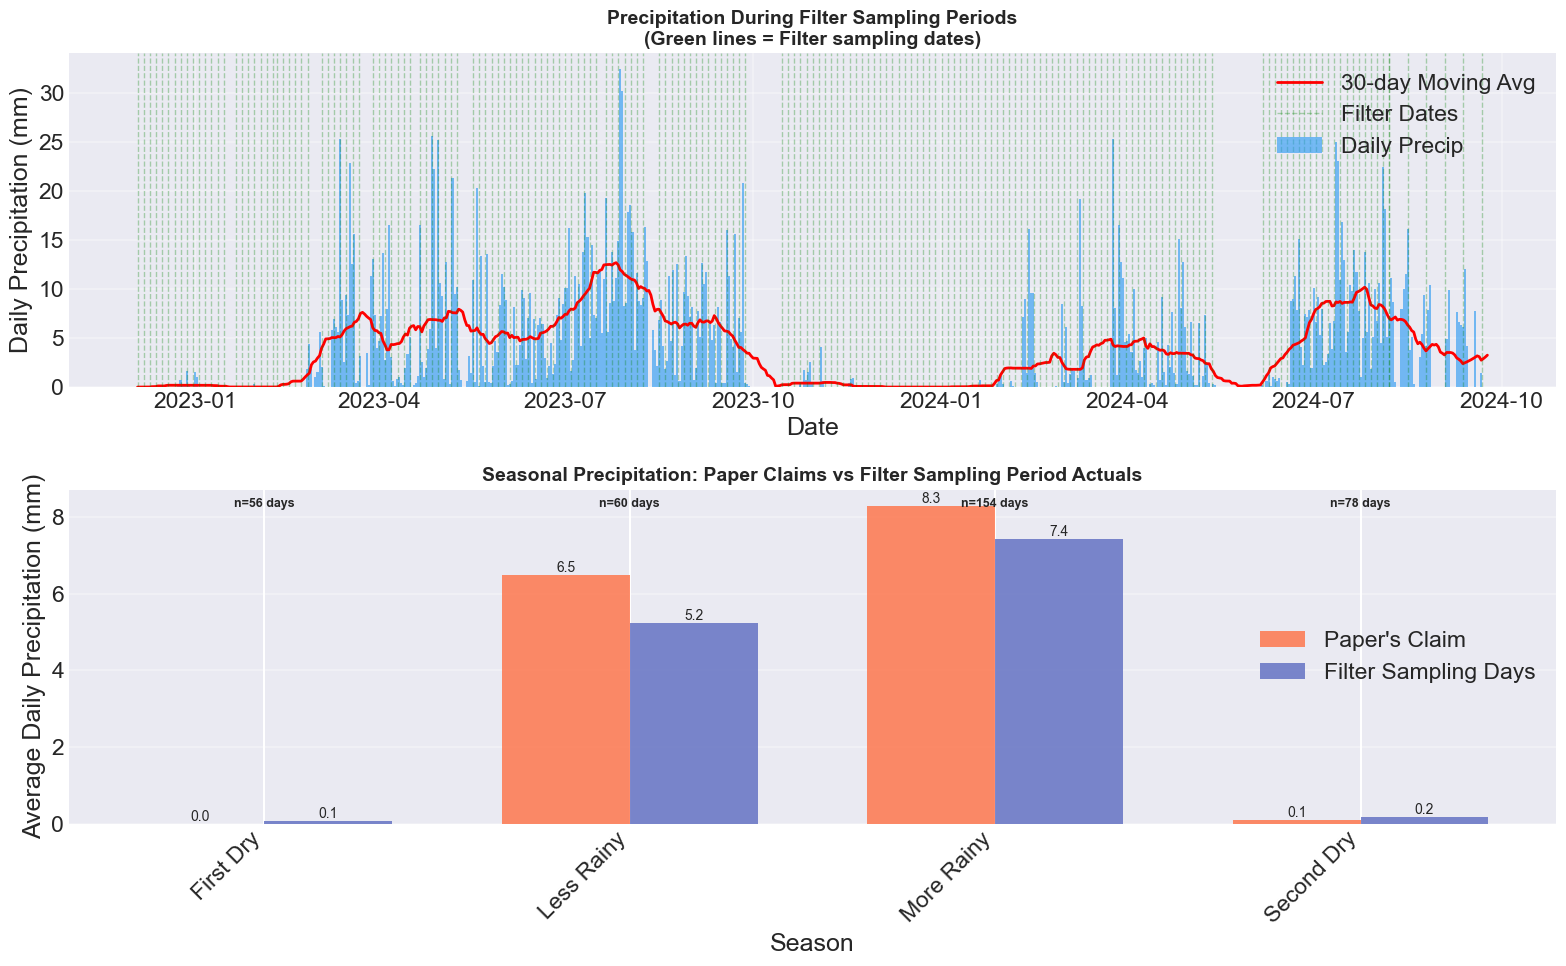

In [ ]:
#!/usr/bin/env python3
"""
Seasonal Weather Analysis - Constrained to FTIR Filter Sampling Dates
This version only analyzes precipitation data for dates when FTIR filters were collected
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================
# STEP 1: Load Filter Data and Extract FTIR Sampling Dates
# ============================================================

def normalize_filter_id(filter_id):
    """Normalize filter IDs so suffix variations like -# map to the same base filter."""
    if pd.isna(filter_id):
        return None
    filter_str = str(filter_id).strip()
    if not filter_str:
        return None
    parts = filter_str.split('-')
    if len(parts) >= 2:
        return f"{parts[0]}-{parts[1]}"
    return filter_str

def get_ftir_sampling_dates(filter_db_path, site_code='ETAD'):
    """
    Extract unique dates when FTIR filter measurements were taken for a specific site
    """
    # Load the unified filter dataset
    filter_df = pd.read_pickle(filter_db_path)
    
    print(f"📊 Filter dataset shape: {filter_df.shape}")
    print(f"📋 Dataset structure: Long format with Parameter column")
    print(f"🌍 Filtering for site: {site_code}")
    
    # Filter for specific site first
    if 'Site' in filter_df.columns:
        filter_df = filter_df[filter_df['Site'] == site_code].copy()
        print(f"✅ Filtered to {len(filter_df)} records for {site_code}")
    else:
        print("⚠️ Warning: No 'Site' column found - using all sites!")
    
    # Check if we have the expected columns
    if 'Parameter' in filter_df.columns and 'SampleDate' in filter_df.columns:
        # Get unique parameters to see what's available
        unique_params = filter_df['Parameter'].unique()
        print(f"📋 Available parameters at {site_code}: {len(unique_params)} unique types")
        
        # Look for EC_ftir parameter specifically
        if 'EC_ftir' in unique_params:
            print(f"✅ Found EC_ftir parameter")
            
            # Filter for EC_ftir measurements only
            ftir_data = filter_df[filter_df['Parameter'] == 'EC_ftir'].copy()
            
            # Normalize filter IDs to get unique filters
            if 'FilterId' in ftir_data.columns:
                filter_col = 'FilterId'
            elif 'FilterID' in ftir_data.columns:
                filter_col = 'FilterID'
            elif 'filter_id' in ftir_data.columns:
                filter_col = 'filter_id'
            else:
                # Find any column with 'filter' in name
                filter_cols = [col for col in ftir_data.columns if 'filter' in col.lower()]
                filter_col = filter_cols[0] if filter_cols else None
            
            if filter_col:
                print(f"📋 Using filter ID column: {filter_col}")
                
                # Normalize filter IDs
                ftir_data['normalized_filter'] = ftir_data[filter_col].apply(normalize_filter_id)
                
                # Get unique normalized filters with their dates
                unique_filters = ftir_data.groupby('normalized_filter')['SampleDate'].first()
                ftir_dates = unique_filters.dropna().values
                
                print(f"📊 Found {len(unique_filters)} unique {site_code} filters with EC_ftir measurements")
                print(f"📊 Unique sampling dates: {len(np.unique(ftir_dates))}")
            else:
                # Fallback to unique dates if no filter ID column
                ftir_dates = ftir_data['SampleDate'].dropna().unique()
                print(f"⚠️ No filter ID column found, using unique dates")
                print(f"📊 Found {len(ftir_dates)} unique dates with EC_ftir at {site_code}")
        else:
            print(f"⚠️ No EC_ftir parameter found at {site_code}. Using all filter sample dates.")
            ftir_dates = filter_df['SampleDate'].dropna().unique()
            print(f"📊 Found {len(ftir_dates)} total filter collection dates at {site_code}")
    else:
        raise ValueError("Required columns (Parameter, SampleDate) not found in filter dataset!")
    
    # Convert to datetime
    ftir_dates = pd.to_datetime(ftir_dates)
    print(f"📅 {site_code} date range: {ftir_dates.min()} to {ftir_dates.max()}")
    
    # Show sampling frequency
    if len(ftir_dates) > 1:
        sorted_dates = sorted(ftir_dates)
        date_diffs = [(sorted_dates[i+1] - sorted_dates[i]).days for i in range(len(sorted_dates)-1)]
        
        print(f"📊 {site_code} sampling gap statistics:")
        print(f"   Min gap: {min(date_diffs)} days")
        print(f"   Max gap: {max(date_diffs)} days")
        print(f"   Mean gap: {np.mean(date_diffs):.1f} days")
        print(f"   Median gap: {np.median(date_diffs):.0f} days")
    
    return ftir_dates

# ============================================================
# STEP 2: Modified Weather Data Loading Function
# ============================================================

def load_and_filter_weather_data(filepath, ftir_dates, window_days=0):
    """
    Load weather data and filter to FTIR sampling periods
    
    Parameters:
    -----------
    filepath : str
        Path to weather data CSV
    ftir_dates : array-like
        Dates when FTIR filters were collected
    window_days : int
        Number of days around each FTIR date to include (for context)
    """
    # Load all weather data
    df = pd.read_csv(filepath)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    
    # Convert to local timezone
    df.index = df.index.tz_localize('UTC').tz_convert('Africa/Addis_Ababa')
    
    print(f"📊 Total weather data: {len(df)} hourly records")
    print(f"📅 Weather data range: {df.index.min()} to {df.index.max()}")
    
    # Create a mask for dates near FTIR sampling
    mask = pd.Series(False, index=df.index)
    
    for ftir_date in ftir_dates:
        # Create a window around each FTIR sampling date
        start_date = pd.Timestamp(ftir_date) - pd.Timedelta(days=window_days)
        end_date = pd.Timestamp(ftir_date) + pd.Timedelta(days=window_days)
        
        # Make timezone aware if needed
        if df.index.tz is not None:
            if start_date.tz is None:
                start_date = start_date.tz_localize('UTC').tz_convert(df.index.tz)
            if end_date.tz is None:
                end_date = end_date.tz_localize('UTC').tz_convert(df.index.tz)
        
        # Update mask
        mask |= (df.index >= start_date) & (df.index <= end_date)
    
    # Filter the weather data
    df_filtered = df[mask].copy()
    
    print(f"✅ Filtered to {len(df_filtered)} records near filter sampling dates")
    print(f"   Window: ±{window_days} days around each filter date")
    if len(df_filtered) > 0:
        print(f"📅 Filtered range: {df_filtered.index.min()} to {df_filtered.index.max()}")
    
    return df_filtered

# ============================================================
# STEP 3: Analyze Seasonal Patterns for FTIR Sampling Periods
# ============================================================

def analyze_ftir_constrained_seasons(df_filtered, paper_seasons_2023):
    """
    Analyze precipitation only during FTIR sampling periods
    """
    if len(df_filtered) == 0:
        print("⚠️ No weather data available for filter sampling periods")
        return {}, pd.Series()
    
    # Calculate daily precipitation
    daily_precip = df_filtered['precipitation_mm'].resample('D').sum()
    
    # Remove days with no data (gaps between sampling periods)
    daily_precip = daily_precip[daily_precip.notna()]
    
    print(f"\n📊 Analyzing {len(daily_precip)} days with precipitation data near filter sampling")
    
    # Analyze each season
    results = {}
    
    for season_name, (start, end) in paper_seasons_2023.items():
        # Filter data for this period
        season_data = daily_precip[start:end]
        
        if len(season_data) > 0:
            # Calculate statistics
            results[season_name] = {
                'start_date': start,
                'end_date': end,
                'days_with_data': len(season_data),
                'total_precipitation_mm': season_data.sum(),
                'avg_daily_precipitation_mm': season_data.mean(),
                'max_daily_precipitation_mm': season_data.max(),
                'days_with_rain': (season_data > 0.1).sum(),
                'percent_rainy_days': ((season_data > 0.1).sum() / len(season_data) * 100) if len(season_data) > 0 else 0
            }
        else:
            results[season_name] = {
                'start_date': start,
                'end_date': end,
                'days_with_data': 0,
                'total_precipitation_mm': 0,
                'avg_daily_precipitation_mm': 0,
                'max_daily_precipitation_mm': 0,
                'days_with_rain': 0,
                'percent_rainy_days': 0
            }
    
    return results, daily_precip

# ============================================================
# STEP 4: Visualization Functions
# ============================================================

def create_ftir_constrained_visualization(daily_precip, results, ftir_dates):
    """
    Create visualization showing precipitation during FTIR sampling periods
    """
    if len(daily_precip) == 0:
        print("⚠️ No precipitation data to visualize")
        return None
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # Top panel: Daily precipitation with FTIR sampling markers
    ax1 = axes[0]
    
    # Plot precipitation bars
    ax1.bar(daily_precip.index, daily_precip.values, color='#2196F3', alpha=0.6, width=1, label='Daily Precip')
    
    # Add 30-day rolling average
    if len(daily_precip) > 30:
        rolling_30 = daily_precip.rolling(window=30, center=True, min_periods=1).mean()
        ax1.plot(rolling_30.index, rolling_30.values, 'r-', linewidth=2, label='30-day Moving Avg')
    
    # Mark FTIR sampling dates (converting to same timezone as daily_precip if needed)
    ftir_dates_tz = pd.to_datetime(ftir_dates)
    if daily_precip.index.tz is not None:
        ftir_dates_tz = ftir_dates_tz.tz_localize('UTC').tz_convert(daily_precip.index.tz)
    
    # Only plot markers within the data range
    for ftir_date in ftir_dates_tz:
        if daily_precip.index.min() <= ftir_date <= daily_precip.index.max():
            ax1.axvline(ftir_date, color='green', alpha=0.3, linestyle='--', linewidth=1)
    
    # Add one green line to legend
    ax1.axvline(daily_precip.index[0], color='green', alpha=0.3, linestyle='--', linewidth=1, label='Filter Dates')
    
    ax1.set_title('Precipitation During Filter Sampling Periods\n(Green lines = Filter sampling dates)', 
                 fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Daily Precipitation (mm)')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Bottom panel: Seasonal comparison
    ax2 = axes[1]
    
    seasons = list(results.keys())
    paper_values = [0.0, 6.5, 8.3, 0.1]  # Paper's claims
    actual_values = [results[s]['avg_daily_precipitation_mm'] for s in seasons]
    days_sampled = [results[s]['days_with_data'] for s in seasons]
    
    x = np.arange(len(seasons))
    width = 0.35
    
    bars1 = ax2.bar(x - width/2, paper_values, width, label='Paper\'s Claim', 
                   color='#FF7043', alpha=0.8)
    bars2 = ax2.bar(x + width/2, actual_values, width, label='Filter Sampling Days', 
                   color='#5C6BC0', alpha=0.8)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2, height,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=10)
    
    # Add sample size annotations
    for i, (season, n_days) in enumerate(zip(seasons, days_sampled)):
        ax2.text(i, ax2.get_ylim()[1] * 0.95, f'n={n_days} days', 
                ha='center', fontsize=9, fontweight='bold')
    
    ax2.set_xlabel('Season')
    ax2.set_ylabel('Average Daily Precipitation (mm)')
    ax2.set_title('Seasonal Precipitation: Paper Claims vs Filter Sampling Period Actuals', 
                 fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels([s.replace(' Season', '') for s in seasons], rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig

# ============================================================
# MAIN EXECUTION
# ============================================================

def main():
    # File paths - Update these to your actual paths
    weather_path = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Weather Data/Meteostat/addis_ababa_weather_data_cleaned.csv"
    filter_db_path = "../FTIR_HIPS_Chem/Filter Data/unified_filter_dataset.pkl"
    
    print("=" * 60)
    print("SEASONAL ANALYSIS CONSTRAINED TO FILTER SAMPLING PERIODS")
    print("=" * 60)
    
    # Step 1: Get FTIR sampling dates from unique filters FOR ETAD ONLY
    print("\n📋 Loading unique filter sampling dates for ETAD site...")
    try:
        ftir_dates = get_ftir_sampling_dates(filter_db_path, site_code='ETAD')
        print(f"✅ Successfully identified {len(ftir_dates)} unique ETAD filter dates")
    except Exception as e:
        print(f"❌ Error loading filter data: {e}")
        return None, None, None, None
    
    # Step 2: Load and filter weather data
    print("\n🌦️ Loading weather data filtered to sampling periods...")
    df_filtered = load_and_filter_weather_data(weather_path, ftir_dates, window_days=3)
    
    # Paper's seasonal definitions for 2023
    seasons_2023 = {
        'First Dry Season': ('2023-01-01', '2023-02-25'),
        'Less Rainy Season': ('2023-02-27', '2023-04-27'),
        'More Rainy Season': ('2023-04-30', '2023-09-30'),
        'Second Dry Season': ('2023-10-01', '2023-12-17')
    }
    
    # Step 3: Analyze according to paper's seasonal definitions
    print("\n📊 Analyzing seasonal patterns during sampling...")
    results, daily_precip = analyze_ftir_constrained_seasons(df_filtered, seasons_2023)
    
    # Step 4: Create comparison table
    if results:
        print("\n" + "=" * 60)
        print("COMPARISON: Paper's Claims vs Sampling Period Actuals")
        print("=" * 60)
        
        comparison_data = []
        for season, stats in results.items():
            paper_claim = {'First Dry Season': 0.0, 'Less Rainy Season': 6.5, 
                          'More Rainy Season': 8.3, 'Second Dry Season': 0.1}[season]
            
            comparison_data.append({
                'Season': season,
                'Paper Claim (mm/day)': paper_claim,
                'Sampling Period Avg (mm/day)': round(stats['avg_daily_precipitation_mm'], 2),
                'Days Sampled': stats['days_with_data'],
                'Total Rain (mm)': round(stats['total_precipitation_mm'], 1),
                '% Rainy Days': round(stats['percent_rainy_days'], 1)
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        print("\n", comparison_df.to_string(index=False))
        
        # Step 5: Create visualizations
        print("\n📈 Generating visualizations...")
        fig = create_ftir_constrained_visualization(daily_precip, results, ftir_dates)
        
        # Summary
        print("\n" + "=" * 60)
        print("KEY FINDINGS")
        print("=" * 60)
        
        total_sample_days = sum(r['days_with_data'] for r in results.values())
        print(f"✅ Total days analyzed: {total_sample_days} (only days near filter sampling)")
        print(f"📊 Filter sampling captured data from all four seasons")
        
        for season, stats in results.items():
            if stats['days_with_data'] > 0:
                paper_claim = {'First Dry Season': 0.0, 'Less Rainy Season': 6.5, 
                              'More Rainy Season': 8.3, 'Second Dry Season': 0.1}[season]
                diff = stats['avg_daily_precipitation_mm'] - paper_claim
                
                print(f"\n{season}:")
                print(f"  Sampling days analyzed: {stats['days_with_data']}")
                print(f"  Actual avg: {stats['avg_daily_precipitation_mm']:.2f} mm/day")
                print(f"  Difference from paper: {diff:+.2f} mm/day")
        
        if fig:
            plt.show()
        
        return comparison_df, results, daily_precip, df_filtered
    else:
        print("⚠️ No results to display")
        return None, {}, pd.Series(), df_filtered

# Run the analysis
if __name__ == "__main__":
    comparison_df, results, daily_precip, df_filtered = main()